In [27]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import pandas as pd
import pickle
from timeit import default_timer as timer
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import nltk as nltk
import math

import os
import cProfile, pstats, io
#import memory_profiler
import psutil
import gc

# Enabling eager execution 

In [28]:
tf.enable_eager_execution()
process = psutil.Process(os.getpid())

In [29]:
print(process.memory_info().rss / (1024*1024), 'MB') # to get memory used by this process in MB
#https://stackoverflow.com/questions/938733/total-memory-used-by-python-process

#https://pypi.org/project/memory-profiler/ - did not use it

2996.5234375 MB


# Load Google vectors

In [30]:
UNK = '</s>'
FILLER = '</fill>'

dirname = os.getcwd()
googlePath = os.path.join(dirname, 'datasets/')
outfile = googlePath +'google_word_corpus.pic'

with open(outfile, 'rb') as pickle_file:    
    googleCorpus, google_corpus_word_to_int, google_corpus_int_to_word = pickle.load(pickle_file)
googleSet = pd.read_csv(googlePath+'GoogleNews-vectors-negative10.txt', sep=' ', header=None)

print(googleSet.shape)
print(googleSet.head())

# TO BE DONE - Appropriate value should be added for FILLER
fill_data = {0:FILLER}
for i in range(1, googleSet.shape[1]):
    fill_data[i] = i
googleSet = googleSet.append(fill_data, ignore_index=True)

print(googleSet.shape)
print(googleSet.head())

temp = list(googleCorpus)
temp.append(FILLER)
googleCorpus = set(temp)
corpus_length = len(google_corpus_word_to_int)
google_corpus_word_to_int[FILLER] = corpus_length
google_corpus_int_to_word[corpus_length] = FILLER


googleWords = googleSet.iloc[:,0:1]
googleVectors = googleSet.iloc[:,1:]


(1965717, 11)
     0         1         2         3         4         5         6         7   \
0  </s>  0.001129 -0.000896  0.000319  0.001534  0.001106 -0.001404 -0.000031   
1    ##  0.168945 -0.062988 -0.000265  0.063477  0.087402 -0.030029  0.001450   
2  ####  0.107910  0.094238 -0.018555 -0.018799 -0.007111 -0.139648 -0.046631   
3     $  0.113770 -0.117676  0.064941  0.132812  0.054932 -0.099121  0.071289   
4   ###  0.149414 -0.191406  0.044189  0.104980  0.016846 -0.135742 -0.085449   

         8         9         10  
0 -0.000420 -0.000576  0.001076  
1 -0.077637  0.199219 -0.001770  
2 -0.063965  0.098145  0.135742  
3 -0.013306  0.271484 -0.083984  
4  0.074219  0.088867 -0.044922  
(1965718, 11)
     0         1         2         3         4         5         6         7   \
0  </s>  0.001129 -0.000896  0.000319  0.001534  0.001106 -0.001404 -0.000031   
1    ##  0.168945 -0.062988 -0.000265  0.063477  0.087402 -0.030029  0.001450   
2  ####  0.107910  0.094238 -0.018555 

In [31]:
#UNK = '<unk>'

#glovePath = '/media/kandy/hdd/master-thesis/datasets/'
#outfile = glovePath +'glove_word_corpus.pic'

#with open(outfile, 'rb') as pickle_file:    
#    gloveCorpus, glove_corpus_word_to_int, glove_corpus_int_to_word = pickle.load(pickle_file)
#gloveSet = pd.read_csv(glovePath+'glove.42B.10d.txt', sep=' ', header=None)
#print(gloveSet.shape)
#print(gloveSet.head())

#gloveWords = gloveSet.iloc[:,0:1]
#gloveVectors = gloveSet.iloc[:,1:]

# Load training and test dataset

In [32]:
#treeDataframe = pd.read_csv(googlePath+'constituency-parsing-data-all-UNK.csv', sep=' ', header=None )
#treeDataframe = pd.read_csv(googlePath+'constituency-parsing-data-all-UNK-less-40-words.csv', sep=' ', header=None )
treeDataframe = pd.read_csv(googlePath+'constituency-parsing-data-40-UNK-NOLABEL.csv', sep=' ', header=None )

treeDataframe.columns =['sentence', 'tree']
treeDataframe['tree'] = treeDataframe['tree'].apply(nltk.Tree.fromstring)

treeDataframe.head()

,sentence,tree
0,pierre </s> </s> </s> years old </s> will join...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
1,mr. </s> is chairman of elsevier n.v. </s> the...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
2,rudolph agnew </s> </s> years old and former c...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
3,the asbestos fiber </s> </s> </s> is unusually...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
4,lorillard inc. </s> the unit of new </s> loews...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...


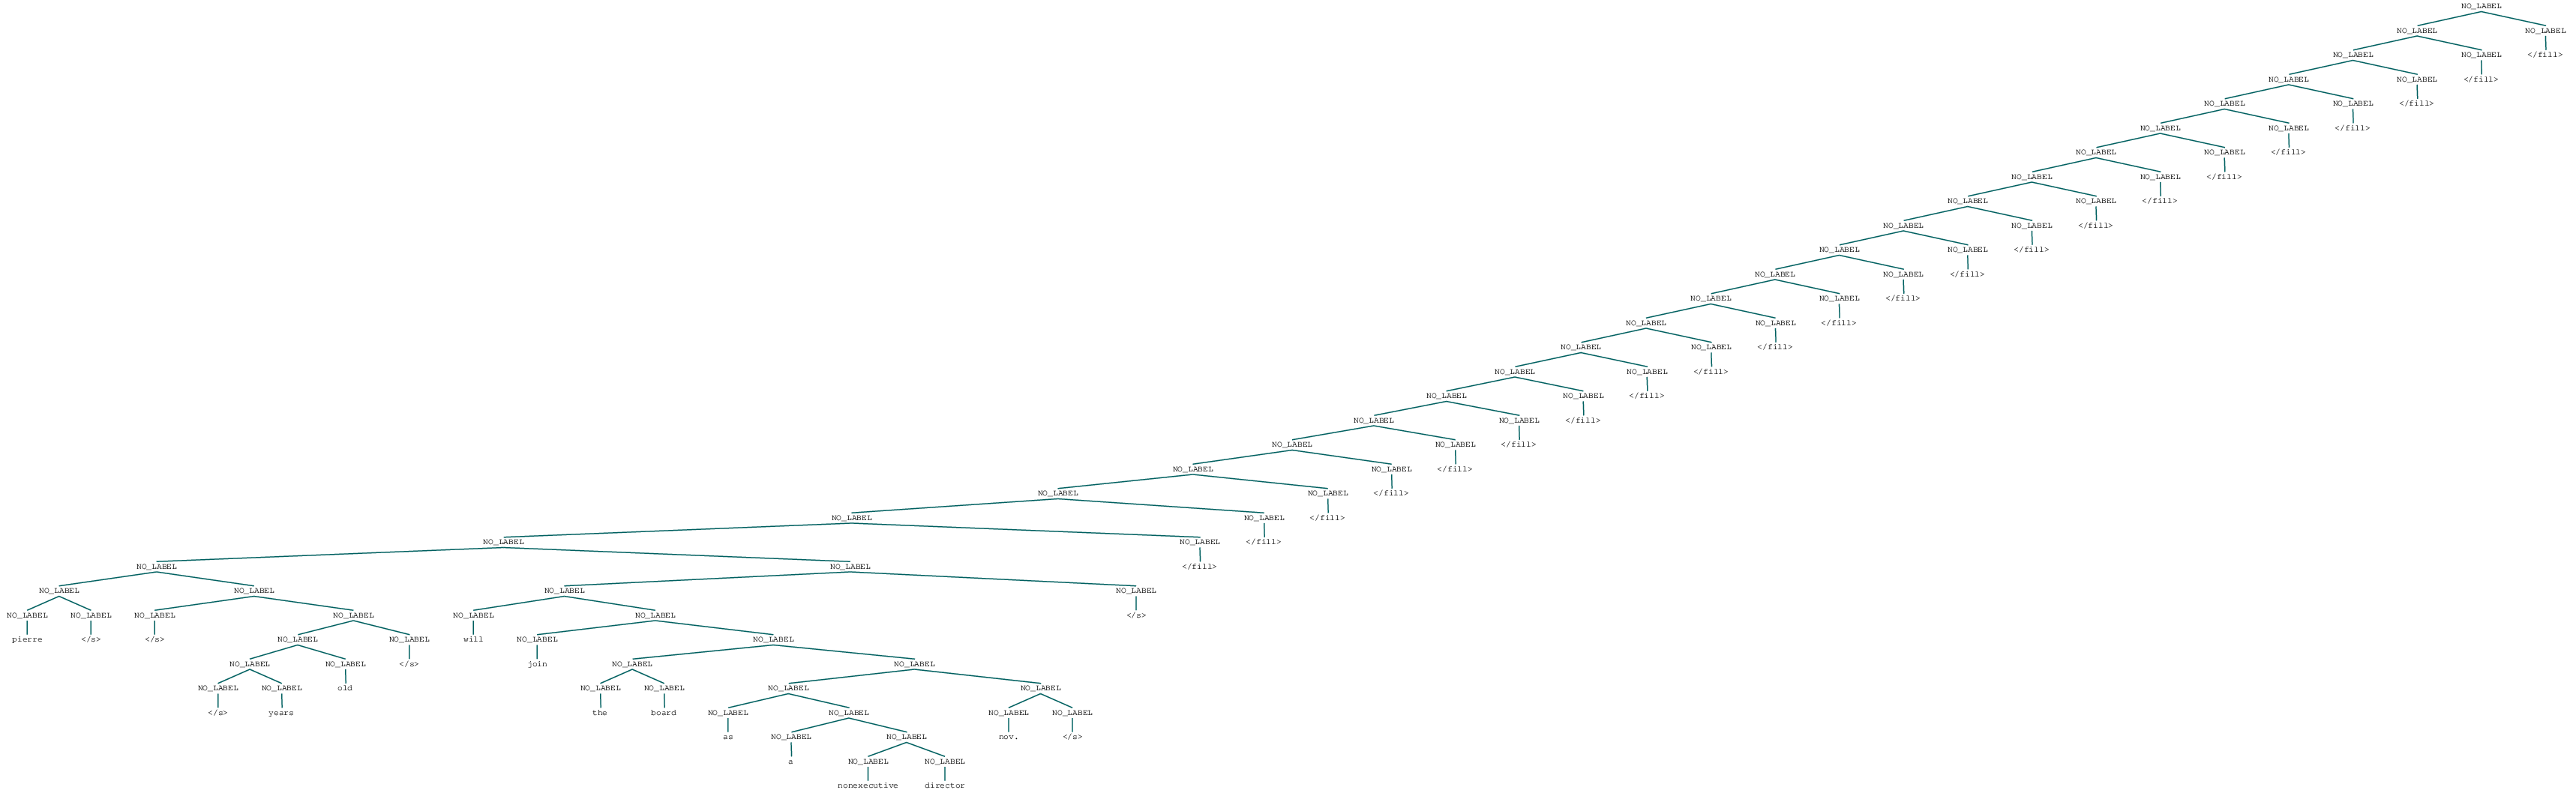

In [35]:
treeDataframe.iat[0,1]

In [36]:
def find_max(sentence):
    words = sentence.split()
    return len(words)

MAX_LEN_SENT = treeDataframe['sentence'].apply(find_max).max()   

In [37]:
def convert_imdb_corpus_into_int(sentence):
    words = sentence.split()
    words_length = len(words)
    for i in range(MAX_LEN_SENT - words_length):
        words.append(FILLER)
    words_to_num = [google_corpus_word_to_int[word] for word in words]
    return words_to_num

treeDataframe_num = treeDataframe.copy()
treeDataframe_num['sentence'] = treeDataframe_num['sentence'].apply(convert_imdb_corpus_into_int)
treeDataframe_num.head()

,sentence,tree
0,"[353287, 920150, 920150, 920150, 1131873, 1851...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
1,"[778656, 920150, 1025196, 261666, 920355, 5478...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
2,"[880384, 206120, 920150, 920150, 1131873, 1851...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
3,"[1323513, 151538, 1349057, 920150, 920150, 920...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
4,"[529848, 234617, 920150, 1323513, 1901239, 920...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...


In [38]:
treeDF_train, treeDF_test = sklearn.model_selection.train_test_split(treeDataframe_num, test_size=0.2)
print(treeDF_train.shape)
print(treeDF_test.shape)

(35067, 2)
(8767, 2)


In [39]:
#treeDF_train = treeDataframe_num.iloc[treeDataframe_num.shape[0]-50:treeDataframe_num.shape[0]]
#treeDF_test = treeDataframe_num.iloc[0:treeDataframe_num.shape[0]-50]
#print(treeDF_train.shape)
#print(treeDF_test.shape)

# Model and the Parameters

In [40]:
STATE_SIZE = 10
embeddings = tfe.Variable(name='embeddings', validate_shape= googleVectors.shape, 
                          initial_value=googleVectors.values, 
                          dtype=tf.float32, trainable=False)
w = tfe.Variable(name='w', validate_shape=(2*googleVectors.shape[1], STATE_SIZE), 
                 initial_value=tf.contrib.layers.xavier_initializer()(shape=(2*googleVectors.shape[1], STATE_SIZE)),
                 dtype=tf.float32)
b = tfe.Variable(name='b', validate_shape=(1, STATE_SIZE),
                 initial_value=tf.contrib.layers.xavier_initializer()(shape=(1, STATE_SIZE)),
                 dtype=tf.float32)

w_score = tfe.Variable(name='w_score', validate_shape=(STATE_SIZE, 1), 
                 initial_value=tf.contrib.layers.xavier_initializer()(shape=(STATE_SIZE, 1)),
                 dtype=tf.float32)
b_score = tfe.Variable(name='b_score', validate_shape=(1, 1),
                 initial_value=tf.contrib.layers.xavier_initializer()(shape=(1, 1)),
                 dtype=tf.float32)

#print(w)
#print(b)
#print(w_score)
#print(b_score)

In [41]:
print(embeddings.shape)
lookup = tf.nn.embedding_lookup(embeddings, google_corpus_word_to_int['</s>'])
lookup = tf.reshape(lookup, shape=(1, lookup.shape[0]))
print(lookup)

(1965718, 10)
tf.Tensor(
[[ 0.09570312 -0.03881836  0.05883789  0.03930664 -0.01300049 -0.1484375
   0.07568359 -0.13378906  0.2890625   0.00370789]], shape=(1, 10), dtype=float32)


In [42]:
def compare_trees(actual, predicted):
    actual_sub_trees = actual.subtrees()
    
    
    total_count = 0.0 #len(actual_sub_trees)
    match_count = 0.0
    
    for sub_tree in actual_sub_trees:
        #print('Sub Tree:', sub_tree)
        #print(predicted_sub_trees)
        predicted_sub_trees = predicted.subtrees()
        for temp_tree in predicted_sub_trees:
            #print(' ', temp_tree)
            if(sub_tree == temp_tree):
                match_count = match_count + 1.0
                break
        total_count = total_count + 1.0
        #break
    #print('Match:', match_count,' Total:', total_count)
    
    return [match_count/total_count, match_count, total_count]

#compare_trees(treeDF_train.iat[2,1], treeDF_train.iat[2,1])

t1 = nltk.Tree.fromstring("(S (NP I) (VP (V saw) (NP him)))")
sub_trees = t1.subtrees()
for sub_tree in sub_trees:
    print(sub_tree)

(S (NP I) (VP (V saw) (NP him)))
(NP I)
(VP (V saw) (NP him))
(V saw)
(NP him)


In [43]:
def embedding_lookup(input_words):
    words = tf.nn.embedding_lookup(embeddings, input_words)
    return words

In [44]:
gc.collect()

pr = cProfile.Profile()
pr.enable()

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

start_memory = process.memory_info().rss
start_time = timer()
MAX_BATCH_SIZE = 1024
MAX_WORD_COUNT = 40
BATCH_COUNT = int(math.ceil(treeDF_train.shape[0]/MAX_BATCH_SIZE))
print('StartMemory (MB): ', start_memory/(1024*1024))

for epoch in range(300) :

    for batch_no in range(BATCH_COUNT):

        print('Epoch:', epoch,'Batch:', batch_no,'/',BATCH_COUNT)
        with tf.GradientTape() as tape:
            start = batch_no * MAX_BATCH_SIZE
            stop = start + MAX_BATCH_SIZE
            mini_batch_data = treeDF_train.iloc[start:stop]
            BATCH_SIZE = mini_batch_data.shape[0]
            embedding_lookup_out = embedding_lookup(mini_batch_data['sentence'])
            print(embedding_lookup_out.shape)
            data = embedding_lookup_out
            #data = tf.slice(embedding_lookup_out, [0,0,0], [BATCH_SIZE,MAX_WORD_COUNT,STATE_SIZE])
            print(data.shape)

            NO_OF_SENTENCE = data.shape[0]
            NO_OF_WORDS = data.shape[1]

            for i in range(NO_OF_WORDS-1):
                first_data = tf.slice(data, [0,0,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])
                second_data = tf.slice(data, [0,1,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])

                concatenated_data = tf.concat([first_data, second_data], axis=2)

                #type(concatenated_data)
                reshaped_data = tf.reshape(concatenated_data, (-1,2*STATE_SIZE))
                #print(reshaped_data.shape)
                output_data = tf.tanh(tf.matmul(reshaped_data, w) + b)
                #print(output_data.shape)
                reshaped_output_data = tf.reshape(output_data, (NO_OF_SENTENCE,-1,STATE_SIZE))
                #print(reshaped_output_data.shape)

                scored_data = tf.matmul(output_data, w_score) + b_score
                #print(scored_data.shape)
                reshaped_scored_data = tf.reshape(scored_data, (NO_OF_SENTENCE,-1,1))
                #print(reshaped_scored_data.shape)

                argmax_score = tf.argmax(reshaped_scored_data, axis=1, output_type=tf.int32)
                squeeze_argmax_score = tf.squeeze(argmax_score)
                range_data = (tf.range(0, NO_OF_SENTENCE) * NO_OF_WORDS)
                range_data = tf.reshape(range_data, (NO_OF_SENTENCE,1))
                range_data = range_data + argmax_score

                range_data_minus = (tf.range(0, NO_OF_SENTENCE) * (NO_OF_WORDS-1))
                range_data_minus = tf.reshape(range_data_minus, (NO_OF_SENTENCE,1))
                range_data_minus = range_data_minus + argmax_score

                #print(range_data.shape)
                #print(argmax_score.shape)
                #print(squeeze_argmax_score.shape)
                reshaped_data = tf.reshape(data, (-1,STATE_SIZE))

                #print(range_data)

                range_data_list = tf.squeeze(range_data).numpy().tolist()
                #list_data = list(range(NO_OF_SENTENCE*NO_OF_WORDS))
                #bool_mask_data = [True if tmp not in tf.squeeze(range_data).numpy() else False for tmp in list_data]
                #print(len(bool_mask_data))
                #print(bool_mask_data[2])
                #print(reshaped_data[2])
                bool_mask_data = [True] * (NO_OF_SENTENCE*NO_OF_WORDS)
                for i in range_data_list:
                    bool_mask_data[i] = False
                reshaped_new_data = tf.boolean_mask(reshaped_data, bool_mask_data, axis=0)
                #print(reshaped_new_data.shape)
                #print(reshaped_new_data[2])

                #list_data = list(range(NO_OF_SENTENCE*(NO_OF_WORDS-1)))
                #bool_mask_data = [True if tmp not in tf.squeeze(range_data).numpy() else False for tmp in list_data]
                #print(len(bool_mask_data))
                #print(bool_mask_data[2])
                #print(reshaped_new_data[2])
                #print(output_data[2])

                range_data_minus_list = tf.squeeze(range_data_minus).numpy().tolist()
                bool_mask_data = [True] * (NO_OF_SENTENCE*(NO_OF_WORDS-1))
                for i in range_data_minus_list:
                    bool_mask_data[i] = False
                #print(len(bool_mask_data))
                #print(output_data.shape)
                #data = tf.where(bool_mask_data, reshaped_new_data, output_data)
                data = tf.where(bool_mask_data, reshaped_new_data, output_data)
                data = tf.reshape(data,shape=(NO_OF_SENTENCE, -1, STATE_SIZE))
                #print(data[2])
                NO_OF_SENTENCE = data.shape[0]
                NO_OF_WORDS = data.shape[1]

            scores = tf.squeeze(reshaped_scored_data)
            losses = tf.abs(scores - 10)
            avg_loss = tf.reduce_mean(losses)
            grads = tape.gradient(avg_loss, [w,b,w_score,b_score])
            grad_op = optimizer.apply_gradients(zip(grads, [w,b,w_score,b_score]), 
                                      global_step=tf.train.get_or_create_global_step())
            print(avg_loss)
            stop_memory = process.memory_info().rss
            stop_time = timer()

            print('Time taken (sec) : ', stop_time - start_time)
            print('Memory consumed (MB) : ', (stop_memory - start_memory) /(1024*1024))
            #gc.collect()
    if(epoch %10 == 0):
        parameters = [w, b, w_score, b_score]
        with open('parameters'+str(timer())+'.pic', 'wb') as pickle_file:    
            pickle.dump(parameters, pickle_file)
pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

StartMemory (MB):  4982.1328125
Epoch: 0 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(12.722394, shape=(), dtype=float32)
Time taken (sec) :  2.2234968850025325
Memory consumed (MB) :  13.44140625
Epoch: 0 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(11.978586, shape=(), dtype=float32)
Time taken (sec) :  3.989800481002021
Memory consumed (MB) :  15.32421875
Epoch: 0 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(11.355531, shape=(), dtype=float32)
Time taken (sec) :  6.2356787669996265
Memory consumed (MB) :  16.26171875
Epoch: 0 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(10.929322, shape=(), dtype=float32)
Time taken (sec) :  7.824605996996979
Memory consumed (MB) :  16.98046875
Epoch: 0 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(10.29842, shape=(), dtype=float32)
Time taken (sec) :  9.539918654998473
Memory consumed (MB) :  17.671875
Epoch: 0 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(9.770811, shape=(), dtype=float32)
Time t

tf.Tensor(0.09669748, shape=(), dtype=float32)
Time taken (sec) :  74.92461078800261
Memory consumed (MB) :  14.61328125
Epoch: 1 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.18561101, shape=(), dtype=float32)
Time taken (sec) :  76.40616979699553
Memory consumed (MB) :  14.61328125
Epoch: 1 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5997751, shape=(), dtype=float32)
Time taken (sec) :  77.89782400400145
Memory consumed (MB) :  14.61328125
Epoch: 1 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.18532035, shape=(), dtype=float32)
Time taken (sec) :  79.42832318400178
Memory consumed (MB) :  14.61328125
Epoch: 1 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6146838, shape=(), dtype=float32)
Time taken (sec) :  80.89947383899562
Memory consumed (MB) :  14.61328125
Epoch: 1 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14675546, shape=(), dtype=float32)
Time taken (sec) :  82.40821377799875
Memory consumed (MB) :  14.62890625
Epoch:

tf.Tensor(0.68655604, shape=(), dtype=float32)
Time taken (sec) :  144.4407815059967
Memory consumed (MB) :  14.89453125
Epoch: 2 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.09147233, shape=(), dtype=float32)
Time taken (sec) :  145.9251757059974
Memory consumed (MB) :  14.89453125
Epoch: 2 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.68782955, shape=(), dtype=float32)
Time taken (sec) :  147.3991285910015
Memory consumed (MB) :  14.89453125
Epoch: 2 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.097116336, shape=(), dtype=float32)
Time taken (sec) :  148.86974618500244
Memory consumed (MB) :  14.89453125
Epoch: 2 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6888293, shape=(), dtype=float32)
Time taken (sec) :  150.35911041899817
Memory consumed (MB) :  14.89453125
Epoch: 2 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.09013503, shape=(), dtype=float32)
Time taken (sec) :  151.83898158599914
Memory consumed (MB) :  14.89453125
E

tf.Tensor(0.67402303, shape=(), dtype=float32)
Time taken (sec) :  212.62650202900113
Memory consumed (MB) :  15.48828125
Epoch: 4 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.104259, shape=(), dtype=float32)
Time taken (sec) :  214.100832928998
Memory consumed (MB) :  15.48828125
Epoch: 4 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6820025, shape=(), dtype=float32)
Time taken (sec) :  215.5608415079987
Memory consumed (MB) :  15.48828125
Epoch: 4 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.09788576, shape=(), dtype=float32)
Time taken (sec) :  217.03055866900104
Memory consumed (MB) :  15.48828125
Epoch: 4 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.69152033, shape=(), dtype=float32)
Time taken (sec) :  218.51298343799863
Memory consumed (MB) :  15.6640625
Epoch: 4 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.10008857, shape=(), dtype=float32)
Time taken (sec) :  220.02711163299682
Memory consumed (MB) :  15.6640625
Epoch: 4 Ba

tf.Tensor(0.11133987, shape=(), dtype=float32)
Time taken (sec) :  282.97723745799885
Memory consumed (MB) :  16.0703125
Epoch: 5 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.66182226, shape=(), dtype=float32)
Time taken (sec) :  284.4427236629999
Memory consumed (MB) :  16.0703125
Epoch: 5 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.11852973, shape=(), dtype=float32)
Time taken (sec) :  285.90563955200196
Memory consumed (MB) :  16.0703125
Epoch: 5 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6668612, shape=(), dtype=float32)
Time taken (sec) :  287.39198024899815
Memory consumed (MB) :  16.0703125
Epoch: 5 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.11290342, shape=(), dtype=float32)
Time taken (sec) :  288.8792768259955
Memory consumed (MB) :  16.0703125
Epoch: 5 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6601074, shape=(), dtype=float32)
Time taken (sec) :  290.37526820699713
Memory consumed (MB) :  16.0703125
Epoch: 5

tf.Tensor(0.5997306, shape=(), dtype=float32)
Time taken (sec) :  352.7282309380025
Memory consumed (MB) :  16.0703125
Epoch: 6 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.17432208, shape=(), dtype=float32)
Time taken (sec) :  354.1871223689959
Memory consumed (MB) :  16.0703125
Epoch: 6 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.60457706, shape=(), dtype=float32)
Time taken (sec) :  355.6607121490015
Memory consumed (MB) :  16.0703125
Epoch: 6 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.18106472, shape=(), dtype=float32)
Time taken (sec) :  357.13482152499637
Memory consumed (MB) :  16.0703125
Epoch: 6 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6138894, shape=(), dtype=float32)
Time taken (sec) :  358.6125410070017
Memory consumed (MB) :  16.0703125
Epoch: 6 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.16773722, shape=(), dtype=float32)
Time taken (sec) :  360.0885251849977
Memory consumed (MB) :  16.0703125
Epoch: 6 Ba

tf.Tensor(0.64093137, shape=(), dtype=float32)
Time taken (sec) :  421.3012522739955
Memory consumed (MB) :  16.2109375
Epoch: 8 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14533593, shape=(), dtype=float32)
Time taken (sec) :  422.76018851299887
Memory consumed (MB) :  16.2109375
Epoch: 8 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.63617617, shape=(), dtype=float32)
Time taken (sec) :  424.2369770009973
Memory consumed (MB) :  16.2109375
Epoch: 8 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1465465, shape=(), dtype=float32)
Time taken (sec) :  425.69238505500107
Memory consumed (MB) :  16.2109375
Epoch: 8 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.64097416, shape=(), dtype=float32)
Time taken (sec) :  427.1635125210014
Memory consumed (MB) :  16.2109375
Epoch: 8 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13539888, shape=(), dtype=float32)
Time taken (sec) :  428.63043886800006
Memory consumed (MB) :  16.2109375
Epoch: 8 Ba

tf.Tensor(0.65380263, shape=(), dtype=float32)
Time taken (sec) :  490.9330029249977
Memory consumed (MB) :  16.21484375
Epoch: 9 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13719727, shape=(), dtype=float32)
Time taken (sec) :  492.3977525770024
Memory consumed (MB) :  16.21484375
Epoch: 9 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.651191, shape=(), dtype=float32)
Time taken (sec) :  493.8813844479955
Memory consumed (MB) :  16.21484375
Epoch: 9 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1197709, shape=(), dtype=float32)
Time taken (sec) :  495.34347913899546
Memory consumed (MB) :  16.21484375
Epoch: 9 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6457908, shape=(), dtype=float32)
Time taken (sec) :  496.8108119089957
Memory consumed (MB) :  16.21484375
Epoch: 9 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13351397, shape=(), dtype=float32)
Time taken (sec) :  498.2734945609991
Memory consumed (MB) :  16.21484375
Epoch: 

tf.Tensor(0.66027576, shape=(), dtype=float32)
Time taken (sec) :  560.5211897779955
Memory consumed (MB) :  16.21875
Epoch: 10 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12464658, shape=(), dtype=float32)
Time taken (sec) :  561.9952983819967
Memory consumed (MB) :  16.21875
Epoch: 10 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.6519267, shape=(), dtype=float32)
Time taken (sec) :  562.470172854999
Memory consumed (MB) :  16.21875
Epoch: 11 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12856719, shape=(), dtype=float32)
Time taken (sec) :  563.9335706889979
Memory consumed (MB) :  16.21875
Epoch: 11 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.66359353, shape=(), dtype=float32)
Time taken (sec) :  565.4002645639994
Memory consumed (MB) :  16.21875
Epoch: 11 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.11553054, shape=(), dtype=float32)
Time taken (sec) :  566.8596391899991
Memory consumed (MB) :  16.21875
Epoch: 11 Batch: 3 / 35


tf.Tensor(0.65877867, shape=(), dtype=float32)
Time taken (sec) :  629.1622636870015
Memory consumed (MB) :  16.21875
Epoch: 12 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.115715474, shape=(), dtype=float32)
Time taken (sec) :  630.6198061809991
Memory consumed (MB) :  16.21875
Epoch: 12 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.65118, shape=(), dtype=float32)
Time taken (sec) :  632.0842771460011
Memory consumed (MB) :  16.21875
Epoch: 12 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13575523, shape=(), dtype=float32)
Time taken (sec) :  633.5590913859996
Memory consumed (MB) :  16.21875
Epoch: 12 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.66365045, shape=(), dtype=float32)
Time taken (sec) :  635.0262530269974
Memory consumed (MB) :  16.21875
Epoch: 12 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.114704356, shape=(), dtype=float32)
Time taken (sec) :  636.4901553309974
Memory consumed (MB) :  16.21875
Epoch: 12 Batch: 1

tf.Tensor(0.65488404, shape=(), dtype=float32)
Time taken (sec) :  698.745975181002
Memory consumed (MB) :  16.21875
Epoch: 13 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.123938315, shape=(), dtype=float32)
Time taken (sec) :  700.2233018650004
Memory consumed (MB) :  16.21875
Epoch: 13 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.65451664, shape=(), dtype=float32)
Time taken (sec) :  701.7061360680018
Memory consumed (MB) :  16.21875
Epoch: 13 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1226209, shape=(), dtype=float32)
Time taken (sec) :  703.1972763689992
Memory consumed (MB) :  16.21875
Epoch: 13 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6558379, shape=(), dtype=float32)
Time taken (sec) :  704.6658016729998
Memory consumed (MB) :  16.21875
Epoch: 13 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12370862, shape=(), dtype=float32)
Time taken (sec) :  706.1473178140004
Memory consumed (MB) :  16.21875
Epoch: 13 Batch: 29

tf.Tensor(0.6656821, shape=(), dtype=float32)
Time taken (sec) :  767.251320823998
Memory consumed (MB) :  16.21875
Epoch: 15 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.113333106, shape=(), dtype=float32)
Time taken (sec) :  768.7251112049998
Memory consumed (MB) :  16.21875
Epoch: 15 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6591775, shape=(), dtype=float32)
Time taken (sec) :  770.1954802089967
Memory consumed (MB) :  16.21875
Epoch: 15 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1298123, shape=(), dtype=float32)
Time taken (sec) :  771.6774943209966
Memory consumed (MB) :  16.21875
Epoch: 15 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.65781224, shape=(), dtype=float32)
Time taken (sec) :  773.1591042639993
Memory consumed (MB) :  16.21875
Epoch: 15 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.11617218, shape=(), dtype=float32)
Time taken (sec) :  774.6349437089957
Memory consumed (MB) :  16.21875
Epoch: 15 Batch: 7 / 35
(

tf.Tensor(0.6579313, shape=(), dtype=float32)
Time taken (sec) :  836.9283212299997
Memory consumed (MB) :  16.21875
Epoch: 16 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.11881984, shape=(), dtype=float32)
Time taken (sec) :  838.4090351720006
Memory consumed (MB) :  16.21875
Epoch: 16 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6486027, shape=(), dtype=float32)
Time taken (sec) :  839.8818146069971
Memory consumed (MB) :  16.21875
Epoch: 16 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1286866, shape=(), dtype=float32)
Time taken (sec) :  841.3557381489954
Memory consumed (MB) :  16.21875
Epoch: 16 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6544309, shape=(), dtype=float32)
Time taken (sec) :  842.8276337860007
Memory consumed (MB) :  16.21875
Epoch: 16 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.123855695, shape=(), dtype=float32)
Time taken (sec) :  844.2926441129966
Memory consumed (MB) :  16.21875
Epoch: 16 Batch: 20 

tf.Tensor(0.6519396, shape=(), dtype=float32)
Time taken (sec) :  906.592805499
Memory consumed (MB) :  16.21875
Epoch: 17 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12628523, shape=(), dtype=float32)
Time taken (sec) :  908.0676409279986
Memory consumed (MB) :  16.21875
Epoch: 17 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.65197396, shape=(), dtype=float32)
Time taken (sec) :  909.5216217950001
Memory consumed (MB) :  16.21875
Epoch: 17 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12850319, shape=(), dtype=float32)
Time taken (sec) :  910.997398628002
Memory consumed (MB) :  16.21875
Epoch: 17 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6494782, shape=(), dtype=float32)
Time taken (sec) :  912.460355176001
Memory consumed (MB) :  16.21875
Epoch: 17 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.122797005, shape=(), dtype=float32)
Time taken (sec) :  913.9320231250022
Memory consumed (MB) :  16.21875
Epoch: 17 Batch: 33 / 35

tf.Tensor(0.6518683, shape=(), dtype=float32)
Time taken (sec) :  975.1970714510026
Memory consumed (MB) :  16.31640625
Epoch: 19 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12404737, shape=(), dtype=float32)
Time taken (sec) :  976.679663062001
Memory consumed (MB) :  16.31640625
Epoch: 19 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6517669, shape=(), dtype=float32)
Time taken (sec) :  978.1583983469973
Memory consumed (MB) :  16.31640625
Epoch: 19 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12818702, shape=(), dtype=float32)
Time taken (sec) :  979.6293961240008
Memory consumed (MB) :  16.31640625
Epoch: 19 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6487875, shape=(), dtype=float32)
Time taken (sec) :  981.1119602030012
Memory consumed (MB) :  16.31640625
Epoch: 19 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1247188, shape=(), dtype=float32)
Time taken (sec) :  982.5741949000003
Memory consumed (MB) :  16.31640625
Epoch: 1

tf.Tensor(0.14014421, shape=(), dtype=float32)
Time taken (sec) :  1043.4177735339981
Memory consumed (MB) :  16.31640625
Epoch: 20 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6423365, shape=(), dtype=float32)
Time taken (sec) :  1044.8957277430018
Memory consumed (MB) :  16.31640625
Epoch: 20 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13613153, shape=(), dtype=float32)
Time taken (sec) :  1046.3785172169955
Memory consumed (MB) :  16.31640625
Epoch: 20 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6328809, shape=(), dtype=float32)
Time taken (sec) :  1047.8483839600012
Memory consumed (MB) :  16.31640625
Epoch: 20 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14642033, shape=(), dtype=float32)
Time taken (sec) :  1049.3140000040003
Memory consumed (MB) :  16.31640625
Epoch: 20 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6482153, shape=(), dtype=float32)
Time taken (sec) :  1050.783460781
Memory consumed (MB) :  16.31640625


tf.Tensor(0.63839084, shape=(), dtype=float32)
Time taken (sec) :  1111.5518321330019
Memory consumed (MB) :  16.31640625
Epoch: 21 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14183731, shape=(), dtype=float32)
Time taken (sec) :  1113.034130093998
Memory consumed (MB) :  16.31640625
Epoch: 21 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6355295, shape=(), dtype=float32)
Time taken (sec) :  1114.5047490270008
Memory consumed (MB) :  16.31640625
Epoch: 21 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13543823, shape=(), dtype=float32)
Time taken (sec) :  1115.9744354560025
Memory consumed (MB) :  16.31640625
Epoch: 21 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6357788, shape=(), dtype=float32)
Time taken (sec) :  1117.4456742109978
Memory consumed (MB) :  16.31640625
Epoch: 21 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.14494717, shape=(), dtype=float32)
Time taken (sec) :  1117.9484813980016
Memory consumed (MB) :  16.3164062

tf.Tensor(0.14049259, shape=(), dtype=float32)
Time taken (sec) :  1178.6367037689997
Memory consumed (MB) :  16.34765625
Epoch: 23 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.63424224, shape=(), dtype=float32)
Time taken (sec) :  1180.1158725999994
Memory consumed (MB) :  16.34765625
Epoch: 23 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14489703, shape=(), dtype=float32)
Time taken (sec) :  1181.5696447459995
Memory consumed (MB) :  16.34765625
Epoch: 23 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6313901, shape=(), dtype=float32)
Time taken (sec) :  1183.0410572830006
Memory consumed (MB) :  16.34765625
Epoch: 23 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14156316, shape=(), dtype=float32)
Time taken (sec) :  1184.5005618970026
Memory consumed (MB) :  16.34765625
Epoch: 23 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6397189, shape=(), dtype=float32)
Time taken (sec) :  1185.9708124300014
Memory consumed (MB) :  16.3476562

tf.Tensor(0.6251371, shape=(), dtype=float32)
Time taken (sec) :  1246.690469961999
Memory consumed (MB) :  16.34765625
Epoch: 24 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15221289, shape=(), dtype=float32)
Time taken (sec) :  1248.163539385001
Memory consumed (MB) :  16.34765625
Epoch: 24 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.61445856, shape=(), dtype=float32)
Time taken (sec) :  1249.6403045240004
Memory consumed (MB) :  16.34765625
Epoch: 24 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.16478984, shape=(), dtype=float32)
Time taken (sec) :  1251.1015450920022
Memory consumed (MB) :  16.34765625
Epoch: 24 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.63128895, shape=(), dtype=float32)
Time taken (sec) :  1252.5450503839966
Memory consumed (MB) :  16.34765625
Epoch: 24 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15126395, shape=(), dtype=float32)
Time taken (sec) :  1254.0024639979965
Memory consumed (MB) :  16.34765

tf.Tensor(0.16378143, shape=(), dtype=float32)
Time taken (sec) :  1314.6756831300008
Memory consumed (MB) :  16.34765625
Epoch: 25 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6152359, shape=(), dtype=float32)
Time taken (sec) :  1316.1464613339995
Memory consumed (MB) :  16.34765625
Epoch: 25 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1563186, shape=(), dtype=float32)
Time taken (sec) :  1317.619972954999
Memory consumed (MB) :  16.34765625
Epoch: 25 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.614964, shape=(), dtype=float32)
Time taken (sec) :  1319.0975479069966
Memory consumed (MB) :  16.34765625
Epoch: 25 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.16356248, shape=(), dtype=float32)
Time taken (sec) :  1319.6038461200005
Memory consumed (MB) :  16.34765625
Epoch: 26 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.61385447, shape=(), dtype=float32)
Time taken (sec) :  1321.0845946779955
Memory consumed (MB) :  16.34765625
E

tf.Tensor(0.6112581, shape=(), dtype=float32)
Time taken (sec) :  1381.7300296729954
Memory consumed (MB) :  16.34765625
Epoch: 27 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.16994493, shape=(), dtype=float32)
Time taken (sec) :  1383.1939793909987
Memory consumed (MB) :  16.34765625
Epoch: 27 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.61100465, shape=(), dtype=float32)
Time taken (sec) :  1384.6522313079986
Memory consumed (MB) :  16.34765625
Epoch: 27 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1595752, shape=(), dtype=float32)
Time taken (sec) :  1386.1340351300023
Memory consumed (MB) :  16.34765625
Epoch: 27 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.6163974, shape=(), dtype=float32)
Time taken (sec) :  1387.6005538499958
Memory consumed (MB) :  16.34765625
Epoch: 27 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.16356695, shape=(), dtype=float32)
Time taken (sec) :  1389.0805516870023
Memory consumed (MB) :  16.3476562

tf.Tensor(0.1714375, shape=(), dtype=float32)
Time taken (sec) :  1449.7439934430004
Memory consumed (MB) :  16.34765625
Epoch: 28 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5927405, shape=(), dtype=float32)
Time taken (sec) :  1451.224817025999
Memory consumed (MB) :  16.34765625
Epoch: 28 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.18803136, shape=(), dtype=float32)
Time taken (sec) :  1452.6812130909966
Memory consumed (MB) :  16.34765625
Epoch: 28 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.61185163, shape=(), dtype=float32)
Time taken (sec) :  1454.1487452639994
Memory consumed (MB) :  16.34765625
Epoch: 28 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.17050573, shape=(), dtype=float32)
Time taken (sec) :  1455.6015923689993
Memory consumed (MB) :  16.34765625
Epoch: 28 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5985307, shape=(), dtype=float32)
Time taken (sec) :  1457.0752114119969
Memory consumed (MB) :  16.347656

tf.Tensor(0.5912899, shape=(), dtype=float32)
Time taken (sec) :  1517.7328070919975
Memory consumed (MB) :  16.34765625
Epoch: 29 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.17982039, shape=(), dtype=float32)
Time taken (sec) :  1519.2021934500008
Memory consumed (MB) :  16.34765625
Epoch: 29 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.59179264, shape=(), dtype=float32)
Time taken (sec) :  1520.6513749299993
Memory consumed (MB) :  16.34765625
Epoch: 29 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.18660375, shape=(), dtype=float32)
Time taken (sec) :  1521.144412173002
Memory consumed (MB) :  16.34765625
Epoch: 30 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5889116, shape=(), dtype=float32)
Time taken (sec) :  1522.6274597070005
Memory consumed (MB) :  16.34765625
Epoch: 30 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.17913699, shape=(), dtype=float32)
Time taken (sec) :  1524.116633783
Memory consumed (MB) :  16.34765625
Epoc

tf.Tensor(0.19423755, shape=(), dtype=float32)
Time taken (sec) :  1584.8949933679978
Memory consumed (MB) :  16.34765625
Epoch: 31 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5865608, shape=(), dtype=float32)
Time taken (sec) :  1586.368991853
Memory consumed (MB) :  16.34765625
Epoch: 31 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.18303275, shape=(), dtype=float32)
Time taken (sec) :  1587.8344496179998
Memory consumed (MB) :  16.34765625
Epoch: 31 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5909563, shape=(), dtype=float32)
Time taken (sec) :  1589.3283939329995
Memory consumed (MB) :  16.34765625
Epoch: 31 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.18792407, shape=(), dtype=float32)
Time taken (sec) :  1590.7995612340019
Memory consumed (MB) :  16.34765625
Epoch: 31 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5835567, shape=(), dtype=float32)
Time taken (sec) :  1592.2518152949997
Memory consumed (MB) :  16.34765625
E

tf.Tensor(0.5659284, shape=(), dtype=float32)
Time taken (sec) :  1653.094016996998
Memory consumed (MB) :  16.34765625
Epoch: 32 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.21229354, shape=(), dtype=float32)
Time taken (sec) :  1654.5599400110004
Memory consumed (MB) :  16.34765625
Epoch: 32 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5842376, shape=(), dtype=float32)
Time taken (sec) :  1656.0389597940011
Memory consumed (MB) :  16.34765625
Epoch: 32 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.19655743, shape=(), dtype=float32)
Time taken (sec) :  1657.4942479189995
Memory consumed (MB) :  16.34765625
Epoch: 32 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5714638, shape=(), dtype=float32)
Time taken (sec) :  1658.9654669469965
Memory consumed (MB) :  16.34765625
Epoch: 32 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.20374195, shape=(), dtype=float32)
Time taken (sec) :  1660.4362669109978
Memory consumed (MB) :  16.347656

tf.Tensor(0.20566696, shape=(), dtype=float32)
Time taken (sec) :  1721.2585868879978
Memory consumed (MB) :  16.44921875
Epoch: 33 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5662372, shape=(), dtype=float32)
Time taken (sec) :  1722.7124843429992
Memory consumed (MB) :  16.44921875
Epoch: 33 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.20985432, shape=(), dtype=float32)
Time taken (sec) :  1723.1976511679968
Memory consumed (MB) :  16.44921875
Epoch: 34 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5616695, shape=(), dtype=float32)
Time taken (sec) :  1724.6600611579997
Memory consumed (MB) :  16.44921875
Epoch: 34 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.20708495, shape=(), dtype=float32)
Time taken (sec) :  1726.1281785679967
Memory consumed (MB) :  16.44921875
Epoch: 34 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5590592, shape=(), dtype=float32)
Time taken (sec) :  1727.6007609739972
Memory consumed (MB) :  16.44921875
E

tf.Tensor(0.5644348, shape=(), dtype=float32)
Time taken (sec) :  1788.1779311110004
Memory consumed (MB) :  16.44921875
Epoch: 35 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.20388223, shape=(), dtype=float32)
Time taken (sec) :  1789.6448537830001
Memory consumed (MB) :  16.44921875
Epoch: 35 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.56695724, shape=(), dtype=float32)
Time taken (sec) :  1791.119882191997
Memory consumed (MB) :  16.44921875
Epoch: 35 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.21099305, shape=(), dtype=float32)
Time taken (sec) :  1792.5890676479976
Memory consumed (MB) :  16.44921875
Epoch: 35 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5593424, shape=(), dtype=float32)
Time taken (sec) :  1794.0602767890014
Memory consumed (MB) :  16.44921875
Epoch: 35 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.21547374, shape=(), dtype=float32)
Time taken (sec) :  1795.5215401140013
Memory consumed (MB) :  16.44921

tf.Tensor(0.2324539, shape=(), dtype=float32)
Time taken (sec) :  1856.187846752
Memory consumed (MB) :  16.44921875
Epoch: 36 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5609066, shape=(), dtype=float32)
Time taken (sec) :  1857.6534622679974
Memory consumed (MB) :  16.44921875
Epoch: 36 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.21988954, shape=(), dtype=float32)
Time taken (sec) :  1859.1376230469978
Memory consumed (MB) :  16.44921875
Epoch: 36 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.547206, shape=(), dtype=float32)
Time taken (sec) :  1860.6040494549961
Memory consumed (MB) :  16.44921875
Epoch: 36 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.22698617, shape=(), dtype=float32)
Time taken (sec) :  1862.0745668129966
Memory consumed (MB) :  16.44921875
Epoch: 36 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.55417126, shape=(), dtype=float32)
Time taken (sec) :  1863.5491394249984
Memory consumed (MB) :  16.44921875
E

tf.Tensor(0.54313546, shape=(), dtype=float32)
Time taken (sec) :  1924.2645214789954
Memory consumed (MB) :  16.49609375
Epoch: 37 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.23094667, shape=(), dtype=float32)
Time taken (sec) :  1924.7707808630003
Memory consumed (MB) :  16.49609375
Epoch: 38 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.53865445, shape=(), dtype=float32)
Time taken (sec) :  1926.236788451999
Memory consumed (MB) :  16.49609375
Epoch: 38 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2296181, shape=(), dtype=float32)
Time taken (sec) :  1927.7012377259962
Memory consumed (MB) :  16.49609375
Epoch: 38 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5347759, shape=(), dtype=float32)
Time taken (sec) :  1929.1793745179966
Memory consumed (MB) :  16.49609375
Epoch: 38 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24204713, shape=(), dtype=float32)
Time taken (sec) :  1930.649709024001
Memory consumed (MB) :  16.50390625
Epo

tf.Tensor(0.2230705, shape=(), dtype=float32)
Time taken (sec) :  1991.4498874900019
Memory consumed (MB) :  16.49609375
Epoch: 39 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.54327667, shape=(), dtype=float32)
Time taken (sec) :  1992.910113111
Memory consumed (MB) :  16.49609375
Epoch: 39 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23462476, shape=(), dtype=float32)
Time taken (sec) :  1994.3795863999985
Memory consumed (MB) :  16.49609375
Epoch: 39 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5356898, shape=(), dtype=float32)
Time taken (sec) :  1995.850088152998
Memory consumed (MB) :  16.49609375
Epoch: 39 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23790899, shape=(), dtype=float32)
Time taken (sec) :  1997.3249852739973
Memory consumed (MB) :  16.49609375
Epoch: 39 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.53382164, shape=(), dtype=float32)
Time taken (sec) :  1998.793810930998
Memory consumed (MB) :  16.49609375
E

tf.Tensor(0.5371546, shape=(), dtype=float32)
Time taken (sec) :  2059.5746714449997
Memory consumed (MB) :  16.515625
Epoch: 40 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23996325, shape=(), dtype=float32)
Time taken (sec) :  2061.0479188989993
Memory consumed (MB) :  16.515625
Epoch: 40 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.52402514, shape=(), dtype=float32)
Time taken (sec) :  2062.5178329400005
Memory consumed (MB) :  16.515625
Epoch: 40 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24956232, shape=(), dtype=float32)
Time taken (sec) :  2063.987554569001
Memory consumed (MB) :  16.515625
Epoch: 40 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.529545, shape=(), dtype=float32)
Time taken (sec) :  2065.462905118002
Memory consumed (MB) :  16.515625
Epoch: 40 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24161027, shape=(), dtype=float32)
Time taken (sec) :  2066.9365287019973
Memory consumed (MB) :  16.515625
Epoch: 40 

tf.Tensor(0.5095142, shape=(), dtype=float32)
Time taken (sec) :  2128.166547560002
Memory consumed (MB) :  16.515625
Epoch: 42 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25682068, shape=(), dtype=float32)
Time taken (sec) :  2129.639900037997
Memory consumed (MB) :  16.515625
Epoch: 42 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.50632256, shape=(), dtype=float32)
Time taken (sec) :  2131.123634659998
Memory consumed (MB) :  16.515625
Epoch: 42 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26831308, shape=(), dtype=float32)
Time taken (sec) :  2132.5969998750006
Memory consumed (MB) :  16.515625
Epoch: 42 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.51508653, shape=(), dtype=float32)
Time taken (sec) :  2134.0656489859975
Memory consumed (MB) :  16.515625
Epoch: 42 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24935575, shape=(), dtype=float32)
Time taken (sec) :  2135.5223038449985
Memory consumed (MB) :  16.515625
Epoch: 42 Batc

tf.Tensor(0.4996819, shape=(), dtype=float32)
Time taken (sec) :  2197.722186070001
Memory consumed (MB) :  16.515625
Epoch: 43 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2663772, shape=(), dtype=float32)
Time taken (sec) :  2199.1989225700017
Memory consumed (MB) :  16.515625
Epoch: 43 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5033928, shape=(), dtype=float32)
Time taken (sec) :  2200.670208661999
Memory consumed (MB) :  16.515625
Epoch: 43 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27531803, shape=(), dtype=float32)
Time taken (sec) :  2202.1348752740014
Memory consumed (MB) :  16.515625
Epoch: 43 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.5030645, shape=(), dtype=float32)
Time taken (sec) :  2203.594760824999
Memory consumed (MB) :  16.515625
Epoch: 43 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26825762, shape=(), dtype=float32)
Time taken (sec) :  2205.0693722939977
Memory consumed (MB) :  16.515625
Epoch: 43 Ba

tf.Tensor(0.28478456, shape=(), dtype=float32)
Time taken (sec) :  2265.7753754450023
Memory consumed (MB) :  16.55859375
Epoch: 44 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.49395347, shape=(), dtype=float32)
Time taken (sec) :  2267.243863714997
Memory consumed (MB) :  16.55859375
Epoch: 44 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27494603, shape=(), dtype=float32)
Time taken (sec) :  2268.692980164
Memory consumed (MB) :  16.55859375
Epoch: 44 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.4886844, shape=(), dtype=float32)
Time taken (sec) :  2270.1624386269978
Memory consumed (MB) :  16.55859375
Epoch: 44 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2841421, shape=(), dtype=float32)
Time taken (sec) :  2271.622360485999
Memory consumed (MB) :  16.55859375
Epoch: 44 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.4894597, shape=(), dtype=float32)
Time taken (sec) :  2273.084196901
Memory consumed (MB) :  16.55859375
Epoch:

tf.Tensor(0.47593442, shape=(), dtype=float32)
Time taken (sec) :  2332.897920285999
Memory consumed (MB) :  16.55859375
Epoch: 46 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2983307, shape=(), dtype=float32)
Time taken (sec) :  2334.3620880980015
Memory consumed (MB) :  16.55859375
Epoch: 46 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.48578918, shape=(), dtype=float32)
Time taken (sec) :  2335.841470020998
Memory consumed (MB) :  16.55859375
Epoch: 46 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27418312, shape=(), dtype=float32)
Time taken (sec) :  2337.303645683998
Memory consumed (MB) :  16.55859375
Epoch: 46 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.47829044, shape=(), dtype=float32)
Time taken (sec) :  2338.7811602369984
Memory consumed (MB) :  16.55859375
Epoch: 46 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30153173, shape=(), dtype=float32)
Time taken (sec) :  2340.2441141000018
Memory consumed (MB) :  16.55859375
Ep

tf.Tensor(0.29441822, shape=(), dtype=float32)
Time taken (sec) :  2400.9434739650023
Memory consumed (MB) :  16.55859375
Epoch: 47 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.46743682, shape=(), dtype=float32)
Time taken (sec) :  2402.4209839230025
Memory consumed (MB) :  16.55859375
Epoch: 47 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.309233, shape=(), dtype=float32)
Time taken (sec) :  2403.8984607999955
Memory consumed (MB) :  16.55859375
Epoch: 47 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.4683853, shape=(), dtype=float32)
Time taken (sec) :  2405.366412702002
Memory consumed (MB) :  16.55859375
Epoch: 47 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29900217, shape=(), dtype=float32)
Time taken (sec) :  2406.845835396998
Memory consumed (MB) :  16.55859375
Epoch: 47 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.47084025, shape=(), dtype=float32)
Time taken (sec) :  2408.3054073469975
Memory consumed (MB) :  16.5585937

tf.Tensor(0.46019712, shape=(), dtype=float32)
Time taken (sec) :  2469.088135787999
Memory consumed (MB) :  16.6015625
Epoch: 48 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30279654, shape=(), dtype=float32)
Time taken (sec) :  2470.5589436160008
Memory consumed (MB) :  16.6015625
Epoch: 48 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.45122713, shape=(), dtype=float32)
Time taken (sec) :  2472.033837258001
Memory consumed (MB) :  16.6015625
Epoch: 48 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31887925, shape=(), dtype=float32)
Time taken (sec) :  2473.497110368997
Memory consumed (MB) :  16.6015625
Epoch: 48 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.45101613, shape=(), dtype=float32)
Time taken (sec) :  2474.973815461999
Memory consumed (MB) :  16.6015625
Epoch: 48 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32213002, shape=(), dtype=float32)
Time taken (sec) :  2476.4185150799967
Memory consumed (MB) :  16.6015625
Epo

tf.Tensor(0.3260377, shape=(), dtype=float32)
Time taken (sec) :  2536.189489135002
Memory consumed (MB) :  16.62109375
Epoch: 50 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.44184375, shape=(), dtype=float32)
Time taken (sec) :  2537.6463611590007
Memory consumed (MB) :  16.62109375
Epoch: 50 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31219238, shape=(), dtype=float32)
Time taken (sec) :  2539.124621436
Memory consumed (MB) :  16.62109375
Epoch: 50 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.43250775, shape=(), dtype=float32)
Time taken (sec) :  2540.5942005629986
Memory consumed (MB) :  16.62109375
Epoch: 50 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34414926, shape=(), dtype=float32)
Time taken (sec) :  2542.0864078960003
Memory consumed (MB) :  16.62109375
Epoch: 50 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.4303295, shape=(), dtype=float32)
Time taken (sec) :  2543.5546971759977
Memory consumed (MB) :  16.62109375
Epoch

tf.Tensor(0.4107516, shape=(), dtype=float32)
Time taken (sec) :  2604.366684704997
Memory consumed (MB) :  16.62109375
Epoch: 51 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36369592, shape=(), dtype=float32)
Time taken (sec) :  2605.833917518001
Memory consumed (MB) :  16.62109375
Epoch: 51 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.41742018, shape=(), dtype=float32)
Time taken (sec) :  2607.353314187996
Memory consumed (MB) :  16.62109375
Epoch: 51 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33606613, shape=(), dtype=float32)
Time taken (sec) :  2608.8248791279984
Memory consumed (MB) :  16.62109375
Epoch: 51 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.41018322, shape=(), dtype=float32)
Time taken (sec) :  2610.288488207996
Memory consumed (MB) :  16.62109375
Epoch: 51 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35634628, shape=(), dtype=float32)
Time taken (sec) :  2611.75414687
Memory consumed (MB) :  16.62109375
Epo

tf.Tensor(0.33238438, shape=(), dtype=float32)
Time taken (sec) :  2672.562200963999
Memory consumed (MB) :  16.62109375
Epoch: 52 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.39634836, shape=(), dtype=float32)
Time taken (sec) :  2674.0385871559993
Memory consumed (MB) :  16.62109375
Epoch: 52 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36524907, shape=(), dtype=float32)
Time taken (sec) :  2675.504240641996
Memory consumed (MB) :  16.62109375
Epoch: 52 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.40259695, shape=(), dtype=float32)
Time taken (sec) :  2676.981543089001
Memory consumed (MB) :  16.62109375
Epoch: 52 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34013999, shape=(), dtype=float32)
Time taken (sec) :  2678.4458792410005
Memory consumed (MB) :  16.62109375
Epoch: 52 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.40892658, shape=(), dtype=float32)
Time taken (sec) :  2679.9306055319976
Memory consumed (MB) :  16.62109

tf.Tensor(0.40214026, shape=(), dtype=float32)
Time taken (sec) :  2739.7334624709983
Memory consumed (MB) :  16.62109375
Epoch: 54 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32432008, shape=(), dtype=float32)
Time taken (sec) :  2741.206583788997
Memory consumed (MB) :  16.62109375
Epoch: 54 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.38149568, shape=(), dtype=float32)
Time taken (sec) :  2742.6628676050022
Memory consumed (MB) :  16.62109375
Epoch: 54 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37495083, shape=(), dtype=float32)
Time taken (sec) :  2744.1310827060006
Memory consumed (MB) :  16.62109375
Epoch: 54 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3944322, shape=(), dtype=float32)
Time taken (sec) :  2745.595635990998
Memory consumed (MB) :  16.62109375
Epoch: 54 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33753502, shape=(), dtype=float32)
Time taken (sec) :  2747.068550983997
Memory consumed (MB) :  16.62109375
Ep

tf.Tensor(0.3750013, shape=(), dtype=float32)
Time taken (sec) :  2807.7408771440023
Memory consumed (MB) :  16.62109375
Epoch: 55 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3820448, shape=(), dtype=float32)
Time taken (sec) :  2809.210696577
Memory consumed (MB) :  16.62109375
Epoch: 55 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32856554, shape=(), dtype=float32)
Time taken (sec) :  2810.6776797429993
Memory consumed (MB) :  16.62109375
Epoch: 55 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36323187, shape=(), dtype=float32)
Time taken (sec) :  2812.145197478996
Memory consumed (MB) :  16.62109375
Epoch: 55 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37650472, shape=(), dtype=float32)
Time taken (sec) :  2813.6346227640024
Memory consumed (MB) :  16.62109375
Epoch: 55 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3763439, shape=(), dtype=float32)
Time taken (sec) :  2815.116096578
Memory consumed (MB) :  16.62109375
Epoch

tf.Tensor(0.35784733, shape=(), dtype=float32)
Time taken (sec) :  2875.901530643998
Memory consumed (MB) :  16.62109375
Epoch: 56 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36293542, shape=(), dtype=float32)
Time taken (sec) :  2877.3824276779997
Memory consumed (MB) :  16.62109375
Epoch: 56 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36516973, shape=(), dtype=float32)
Time taken (sec) :  2878.8538122600003
Memory consumed (MB) :  16.62109375
Epoch: 56 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33376452, shape=(), dtype=float32)
Time taken (sec) :  2880.3152901930007
Memory consumed (MB) :  16.62109375
Epoch: 56 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36471844, shape=(), dtype=float32)
Time taken (sec) :  2881.788204160999
Memory consumed (MB) :  16.62109375
Epoch: 56 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34262246, shape=(), dtype=float32)
Time taken (sec) :  2883.2592762529966
Memory consumed (MB) :  16.6210

tf.Tensor(0.30513316, shape=(), dtype=float32)
Time taken (sec) :  2943.0460227489966
Memory consumed (MB) :  16.62109375
Epoch: 58 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35576844, shape=(), dtype=float32)
Time taken (sec) :  2944.5154178239973
Memory consumed (MB) :  16.62109375
Epoch: 58 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34607986, shape=(), dtype=float32)
Time taken (sec) :  2945.982621561001
Memory consumed (MB) :  16.62109375
Epoch: 58 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35921827, shape=(), dtype=float32)
Time taken (sec) :  2947.4368356199993
Memory consumed (MB) :  16.62109375
Epoch: 58 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34234598, shape=(), dtype=float32)
Time taken (sec) :  2948.882538576996
Memory consumed (MB) :  16.62109375
Epoch: 58 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37281322, shape=(), dtype=float32)
Time taken (sec) :  2950.3422784970026
Memory consumed (MB) :  16.62109375

tf.Tensor(0.38286075, shape=(), dtype=float32)
Time taken (sec) :  3011.063594633997
Memory consumed (MB) :  16.62109375
Epoch: 59 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29976732, shape=(), dtype=float32)
Time taken (sec) :  3012.536978072996
Memory consumed (MB) :  16.62109375
Epoch: 59 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37415862, shape=(), dtype=float32)
Time taken (sec) :  3014.001661770002
Memory consumed (MB) :  16.62109375
Epoch: 59 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32215288, shape=(), dtype=float32)
Time taken (sec) :  3015.457316988999
Memory consumed (MB) :  16.62109375
Epoch: 59 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3761713, shape=(), dtype=float32)
Time taken (sec) :  3016.9135602489987
Memory consumed (MB) :  16.62109375
Epoch: 59 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30340186, shape=(), dtype=float32)
Time taken (sec) :  3018.3690354089995
Memory consumed (MB) :  16.6210937

tf.Tensor(0.29789647, shape=(), dtype=float32)
Time taken (sec) :  3079.121584308996
Memory consumed (MB) :  16.62109375
Epoch: 60 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.38055187, shape=(), dtype=float32)
Time taken (sec) :  3080.5884445519987
Memory consumed (MB) :  16.62109375
Epoch: 60 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3071733, shape=(), dtype=float32)
Time taken (sec) :  3082.0772469290023
Memory consumed (MB) :  16.62109375
Epoch: 60 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.39355803, shape=(), dtype=float32)
Time taken (sec) :  3083.529074113001
Memory consumed (MB) :  16.62109375
Epoch: 60 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28980404, shape=(), dtype=float32)
Time taken (sec) :  3084.994638725002
Memory consumed (MB) :  16.62109375
Epoch: 60 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.3867385, shape=(), dtype=float32)
Time taken (sec) :  3085.500847340998
Memory consumed (MB) :  16.62109375
E

tf.Tensor(0.38891008, shape=(), dtype=float32)
Time taken (sec) :  3147.9809886549992
Memory consumed (MB) :  16.62109375
Epoch: 62 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30364943, shape=(), dtype=float32)
Time taken (sec) :  3149.4584150230003
Memory consumed (MB) :  16.62109375
Epoch: 62 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.38676313, shape=(), dtype=float32)
Time taken (sec) :  3150.9136151929997
Memory consumed (MB) :  16.62109375
Epoch: 62 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30663124, shape=(), dtype=float32)
Time taken (sec) :  3152.3945167669954
Memory consumed (MB) :  16.62109375
Epoch: 62 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.39956993, shape=(), dtype=float32)
Time taken (sec) :  3153.885611548998
Memory consumed (MB) :  16.62109375
Epoch: 62 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27173117, shape=(), dtype=float32)
Time taken (sec) :  3155.354963231999
Memory consumed (MB) :  16.6210937

tf.Tensor(0.28471196, shape=(), dtype=float32)
Time taken (sec) :  3216.206077611998
Memory consumed (MB) :  16.62109375
Epoch: 63 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.39421543, shape=(), dtype=float32)
Time taken (sec) :  3217.6821173179997
Memory consumed (MB) :  16.62109375
Epoch: 63 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29246178, shape=(), dtype=float32)
Time taken (sec) :  3219.1648475969996
Memory consumed (MB) :  16.62109375
Epoch: 63 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.38926312, shape=(), dtype=float32)
Time taken (sec) :  3220.6137466
Memory consumed (MB) :  16.62109375
Epoch: 63 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28710726, shape=(), dtype=float32)
Time taken (sec) :  3222.082885661999
Memory consumed (MB) :  16.62109375
Epoch: 63 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37718076, shape=(), dtype=float32)
Time taken (sec) :  3223.5540575279956
Memory consumed (MB) :  16.62109375
E

tf.Tensor(0.3834541, shape=(), dtype=float32)
Time taken (sec) :  3284.402600526999
Memory consumed (MB) :  16.62109375
Epoch: 64 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30664086, shape=(), dtype=float32)
Time taken (sec) :  3285.8683165969996
Memory consumed (MB) :  16.62109375
Epoch: 64 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3924287, shape=(), dtype=float32)
Time taken (sec) :  3287.340631170002
Memory consumed (MB) :  16.62109375
Epoch: 64 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2881682, shape=(), dtype=float32)
Time taken (sec) :  3288.818549384996
Memory consumed (MB) :  16.62109375
Epoch: 64 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.38583127, shape=(), dtype=float32)
Time taken (sec) :  3289.321823202001
Memory consumed (MB) :  16.62109375
Epoch: 65 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30009377, shape=(), dtype=float32)
Time taken (sec) :  3290.7940710170005
Memory consumed (MB) :  16.62109375
Epo

tf.Tensor(0.3138078, shape=(), dtype=float32)
Time taken (sec) :  3351.603264090001
Memory consumed (MB) :  16.95703125
Epoch: 66 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37578216, shape=(), dtype=float32)
Time taken (sec) :  3353.070990841996
Memory consumed (MB) :  16.95703125
Epoch: 66 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3169467, shape=(), dtype=float32)
Time taken (sec) :  3354.530501078996
Memory consumed (MB) :  16.95703125
Epoch: 66 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3912604, shape=(), dtype=float32)
Time taken (sec) :  3355.999653496001
Memory consumed (MB) :  16.95703125
Epoch: 66 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2791974, shape=(), dtype=float32)
Time taken (sec) :  3357.4493893420004
Memory consumed (MB) :  16.95703125
Epoch: 66 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37526956, shape=(), dtype=float32)
Time taken (sec) :  3358.926509897996
Memory consumed (MB) :  16.95703125
Epoc

tf.Tensor(0.38505638, shape=(), dtype=float32)
Time taken (sec) :  3419.755187515002
Memory consumed (MB) :  16.95703125
Epoch: 67 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30144957, shape=(), dtype=float32)
Time taken (sec) :  3421.228716259997
Memory consumed (MB) :  16.95703125
Epoch: 67 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.38034412, shape=(), dtype=float32)
Time taken (sec) :  3422.686593749
Memory consumed (MB) :  16.95703125
Epoch: 67 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29639634, shape=(), dtype=float32)
Time taken (sec) :  3424.170281034996
Memory consumed (MB) :  16.95703125
Epoch: 67 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37133792, shape=(), dtype=float32)
Time taken (sec) :  3425.6452503679975
Memory consumed (MB) :  16.95703125
Epoch: 67 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31916916, shape=(), dtype=float32)
Time taken (sec) :  3427.1319317769958
Memory consumed (MB) :  16.95703125


tf.Tensor(0.31388238, shape=(), dtype=float32)
Time taken (sec) :  3487.9024926839993
Memory consumed (MB) :  16.95703125
Epoch: 68 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.38599423, shape=(), dtype=float32)
Time taken (sec) :  3489.371952171001
Memory consumed (MB) :  16.95703125
Epoch: 68 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29288852, shape=(), dtype=float32)
Time taken (sec) :  3490.8514375239974
Memory consumed (MB) :  16.95703125
Epoch: 68 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.3789204, shape=(), dtype=float32)
Time taken (sec) :  3491.3456092470005
Memory consumed (MB) :  16.95703125
Epoch: 69 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30779213, shape=(), dtype=float32)
Time taken (sec) :  3492.8115233049975
Memory consumed (MB) :  16.95703125
Epoch: 69 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3883717, shape=(), dtype=float32)
Time taken (sec) :  3494.281348798999
Memory consumed (MB) :  16.95703125
E

tf.Tensor(0.3689683, shape=(), dtype=float32)
Time taken (sec) :  3555.188218270996
Memory consumed (MB) :  16.95703125
Epoch: 70 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32476714, shape=(), dtype=float32)
Time taken (sec) :  3556.662181701002
Memory consumed (MB) :  16.95703125
Epoch: 70 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3834725, shape=(), dtype=float32)
Time taken (sec) :  3558.130883988997
Memory consumed (MB) :  16.95703125
Epoch: 70 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2878493, shape=(), dtype=float32)
Time taken (sec) :  3559.608715039998
Memory consumed (MB) :  16.95703125
Epoch: 70 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36639094, shape=(), dtype=float32)
Time taken (sec) :  3561.0794439179954
Memory consumed (MB) :  16.95703125
Epoch: 70 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33540967, shape=(), dtype=float32)
Time taken (sec) :  3562.568430931002
Memory consumed (MB) :  16.95703125
Ep

tf.Tensor(0.32638863, shape=(), dtype=float32)
Time taken (sec) :  3623.2239861240014
Memory consumed (MB) :  16.95703125
Epoch: 71 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.375219, shape=(), dtype=float32)
Time taken (sec) :  3624.697871835
Memory consumed (MB) :  16.95703125
Epoch: 71 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29627156, shape=(), dtype=float32)
Time taken (sec) :  3626.1781390489996
Memory consumed (MB) :  16.95703125
Epoch: 71 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35978222, shape=(), dtype=float32)
Time taken (sec) :  3627.6348547099988
Memory consumed (MB) :  16.95703125
Epoch: 71 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33364943, shape=(), dtype=float32)
Time taken (sec) :  3629.0952493930017
Memory consumed (MB) :  16.95703125
Epoch: 71 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.374342, shape=(), dtype=float32)
Time taken (sec) :  3630.5539850880014
Memory consumed (MB) :  16.95703125
E

tf.Tensor(0.37485376, shape=(), dtype=float32)
Time taken (sec) :  3691.4056504089967
Memory consumed (MB) :  16.95703125
Epoch: 72 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30479127, shape=(), dtype=float32)
Time taken (sec) :  3692.869163110001
Memory consumed (MB) :  16.95703125
Epoch: 72 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.37031844, shape=(), dtype=float32)
Time taken (sec) :  3693.3581944629987
Memory consumed (MB) :  16.95703125
Epoch: 73 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31826276, shape=(), dtype=float32)
Time taken (sec) :  3694.8178817299995
Memory consumed (MB) :  16.95703125
Epoch: 73 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37905452, shape=(), dtype=float32)
Time taken (sec) :  3696.2840857409974
Memory consumed (MB) :  16.95703125
Epoch: 73 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3001951, shape=(), dtype=float32)
Time taken (sec) :  3697.766422640998
Memory consumed (MB) :  16.95703125
E

tf.Tensor(0.33088166, shape=(), dtype=float32)
Time taken (sec) :  3758.4643767029993
Memory consumed (MB) :  16.95703125
Epoch: 74 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3753197, shape=(), dtype=float32)
Time taken (sec) :  3759.9296957240003
Memory consumed (MB) :  16.95703125
Epoch: 74 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2967585, shape=(), dtype=float32)
Time taken (sec) :  3761.3952264799955
Memory consumed (MB) :  16.95703125
Epoch: 74 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35765573, shape=(), dtype=float32)
Time taken (sec) :  3762.854778255998
Memory consumed (MB) :  16.95703125
Epoch: 74 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3434857, shape=(), dtype=float32)
Time taken (sec) :  3764.320345508997
Memory consumed (MB) :  16.95703125
Epoch: 74 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.38244635, shape=(), dtype=float32)
Time taken (sec) :  3765.7903111600026
Memory consumed (MB) :  16.9570312

tf.Tensor(0.3654917, shape=(), dtype=float32)
Time taken (sec) :  3826.5388757010005
Memory consumed (MB) :  16.95703125
Epoch: 75 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30677617, shape=(), dtype=float32)
Time taken (sec) :  3827.996612306997
Memory consumed (MB) :  16.95703125
Epoch: 75 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3515026, shape=(), dtype=float32)
Time taken (sec) :  3829.449084216998
Memory consumed (MB) :  16.95703125
Epoch: 75 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34179783, shape=(), dtype=float32)
Time taken (sec) :  3830.9227470469996
Memory consumed (MB) :  16.95703125
Epoch: 75 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36723554, shape=(), dtype=float32)
Time taken (sec) :  3832.3871639470017
Memory consumed (MB) :  16.95703125
Epoch: 75 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30792132, shape=(), dtype=float32)
Time taken (sec) :  3833.8575438069965
Memory consumed (MB) :  16.957031

tf.Tensor(0.31227043, shape=(), dtype=float32)
Time taken (sec) :  3894.677236937001
Memory consumed (MB) :  16.95703125
Epoch: 76 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.36279395, shape=(), dtype=float32)
Time taken (sec) :  3895.1691913569957
Memory consumed (MB) :  16.95703125
Epoch: 77 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32273445, shape=(), dtype=float32)
Time taken (sec) :  3896.630609535998
Memory consumed (MB) :  16.95703125
Epoch: 77 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37010062, shape=(), dtype=float32)
Time taken (sec) :  3898.0970186269988
Memory consumed (MB) :  16.95703125
Epoch: 77 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31077543, shape=(), dtype=float32)
Time taken (sec) :  3899.5491913709993
Memory consumed (MB) :  16.95703125
Epoch: 77 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35072118, shape=(), dtype=float32)
Time taken (sec) :  3901.0203263840012
Memory consumed (MB) :  16.95703125
E

tf.Tensor(0.36572674, shape=(), dtype=float32)
Time taken (sec) :  3961.920115522
Memory consumed (MB) :  16.95703125
Epoch: 78 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30436492, shape=(), dtype=float32)
Time taken (sec) :  3963.3925054349966
Memory consumed (MB) :  16.95703125
Epoch: 78 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34219033, shape=(), dtype=float32)
Time taken (sec) :  3964.864234665998
Memory consumed (MB) :  16.95703125
Epoch: 78 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3643065, shape=(), dtype=float32)
Time taken (sec) :  3966.3292748349995
Memory consumed (MB) :  16.95703125
Epoch: 78 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3719356, shape=(), dtype=float32)
Time taken (sec) :  3967.7996366549996
Memory consumed (MB) :  16.95703125
Epoch: 78 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30838883, shape=(), dtype=float32)
Time taken (sec) :  3969.2661505860015
Memory consumed (MB) :  16.95703125


tf.Tensor(0.31043515, shape=(), dtype=float32)
Time taken (sec) :  4030.068645376996
Memory consumed (MB) :  16.95703125
Epoch: 79 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3420002, shape=(), dtype=float32)
Time taken (sec) :  4031.540254653002
Memory consumed (MB) :  16.95703125
Epoch: 79 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35245883, shape=(), dtype=float32)
Time taken (sec) :  4033.013179458998
Memory consumed (MB) :  16.95703125
Epoch: 79 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36012098, shape=(), dtype=float32)
Time taken (sec) :  4034.5430304959955
Memory consumed (MB) :  16.95703125
Epoch: 79 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31729308, shape=(), dtype=float32)
Time taken (sec) :  4036.0134439169997
Memory consumed (MB) :  16.95703125
Epoch: 79 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3514916, shape=(), dtype=float32)
Time taken (sec) :  4037.4787816269964
Memory consumed (MB) :  16.9570312

tf.Tensor(0.3552886, shape=(), dtype=float32)
Time taken (sec) :  4097.225824328998
Memory consumed (MB) :  16.95703125
Epoch: 81 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32969952, shape=(), dtype=float32)
Time taken (sec) :  4098.690943476999
Memory consumed (MB) :  16.95703125
Epoch: 81 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36329922, shape=(), dtype=float32)
Time taken (sec) :  4100.145014476999
Memory consumed (MB) :  16.95703125
Epoch: 81 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31606138, shape=(), dtype=float32)
Time taken (sec) :  4101.618262636999
Memory consumed (MB) :  16.95703125
Epoch: 81 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3439348, shape=(), dtype=float32)
Time taken (sec) :  4103.087086530999
Memory consumed (MB) :  16.95703125
Epoch: 81 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34800693, shape=(), dtype=float32)
Time taken (sec) :  4104.541383659998
Memory consumed (MB) :  16.95703125
Epoch:

tf.Tensor(0.3163968, shape=(), dtype=float32)
Time taken (sec) :  4165.368747221997
Memory consumed (MB) :  16.95703125
Epoch: 82 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34068927, shape=(), dtype=float32)
Time taken (sec) :  4166.839329533999
Memory consumed (MB) :  16.95703125
Epoch: 82 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3610767, shape=(), dtype=float32)
Time taken (sec) :  4168.308235924997
Memory consumed (MB) :  16.95703125
Epoch: 82 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36577767, shape=(), dtype=float32)
Time taken (sec) :  4169.763234414
Memory consumed (MB) :  16.95703125
Epoch: 82 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31376153, shape=(), dtype=float32)
Time taken (sec) :  4171.239264960001
Memory consumed (MB) :  16.95703125
Epoch: 82 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34587264, shape=(), dtype=float32)
Time taken (sec) :  4172.702473060002
Memory consumed (MB) :  16.95703125
Epoc

tf.Tensor(0.33306453, shape=(), dtype=float32)
Time taken (sec) :  4233.430977864999
Memory consumed (MB) :  16.95703125
Epoch: 83 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36258268, shape=(), dtype=float32)
Time taken (sec) :  4234.905323530998
Memory consumed (MB) :  16.95703125
Epoch: 83 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35325974, shape=(), dtype=float32)
Time taken (sec) :  4236.367649829997
Memory consumed (MB) :  16.95703125
Epoch: 83 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3227569, shape=(), dtype=float32)
Time taken (sec) :  4237.844631724998
Memory consumed (MB) :  16.95703125
Epoch: 83 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34485692, shape=(), dtype=float32)
Time taken (sec) :  4239.294704772998
Memory consumed (MB) :  16.95703125
Epoch: 83 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33995366, shape=(), dtype=float32)
Time taken (sec) :  4240.757047956999
Memory consumed (MB) :  16.95703125


tf.Tensor(0.33658206, shape=(), dtype=float32)
Time taken (sec) :  4300.420649439999
Memory consumed (MB) :  16.95703125
Epoch: 85 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35649973, shape=(), dtype=float32)
Time taken (sec) :  4301.898776511
Memory consumed (MB) :  16.95703125
Epoch: 85 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3224335, shape=(), dtype=float32)
Time taken (sec) :  4303.371767450997
Memory consumed (MB) :  16.95703125
Epoch: 85 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34059778, shape=(), dtype=float32)
Time taken (sec) :  4304.840922409996
Memory consumed (MB) :  16.95703125
Epoch: 85 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3495496, shape=(), dtype=float32)
Time taken (sec) :  4306.309891095996
Memory consumed (MB) :  16.95703125
Epoch: 85 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3501645, shape=(), dtype=float32)
Time taken (sec) :  4307.779087035997
Memory consumed (MB) :  16.95703125
Epoch: 85 

tf.Tensor(0.33259013, shape=(), dtype=float32)
Time taken (sec) :  4368.573358442001
Memory consumed (MB) :  16.95703125
Epoch: 86 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36935273, shape=(), dtype=float32)
Time taken (sec) :  4370.022150381999
Memory consumed (MB) :  16.95703125
Epoch: 86 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3607474, shape=(), dtype=float32)
Time taken (sec) :  4371.476478529003
Memory consumed (MB) :  16.95703125
Epoch: 86 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31984052, shape=(), dtype=float32)
Time taken (sec) :  4372.936191332999
Memory consumed (MB) :  16.95703125
Epoch: 86 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33736363, shape=(), dtype=float32)
Time taken (sec) :  4374.385832080996
Memory consumed (MB) :  16.95703125
Epoch: 86 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34569073, shape=(), dtype=float32)
Time taken (sec) :  4375.852293176002
Memory consumed (MB) :  16.95703125


tf.Tensor(0.3637584, shape=(), dtype=float32)
Time taken (sec) :  4436.650200024
Memory consumed (MB) :  16.95703125
Epoch: 87 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34841135, shape=(), dtype=float32)
Time taken (sec) :  4438.118765056002
Memory consumed (MB) :  16.95703125
Epoch: 87 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3265096, shape=(), dtype=float32)
Time taken (sec) :  4439.584655204002
Memory consumed (MB) :  16.95703125
Epoch: 87 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33839774, shape=(), dtype=float32)
Time taken (sec) :  4441.043225465
Memory consumed (MB) :  16.95703125
Epoch: 87 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34614277, shape=(), dtype=float32)
Time taken (sec) :  4442.505963862997
Memory consumed (MB) :  16.95703125
Epoch: 87 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34299853, shape=(), dtype=float32)
Time taken (sec) :  4443.982083654002
Memory consumed (MB) :  16.95703125
Epoch: 

tf.Tensor(0.34852648, shape=(), dtype=float32)
Time taken (sec) :  4503.874490192
Memory consumed (MB) :  16.95703125
Epoch: 89 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32953238, shape=(), dtype=float32)
Time taken (sec) :  4505.349416776
Memory consumed (MB) :  16.95703125
Epoch: 89 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3321499, shape=(), dtype=float32)
Time taken (sec) :  4506.816171758997
Memory consumed (MB) :  16.95703125
Epoch: 89 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3588513, shape=(), dtype=float32)
Time taken (sec) :  4508.286984241
Memory consumed (MB) :  16.95703125
Epoch: 89 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34367496, shape=(), dtype=float32)
Time taken (sec) :  4509.767926007
Memory consumed (MB) :  16.95703125
Epoch: 89 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33364746, shape=(), dtype=float32)
Time taken (sec) :  4511.248484258002
Memory consumed (MB) :  16.95703125
Epoch: 89 Batch: 7

tf.Tensor(0.37228227, shape=(), dtype=float32)
Time taken (sec) :  4572.028060707002
Memory consumed (MB) :  16.95703125
Epoch: 90 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35570174, shape=(), dtype=float32)
Time taken (sec) :  4573.490545077002
Memory consumed (MB) :  16.95703125
Epoch: 90 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32418993, shape=(), dtype=float32)
Time taken (sec) :  4574.956250176998
Memory consumed (MB) :  16.95703125
Epoch: 90 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3307624, shape=(), dtype=float32)
Time taken (sec) :  4576.418312734
Memory consumed (MB) :  16.95703125
Epoch: 90 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35277712, shape=(), dtype=float32)
Time taken (sec) :  4577.886111100997
Memory consumed (MB) :  16.95703125
Epoch: 90 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34405327, shape=(), dtype=float32)
Time taken (sec) :  4579.349987331996
Memory consumed (MB) :  16.95703125
Epo

tf.Tensor(0.34314153, shape=(), dtype=float32)
Time taken (sec) :  4640.260622718997
Memory consumed (MB) :  16.95703125
Epoch: 91 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33074328, shape=(), dtype=float32)
Time taken (sec) :  4641.7368310890015
Memory consumed (MB) :  16.95703125
Epoch: 91 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33226103, shape=(), dtype=float32)
Time taken (sec) :  4643.242874302996
Memory consumed (MB) :  16.95703125
Epoch: 91 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3509807, shape=(), dtype=float32)
Time taken (sec) :  4644.722146578002
Memory consumed (MB) :  16.95703125
Epoch: 91 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33537266, shape=(), dtype=float32)
Time taken (sec) :  4646.203717889999
Memory consumed (MB) :  16.95703125
Epoch: 91 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.346026, shape=(), dtype=float32)
Time taken (sec) :  4647.6662542859995
Memory consumed (MB) :  16.95703125


tf.Tensor(0.3359082, shape=(), dtype=float32)
Time taken (sec) :  4707.443684054
Memory consumed (MB) :  16.95703125
Epoch: 93 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32678965, shape=(), dtype=float32)
Time taken (sec) :  4708.915857535998
Memory consumed (MB) :  16.95703125
Epoch: 93 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36032608, shape=(), dtype=float32)
Time taken (sec) :  4710.385332179998
Memory consumed (MB) :  16.95703125
Epoch: 93 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33450934, shape=(), dtype=float32)
Time taken (sec) :  4711.866557617999
Memory consumed (MB) :  16.95703125
Epoch: 93 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34239778, shape=(), dtype=float32)
Time taken (sec) :  4713.350736123
Memory consumed (MB) :  16.95703125
Epoch: 93 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3317424, shape=(), dtype=float32)
Time taken (sec) :  4714.818862300999
Memory consumed (MB) :  16.95703125
Epoch: 93 Ba

tf.Tensor(0.34816667, shape=(), dtype=float32)
Time taken (sec) :  4775.548552774002
Memory consumed (MB) :  16.95703125
Epoch: 94 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3314705, shape=(), dtype=float32)
Time taken (sec) :  4777.023610741999
Memory consumed (MB) :  16.95703125
Epoch: 94 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32293093, shape=(), dtype=float32)
Time taken (sec) :  4778.499233513001
Memory consumed (MB) :  16.95703125
Epoch: 94 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36056346, shape=(), dtype=float32)
Time taken (sec) :  4779.963146408998
Memory consumed (MB) :  16.95703125
Epoch: 94 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33768767, shape=(), dtype=float32)
Time taken (sec) :  4781.428638398997
Memory consumed (MB) :  16.95703125
Epoch: 94 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33986816, shape=(), dtype=float32)
Time taken (sec) :  4782.893754256002
Memory consumed (MB) :  16.95703125


tf.Tensor(0.33912206, shape=(), dtype=float32)
Time taken (sec) :  4843.736528060996
Memory consumed (MB) :  16.95703125
Epoch: 95 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32227013, shape=(), dtype=float32)
Time taken (sec) :  4845.210564533001
Memory consumed (MB) :  16.95703125
Epoch: 95 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36107278, shape=(), dtype=float32)
Time taken (sec) :  4846.678655276999
Memory consumed (MB) :  16.95703125
Epoch: 95 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32589996, shape=(), dtype=float32)
Time taken (sec) :  4848.155222647001
Memory consumed (MB) :  16.95703125
Epoch: 95 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35327992, shape=(), dtype=float32)
Time taken (sec) :  4849.6192608919955
Memory consumed (MB) :  16.95703125
Epoch: 95 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3311767, shape=(), dtype=float32)
Time taken (sec) :  4851.09636507
Memory consumed (MB) :  16.95703125
Epo

tf.Tensor(0.32116285, shape=(), dtype=float32)
Time taken (sec) :  4910.834738812999
Memory consumed (MB) :  16.95703125
Epoch: 97 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36503005, shape=(), dtype=float32)
Time taken (sec) :  4912.297065252002
Memory consumed (MB) :  16.95703125
Epoch: 97 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32811183, shape=(), dtype=float32)
Time taken (sec) :  4913.775131312999
Memory consumed (MB) :  16.95703125
Epoch: 97 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34842294, shape=(), dtype=float32)
Time taken (sec) :  4915.2343586729985
Memory consumed (MB) :  16.95703125
Epoch: 97 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3267072, shape=(), dtype=float32)
Time taken (sec) :  4916.699723660997
Memory consumed (MB) :  16.95703125
Epoch: 97 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3561801, shape=(), dtype=float32)
Time taken (sec) :  4918.173774618997
Memory consumed (MB) :  16.95703125
Epoch

tf.Tensor(0.33925432, shape=(), dtype=float32)
Time taken (sec) :  4978.885952457997
Memory consumed (MB) :  16.95703125
Epoch: 98 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31172833, shape=(), dtype=float32)
Time taken (sec) :  4980.355968219999
Memory consumed (MB) :  16.95703125
Epoch: 98 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3744953, shape=(), dtype=float32)
Time taken (sec) :  4981.826826541001
Memory consumed (MB) :  16.95703125
Epoch: 98 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32906005, shape=(), dtype=float32)
Time taken (sec) :  4983.303941421997
Memory consumed (MB) :  16.95703125
Epoch: 98 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3459195, shape=(), dtype=float32)
Time taken (sec) :  4984.758319861001
Memory consumed (MB) :  16.95703125
Epoch: 98 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31318486, shape=(), dtype=float32)
Time taken (sec) :  4986.226890350001
Memory consumed (MB) :  16.95703125
E

tf.Tensor(0.31425333, shape=(), dtype=float32)
Time taken (sec) :  5046.838715899001
Memory consumed (MB) :  16.95703125
Epoch: 99 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36682045, shape=(), dtype=float32)
Time taken (sec) :  5048.317654031998
Memory consumed (MB) :  16.95703125
Epoch: 99 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3179124, shape=(), dtype=float32)
Time taken (sec) :  5049.772172117999
Memory consumed (MB) :  16.95703125
Epoch: 99 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3609922, shape=(), dtype=float32)
Time taken (sec) :  5051.254407059998
Memory consumed (MB) :  16.95703125
Epoch: 99 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32347164, shape=(), dtype=float32)
Time taken (sec) :  5052.714828486001
Memory consumed (MB) :  16.95703125
Epoch: 99 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3504083, shape=(), dtype=float32)
Time taken (sec) :  5054.201875528997
Memory consumed (MB) :  16.95703125
Ep

tf.Tensor(0.3737256, shape=(), dtype=float32)
Time taken (sec) :  5114.123737493996
Memory consumed (MB) :  16.95703125
Epoch: 101 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31931156, shape=(), dtype=float32)
Time taken (sec) :  5115.601006361998
Memory consumed (MB) :  16.95703125
Epoch: 101 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35743025, shape=(), dtype=float32)
Time taken (sec) :  5117.1047133309985
Memory consumed (MB) :  16.95703125
Epoch: 101 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31785432, shape=(), dtype=float32)
Time taken (sec) :  5118.591240898
Memory consumed (MB) :  16.95703125
Epoch: 101 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35949448, shape=(), dtype=float32)
Time taken (sec) :  5120.081742196002
Memory consumed (MB) :  16.95703125
Epoch: 101 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31844893, shape=(), dtype=float32)
Time taken (sec) :  5121.5743201410005
Memory consumed (MB) :  16.95703125
E

tf.Tensor(0.30038884, shape=(), dtype=float32)
Time taken (sec) :  5182.333373185997
Memory consumed (MB) :  16.95703125
Epoch: 102 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.38620484, shape=(), dtype=float32)
Time taken (sec) :  5183.841193954999
Memory consumed (MB) :  16.95703125
Epoch: 102 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31974837, shape=(), dtype=float32)
Time taken (sec) :  5185.316442424999
Memory consumed (MB) :  16.95703125
Epoch: 102 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35359076, shape=(), dtype=float32)
Time taken (sec) :  5186.7724031379985
Memory consumed (MB) :  16.95703125
Epoch: 102 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30105907, shape=(), dtype=float32)
Time taken (sec) :  5188.249668600998
Memory consumed (MB) :  16.95703125
Epoch: 102 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3861958, shape=(), dtype=float32)
Time taken (sec) :  5189.7088307779995
Memory consumed (MB) :  16.95

tf.Tensor(0.3739744, shape=(), dtype=float32)
Time taken (sec) :  5250.527112591997
Memory consumed (MB) :  16.95703125
Epoch: 103 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30882072, shape=(), dtype=float32)
Time taken (sec) :  5251.981387587999
Memory consumed (MB) :  16.95703125
Epoch: 103 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37046635, shape=(), dtype=float32)
Time taken (sec) :  5253.434814182001
Memory consumed (MB) :  16.95703125
Epoch: 103 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3157959, shape=(), dtype=float32)
Time taken (sec) :  5254.909025342
Memory consumed (MB) :  16.95703125
Epoch: 103 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35300976, shape=(), dtype=float32)
Time taken (sec) :  5256.391387377
Memory consumed (MB) :  16.95703125
Epoch: 103 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31168324, shape=(), dtype=float32)
Time taken (sec) :  5257.866941070999
Memory consumed (MB) :  16.95703125
Ep

tf.Tensor(0.3117703, shape=(), dtype=float32)
Time taken (sec) :  5317.684168612002
Memory consumed (MB) :  16.95703125
Epoch: 105 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36276495, shape=(), dtype=float32)
Time taken (sec) :  5319.140047877998
Memory consumed (MB) :  16.95703125
Epoch: 105 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3109715, shape=(), dtype=float32)
Time taken (sec) :  5320.595659432998
Memory consumed (MB) :  16.95703125
Epoch: 105 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3626242, shape=(), dtype=float32)
Time taken (sec) :  5322.062265212997
Memory consumed (MB) :  16.95703125
Epoch: 105 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31079203, shape=(), dtype=float32)
Time taken (sec) :  5323.522548071
Memory consumed (MB) :  16.95703125
Epoch: 105 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37018254, shape=(), dtype=float32)
Time taken (sec) :  5325.004230418002
Memory consumed (MB) :  16.95703125
Epoc

tf.Tensor(0.38730305, shape=(), dtype=float32)
Time taken (sec) :  5385.755100547998
Memory consumed (MB) :  16.95703125
Epoch: 106 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31487194, shape=(), dtype=float32)
Time taken (sec) :  5387.230329995997
Memory consumed (MB) :  16.95703125
Epoch: 106 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35705605, shape=(), dtype=float32)
Time taken (sec) :  5388.697908857001
Memory consumed (MB) :  16.95703125
Epoch: 106 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29532728, shape=(), dtype=float32)
Time taken (sec) :  5390.171160824
Memory consumed (MB) :  16.95703125
Epoch: 106 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3919636, shape=(), dtype=float32)
Time taken (sec) :  5391.641719469
Memory consumed (MB) :  16.95703125
Epoch: 106 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3249341, shape=(), dtype=float32)
Time taken (sec) :  5393.125278334999
Memory consumed (MB) :  16.95703125
Ep

tf.Tensor(0.30390784, shape=(), dtype=float32)
Time taken (sec) :  5453.9026051420005
Memory consumed (MB) :  16.95703125
Epoch: 107 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.368129, shape=(), dtype=float32)
Time taken (sec) :  5455.366243889999
Memory consumed (MB) :  16.95703125
Epoch: 107 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3046932, shape=(), dtype=float32)
Time taken (sec) :  5456.827385807999
Memory consumed (MB) :  16.95703125
Epoch: 107 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3664164, shape=(), dtype=float32)
Time taken (sec) :  5458.294144833999
Memory consumed (MB) :  16.95703125
Epoch: 107 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30598783, shape=(), dtype=float32)
Time taken (sec) :  5459.768280001001
Memory consumed (MB) :  16.95703125
Epoch: 107 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.3664975, shape=(), dtype=float32)
Time taken (sec) :  5460.265032848998
Memory consumed (MB) :  16.95703125


tf.Tensor(0.3705147, shape=(), dtype=float32)
Time taken (sec) :  5521.118588412995
Memory consumed (MB) :  16.95703125
Epoch: 109 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29867455, shape=(), dtype=float32)
Time taken (sec) :  5522.587840847998
Memory consumed (MB) :  16.95703125
Epoch: 109 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37416267, shape=(), dtype=float32)
Time taken (sec) :  5524.0607668349985
Memory consumed (MB) :  16.95703125
Epoch: 109 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30086708, shape=(), dtype=float32)
Time taken (sec) :  5525.531847025995
Memory consumed (MB) :  16.95703125
Epoch: 109 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37241974, shape=(), dtype=float32)
Time taken (sec) :  5527.009752086
Memory consumed (MB) :  16.95703125
Epoch: 109 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30901653, shape=(), dtype=float32)
Time taken (sec) :  5528.474873712999
Memory consumed (MB) :  16.95703125


tf.Tensor(0.30208352, shape=(), dtype=float32)
Time taken (sec) :  5589.390254140999
Memory consumed (MB) :  16.95703125
Epoch: 110 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3691315, shape=(), dtype=float32)
Time taken (sec) :  5590.863111145998
Memory consumed (MB) :  16.95703125
Epoch: 110 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28732812, shape=(), dtype=float32)
Time taken (sec) :  5592.322926822002
Memory consumed (MB) :  16.95703125
Epoch: 110 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.39429182, shape=(), dtype=float32)
Time taken (sec) :  5593.802441765998
Memory consumed (MB) :  16.95703125
Epoch: 110 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31230843, shape=(), dtype=float32)
Time taken (sec) :  5595.277436639997
Memory consumed (MB) :  16.95703125
Epoch: 110 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.363186, shape=(), dtype=float32)
Time taken (sec) :  5596.739758675998
Memory consumed (MB) :  16.957031

tf.Tensor(0.37935224, shape=(), dtype=float32)
Time taken (sec) :  5657.590238623001
Memory consumed (MB) :  16.95703125
Epoch: 111 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29683098, shape=(), dtype=float32)
Time taken (sec) :  5659.071070457001
Memory consumed (MB) :  16.95703125
Epoch: 111 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36636978, shape=(), dtype=float32)
Time taken (sec) :  5660.541756082996
Memory consumed (MB) :  16.95703125
Epoch: 111 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29218102, shape=(), dtype=float32)
Time taken (sec) :  5662.010522249002
Memory consumed (MB) :  16.95703125
Epoch: 111 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.3820401, shape=(), dtype=float32)
Time taken (sec) :  5662.523837946996
Memory consumed (MB) :  16.95703125
Epoch: 112 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2955475, shape=(), dtype=float32)
Time taken (sec) :  5663.998009914998
Memory consumed (MB) :  16.95703125

tf.Tensor(0.2897207, shape=(), dtype=float32)
Time taken (sec) :  5724.771997889999
Memory consumed (MB) :  16.95703125
Epoch: 113 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37984526, shape=(), dtype=float32)
Time taken (sec) :  5726.239773043999
Memory consumed (MB) :  16.95703125
Epoch: 113 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29195437, shape=(), dtype=float32)
Time taken (sec) :  5727.704050105996
Memory consumed (MB) :  16.95703125
Epoch: 113 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37835407, shape=(), dtype=float32)
Time taken (sec) :  5729.1715981430025
Memory consumed (MB) :  16.95703125
Epoch: 113 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29601622, shape=(), dtype=float32)
Time taken (sec) :  5730.629995138996
Memory consumed (MB) :  16.95703125
Epoch: 113 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37410873, shape=(), dtype=float32)
Time taken (sec) :  5732.106517918997
Memory consumed (MB) :  16.95703

tf.Tensor(0.37367153, shape=(), dtype=float32)
Time taken (sec) :  5792.857175480996
Memory consumed (MB) :  16.95703125
Epoch: 114 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2705362, shape=(), dtype=float32)
Time taken (sec) :  5794.3327692210005
Memory consumed (MB) :  16.95703125
Epoch: 114 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.4088515, shape=(), dtype=float32)
Time taken (sec) :  5795.809318784995
Memory consumed (MB) :  16.95703125
Epoch: 114 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30032784, shape=(), dtype=float32)
Time taken (sec) :  5797.2700607020015
Memory consumed (MB) :  16.95703125
Epoch: 114 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.36917564, shape=(), dtype=float32)
Time taken (sec) :  5798.742027096996
Memory consumed (MB) :  16.95703125
Epoch: 114 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27795142, shape=(), dtype=float32)
Time taken (sec) :  5800.214084913001
Memory consumed (MB) :  16.957

tf.Tensor(0.28490934, shape=(), dtype=float32)
Time taken (sec) :  5861.0766195920005
Memory consumed (MB) :  16.95703125
Epoch: 115 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37402406, shape=(), dtype=float32)
Time taken (sec) :  5862.534621649
Memory consumed (MB) :  16.95703125
Epoch: 115 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27983508, shape=(), dtype=float32)
Time taken (sec) :  5864.019699730998
Memory consumed (MB) :  16.95703125
Epoch: 115 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.38368073, shape=(), dtype=float32)
Time taken (sec) :  5864.521294047001
Memory consumed (MB) :  16.95703125
Epoch: 116 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27776587, shape=(), dtype=float32)
Time taken (sec) :  5865.986682912997
Memory consumed (MB) :  16.95703125
Epoch: 116 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3880293, shape=(), dtype=float32)
Time taken (sec) :  5867.436048502997
Memory consumed (MB) :  16.95703125
E

tf.Tensor(0.3833092, shape=(), dtype=float32)
Time taken (sec) :  5928.376285291997
Memory consumed (MB) :  16.95703125
Epoch: 117 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28029427, shape=(), dtype=float32)
Time taken (sec) :  5929.843151005996
Memory consumed (MB) :  16.95703125
Epoch: 117 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.38303196, shape=(), dtype=float32)
Time taken (sec) :  5931.299412677996
Memory consumed (MB) :  16.95703125
Epoch: 117 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28382277, shape=(), dtype=float32)
Time taken (sec) :  5932.768790173002
Memory consumed (MB) :  16.95703125
Epoch: 117 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.37764156, shape=(), dtype=float32)
Time taken (sec) :  5934.248283774003
Memory consumed (MB) :  16.95703125
Epoch: 117 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.271973, shape=(), dtype=float32)
Time taken (sec) :  5935.712660218
Memory consumed (MB) :  16.95703125
E

tf.Tensor(0.26544988, shape=(), dtype=float32)
Time taken (sec) :  5996.358431663997
Memory consumed (MB) :  16.95703125
Epoch: 118 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.39776874, shape=(), dtype=float32)
Time taken (sec) :  5997.824386184999
Memory consumed (MB) :  16.95703125
Epoch: 118 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30181193, shape=(), dtype=float32)
Time taken (sec) :  5999.2765955700015
Memory consumed (MB) :  16.95703125
Epoch: 118 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35568693, shape=(), dtype=float32)
Time taken (sec) :  6000.743933354002
Memory consumed (MB) :  16.95703125
Epoch: 118 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27186722, shape=(), dtype=float32)
Time taken (sec) :  6002.219335973001
Memory consumed (MB) :  16.95703125
Epoch: 118 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.38653937, shape=(), dtype=float32)
Time taken (sec) :  6003.699950973001
Memory consumed (MB) :  16.95

tf.Tensor(0.35657346, shape=(), dtype=float32)
Time taken (sec) :  6064.4961458379985
Memory consumed (MB) :  16.95703125
Epoch: 119 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2704202, shape=(), dtype=float32)
Time taken (sec) :  6065.95288592
Memory consumed (MB) :  16.95703125
Epoch: 119 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.3751405, shape=(), dtype=float32)
Time taken (sec) :  6066.453081157997
Memory consumed (MB) :  16.95703125
Epoch: 120 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26876748, shape=(), dtype=float32)
Time taken (sec) :  6067.918039283999
Memory consumed (MB) :  16.95703125
Epoch: 120 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3685997, shape=(), dtype=float32)
Time taken (sec) :  6069.391347111996
Memory consumed (MB) :  16.95703125
Epoch: 120 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26542893, shape=(), dtype=float32)
Time taken (sec) :  6070.854264501002
Memory consumed (MB) :  16.95703125
Epoch

tf.Tensor(0.26054052, shape=(), dtype=float32)
Time taken (sec) :  6131.682608482995
Memory consumed (MB) :  16.95703125
Epoch: 121 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3673847, shape=(), dtype=float32)
Time taken (sec) :  6133.148998306999
Memory consumed (MB) :  16.95703125
Epoch: 121 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26887023, shape=(), dtype=float32)
Time taken (sec) :  6134.638139213996
Memory consumed (MB) :  16.95703125
Epoch: 121 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35784, shape=(), dtype=float32)
Time taken (sec) :  6136.113594672999
Memory consumed (MB) :  16.95703125
Epoch: 121 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25945485, shape=(), dtype=float32)
Time taken (sec) :  6137.566860455998
Memory consumed (MB) :  16.95703125
Epoch: 121 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35703456, shape=(), dtype=float32)
Time taken (sec) :  6139.031085868999
Memory consumed (MB) :  16.9570312

tf.Tensor(0.3594853, shape=(), dtype=float32)
Time taken (sec) :  6201.406942082998
Memory consumed (MB) :  16.95703125
Epoch: 122 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27686095, shape=(), dtype=float32)
Time taken (sec) :  6202.889247572995
Memory consumed (MB) :  16.95703125
Epoch: 122 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33571512, shape=(), dtype=float32)
Time taken (sec) :  6204.350658928997
Memory consumed (MB) :  16.95703125
Epoch: 122 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2566591, shape=(), dtype=float32)
Time taken (sec) :  6205.806348405
Memory consumed (MB) :  16.95703125
Epoch: 122 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35346228, shape=(), dtype=float32)
Time taken (sec) :  6207.285748663002
Memory consumed (MB) :  16.95703125
Epoch: 122 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2773235, shape=(), dtype=float32)
Time taken (sec) :  6208.756421316
Memory consumed (MB) :  16.95703125
Epo

tf.Tensor(0.26881984, shape=(), dtype=float32)
Time taken (sec) :  6269.540377293997
Memory consumed (MB) :  16.95703125
Epoch: 123 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.32213315, shape=(), dtype=float32)
Time taken (sec) :  6270.054910840998
Memory consumed (MB) :  16.95703125
Epoch: 124 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.254786, shape=(), dtype=float32)
Time taken (sec) :  6271.53751278
Memory consumed (MB) :  16.95703125
Epoch: 124 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3603491, shape=(), dtype=float32)
Time taken (sec) :  6272.9993236599985
Memory consumed (MB) :  16.95703125
Epoch: 124 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26353157, shape=(), dtype=float32)
Time taken (sec) :  6274.466268226002
Memory consumed (MB) :  16.95703125
Epoch: 124 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3283195, shape=(), dtype=float32)
Time taken (sec) :  6275.931133719998
Memory consumed (MB) :  16.95703125
Epoch: 

tf.Tensor(0.31600416, shape=(), dtype=float32)
Time taken (sec) :  6336.744943851001
Memory consumed (MB) :  16.95703125
Epoch: 125 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.284393, shape=(), dtype=float32)
Time taken (sec) :  6338.223149106998
Memory consumed (MB) :  16.95703125
Epoch: 125 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30867597, shape=(), dtype=float32)
Time taken (sec) :  6339.705077942002
Memory consumed (MB) :  16.95703125
Epoch: 125 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27896148, shape=(), dtype=float32)
Time taken (sec) :  6341.185483690002
Memory consumed (MB) :  16.95703125
Epoch: 125 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3059539, shape=(), dtype=float32)
Time taken (sec) :  6342.664466779002
Memory consumed (MB) :  16.95703125
Epoch: 125 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28373018, shape=(), dtype=float32)
Time taken (sec) :  6344.1346969549995
Memory consumed (MB) :  16.95703

tf.Tensor(0.31006715, shape=(), dtype=float32)
Time taken (sec) :  6405.069746540001
Memory consumed (MB) :  16.95703125
Epoch: 126 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2837298, shape=(), dtype=float32)
Time taken (sec) :  6406.5676805050025
Memory consumed (MB) :  16.95703125
Epoch: 126 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3039956, shape=(), dtype=float32)
Time taken (sec) :  6408.039941178999
Memory consumed (MB) :  16.95703125
Epoch: 126 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28291798, shape=(), dtype=float32)
Time taken (sec) :  6409.522267358996
Memory consumed (MB) :  16.95703125
Epoch: 126 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3092646, shape=(), dtype=float32)
Time taken (sec) :  6411.001282382997
Memory consumed (MB) :  16.95703125
Epoch: 126 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2811863, shape=(), dtype=float32)
Time taken (sec) :  6412.457325527001
Memory consumed (MB) :  16.957031

tf.Tensor(0.27643958, shape=(), dtype=float32)
Time taken (sec) :  6472.4555223989955
Memory consumed (MB) :  16.95703125
Epoch: 128 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3020515, shape=(), dtype=float32)
Time taken (sec) :  6473.931769547002
Memory consumed (MB) :  16.95703125
Epoch: 128 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30048046, shape=(), dtype=float32)
Time taken (sec) :  6475.3997995819955
Memory consumed (MB) :  16.95703125
Epoch: 128 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3100549, shape=(), dtype=float32)
Time taken (sec) :  6476.875678921002
Memory consumed (MB) :  16.95703125
Epoch: 128 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27511862, shape=(), dtype=float32)
Time taken (sec) :  6478.345357931998
Memory consumed (MB) :  16.95703125
Epoch: 128 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3097491, shape=(), dtype=float32)
Time taken (sec) :  6479.832969135001
Memory consumed (MB) :  16.95703125


tf.Tensor(0.31194553, shape=(), dtype=float32)
Time taken (sec) :  6540.70307779
Memory consumed (MB) :  16.95703125
Epoch: 129 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28025874, shape=(), dtype=float32)
Time taken (sec) :  6542.176090508001
Memory consumed (MB) :  16.95703125
Epoch: 129 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30776983, shape=(), dtype=float32)
Time taken (sec) :  6543.674367462998
Memory consumed (MB) :  16.95703125
Epoch: 129 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28159574, shape=(), dtype=float32)
Time taken (sec) :  6545.139794233997
Memory consumed (MB) :  16.95703125
Epoch: 129 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31047952, shape=(), dtype=float32)
Time taken (sec) :  6546.610380045
Memory consumed (MB) :  16.95703125
Epoch: 129 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2752974, shape=(), dtype=float32)
Time taken (sec) :  6548.076989410001
Memory consumed (MB) :  16.95703125
Ep

tf.Tensor(0.27201962, shape=(), dtype=float32)
Time taken (sec) :  6609.031247097002
Memory consumed (MB) :  16.95703125
Epoch: 130 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31456858, shape=(), dtype=float32)
Time taken (sec) :  6610.502968273999
Memory consumed (MB) :  16.95703125
Epoch: 130 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2712618, shape=(), dtype=float32)
Time taken (sec) :  6611.974807047001
Memory consumed (MB) :  16.95703125
Epoch: 130 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31839108, shape=(), dtype=float32)
Time taken (sec) :  6613.436562789
Memory consumed (MB) :  16.95703125
Epoch: 130 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2713449, shape=(), dtype=float32)
Time taken (sec) :  6614.909353376002
Memory consumed (MB) :  16.95703125
Epoch: 130 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31649944, shape=(), dtype=float32)
Time taken (sec) :  6616.365954246001
Memory consumed (MB) :  16.95703125

tf.Tensor(0.3099029, shape=(), dtype=float32)
Time taken (sec) :  6676.195671355003
Memory consumed (MB) :  16.95703125
Epoch: 132 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28815252, shape=(), dtype=float32)
Time taken (sec) :  6677.648310602002
Memory consumed (MB) :  16.95703125
Epoch: 132 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3153225, shape=(), dtype=float32)
Time taken (sec) :  6679.116472073998
Memory consumed (MB) :  16.95703125
Epoch: 132 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27069524, shape=(), dtype=float32)
Time taken (sec) :  6680.5904109719995
Memory consumed (MB) :  16.95703125
Epoch: 132 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3148146, shape=(), dtype=float32)
Time taken (sec) :  6682.082608051998
Memory consumed (MB) :  16.95703125
Epoch: 132 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27142167, shape=(), dtype=float32)
Time taken (sec) :  6683.549148118
Memory consumed (MB) :  16.95703125
Epoc

tf.Tensor(0.28039014, shape=(), dtype=float32)
Time taken (sec) :  6744.3464241440015
Memory consumed (MB) :  16.95703125
Epoch: 133 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3053662, shape=(), dtype=float32)
Time taken (sec) :  6745.824134577
Memory consumed (MB) :  16.95703125
Epoch: 133 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28286543, shape=(), dtype=float32)
Time taken (sec) :  6747.294848300997
Memory consumed (MB) :  16.95703125
Epoch: 133 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30592605, shape=(), dtype=float32)
Time taken (sec) :  6748.768769440998
Memory consumed (MB) :  16.95703125
Epoch: 133 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28046262, shape=(), dtype=float32)
Time taken (sec) :  6750.249188736998
Memory consumed (MB) :  16.95703125
Epoch: 133 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3082514, shape=(), dtype=float32)
Time taken (sec) :  6751.729195633001
Memory consumed (MB) :  16.9570312

tf.Tensor(0.30709708, shape=(), dtype=float32)
Time taken (sec) :  6812.483793859996
Memory consumed (MB) :  16.95703125
Epoch: 134 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27877724, shape=(), dtype=float32)
Time taken (sec) :  6813.961698949999
Memory consumed (MB) :  16.95703125
Epoch: 134 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31199667, shape=(), dtype=float32)
Time taken (sec) :  6815.430100083999
Memory consumed (MB) :  16.95703125
Epoch: 134 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27737716, shape=(), dtype=float32)
Time taken (sec) :  6816.909964291997
Memory consumed (MB) :  16.95703125
Epoch: 134 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30891022, shape=(), dtype=float32)
Time taken (sec) :  6818.378084133001
Memory consumed (MB) :  16.95703125
Epoch: 134 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2762709, shape=(), dtype=float32)
Time taken (sec) :  6819.839365301996
Memory consumed (MB) :  16.9570

tf.Tensor(0.29481605, shape=(), dtype=float32)
Time taken (sec) :  6879.7776571150025
Memory consumed (MB) :  16.95703125
Epoch: 136 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3058377, shape=(), dtype=float32)
Time taken (sec) :  6881.248763012001
Memory consumed (MB) :  16.95703125
Epoch: 136 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27981597, shape=(), dtype=float32)
Time taken (sec) :  6882.7170168090015
Memory consumed (MB) :  16.95703125
Epoch: 136 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30532423, shape=(), dtype=float32)
Time taken (sec) :  6884.186157224998
Memory consumed (MB) :  16.95703125
Epoch: 136 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28047854, shape=(), dtype=float32)
Time taken (sec) :  6885.653664999998
Memory consumed (MB) :  16.95703125
Epoch: 136 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30600408, shape=(), dtype=float32)
Time taken (sec) :  6887.117565626999
Memory consumed (MB) :  16.9570312

tf.Tensor(0.29638618, shape=(), dtype=float32)
Time taken (sec) :  6947.897553233997
Memory consumed (MB) :  16.95703125
Epoch: 137 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29267898, shape=(), dtype=float32)
Time taken (sec) :  6949.3713992549965
Memory consumed (MB) :  16.95703125
Epoch: 137 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29739094, shape=(), dtype=float32)
Time taken (sec) :  6950.8381068300005
Memory consumed (MB) :  16.95703125
Epoch: 137 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28678802, shape=(), dtype=float32)
Time taken (sec) :  6952.297681231001
Memory consumed (MB) :  16.95703125
Epoch: 137 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29999208, shape=(), dtype=float32)
Time taken (sec) :  6953.771661120998
Memory consumed (MB) :  16.95703125
Epoch: 137 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29078937, shape=(), dtype=float32)
Time taken (sec) :  6955.257200091
Memory consumed (MB) :  16.9570

tf.Tensor(0.28677267, shape=(), dtype=float32)
Time taken (sec) :  7016.042060952001
Memory consumed (MB) :  16.95703125
Epoch: 138 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3027521, shape=(), dtype=float32)
Time taken (sec) :  7017.5137127599955
Memory consumed (MB) :  16.95703125
Epoch: 138 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28574792, shape=(), dtype=float32)
Time taken (sec) :  7018.9975241110005
Memory consumed (MB) :  16.95703125
Epoch: 138 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29908353, shape=(), dtype=float32)
Time taken (sec) :  7020.461753012001
Memory consumed (MB) :  16.95703125
Epoch: 138 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2853881, shape=(), dtype=float32)
Time taken (sec) :  7021.945467158002
Memory consumed (MB) :  16.95703125
Epoch: 138 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29977974, shape=(), dtype=float32)
Time taken (sec) :  7023.408742533
Memory consumed (MB) :  16.957031

tf.Tensor(0.2991293, shape=(), dtype=float32)
Time taken (sec) :  7083.299837553997
Memory consumed (MB) :  16.95703125
Epoch: 140 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28496712, shape=(), dtype=float32)
Time taken (sec) :  7084.767873792
Memory consumed (MB) :  16.95703125
Epoch: 140 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2997561, shape=(), dtype=float32)
Time taken (sec) :  7086.240402821997
Memory consumed (MB) :  16.95703125
Epoch: 140 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28719032, shape=(), dtype=float32)
Time taken (sec) :  7087.701737823001
Memory consumed (MB) :  16.95703125
Epoch: 140 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29803026, shape=(), dtype=float32)
Time taken (sec) :  7089.1751442079985
Memory consumed (MB) :  16.95703125
Epoch: 140 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29416153, shape=(), dtype=float32)
Time taken (sec) :  7090.650018889995
Memory consumed (MB) :  16.95703125
Epo

tf.Tensor(0.29943785, shape=(), dtype=float32)
Time taken (sec) :  7151.437879573998
Memory consumed (MB) :  16.95703125
Epoch: 141 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2926075, shape=(), dtype=float32)
Time taken (sec) :  7152.914273003997
Memory consumed (MB) :  16.95703125
Epoch: 141 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29156402, shape=(), dtype=float32)
Time taken (sec) :  7154.368679439998
Memory consumed (MB) :  16.95703125
Epoch: 141 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29299143, shape=(), dtype=float32)
Time taken (sec) :  7155.835766272001
Memory consumed (MB) :  16.95703125
Epoch: 141 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2992904, shape=(), dtype=float32)
Time taken (sec) :  7157.306419834
Memory consumed (MB) :  16.95703125
Epoch: 141 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2932821, shape=(), dtype=float32)
Time taken (sec) :  7158.776673292996
Memory consumed (MB) :  16.95703125


tf.Tensor(0.30148414, shape=(), dtype=float32)
Time taken (sec) :  7219.689496653002
Memory consumed (MB) :  16.95703125
Epoch: 142 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28638262, shape=(), dtype=float32)
Time taken (sec) :  7221.176603902997
Memory consumed (MB) :  16.95703125
Epoch: 142 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29802746, shape=(), dtype=float32)
Time taken (sec) :  7222.661710216002
Memory consumed (MB) :  16.95703125
Epoch: 142 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2870199, shape=(), dtype=float32)
Time taken (sec) :  7224.135686631998
Memory consumed (MB) :  16.95703125
Epoch: 142 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29897323, shape=(), dtype=float32)
Time taken (sec) :  7225.614790895997
Memory consumed (MB) :  16.95703125
Epoch: 142 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29235283, shape=(), dtype=float32)
Time taken (sec) :  7227.102754316002
Memory consumed (MB) :  16.9570

tf.Tensor(0.28943428, shape=(), dtype=float32)
Time taken (sec) :  7286.912496266996
Memory consumed (MB) :  16.95703125
Epoch: 144 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29482174, shape=(), dtype=float32)
Time taken (sec) :  7288.383662975
Memory consumed (MB) :  16.95703125
Epoch: 144 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2916541, shape=(), dtype=float32)
Time taken (sec) :  7289.847741860998
Memory consumed (MB) :  16.95703125
Epoch: 144 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.294073, shape=(), dtype=float32)
Time taken (sec) :  7291.327990354999
Memory consumed (MB) :  16.95703125
Epoch: 144 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29487622, shape=(), dtype=float32)
Time taken (sec) :  7292.807858225002
Memory consumed (MB) :  16.95703125
Epoch: 144 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29394555, shape=(), dtype=float32)
Time taken (sec) :  7294.282402327
Memory consumed (MB) :  16.95703125
Epoch: 1

tf.Tensor(0.28198627, shape=(), dtype=float32)
Time taken (sec) :  7355.033046507
Memory consumed (MB) :  16.95703125
Epoch: 145 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30275705, shape=(), dtype=float32)
Time taken (sec) :  7356.483125407998
Memory consumed (MB) :  16.95703125
Epoch: 145 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28608835, shape=(), dtype=float32)
Time taken (sec) :  7357.977371066001
Memory consumed (MB) :  16.95703125
Epoch: 145 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3019989, shape=(), dtype=float32)
Time taken (sec) :  7359.443114829999
Memory consumed (MB) :  16.95703125
Epoch: 145 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28349406, shape=(), dtype=float32)
Time taken (sec) :  7360.898710299996
Memory consumed (MB) :  16.95703125
Epoch: 145 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3035185, shape=(), dtype=float32)
Time taken (sec) :  7362.358416925999
Memory consumed (MB) :  16.95703125

tf.Tensor(0.2970147, shape=(), dtype=float32)
Time taken (sec) :  7423.194748959999
Memory consumed (MB) :  16.95703125
Epoch: 146 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28771645, shape=(), dtype=float32)
Time taken (sec) :  7424.667125754
Memory consumed (MB) :  16.95703125
Epoch: 146 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29676592, shape=(), dtype=float32)
Time taken (sec) :  7426.148243472002
Memory consumed (MB) :  16.95703125
Epoch: 146 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28739086, shape=(), dtype=float32)
Time taken (sec) :  7427.625609108996
Memory consumed (MB) :  16.95703125
Epoch: 146 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30560923, shape=(), dtype=float32)
Time taken (sec) :  7429.106881301996
Memory consumed (MB) :  16.95703125
Epoch: 146 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28971943, shape=(), dtype=float32)
Time taken (sec) :  7430.5809811869985
Memory consumed (MB) :  16.957031

tf.Tensor(0.2852405, shape=(), dtype=float32)
Time taken (sec) :  7490.623967400003
Memory consumed (MB) :  16.95703125
Epoch: 148 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29992166, shape=(), dtype=float32)
Time taken (sec) :  7492.091444453996
Memory consumed (MB) :  16.95703125
Epoch: 148 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28738382, shape=(), dtype=float32)
Time taken (sec) :  7493.552311298001
Memory consumed (MB) :  16.95703125
Epoch: 148 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30042988, shape=(), dtype=float32)
Time taken (sec) :  7495.023189228996
Memory consumed (MB) :  16.95703125
Epoch: 148 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2872784, shape=(), dtype=float32)
Time taken (sec) :  7496.482433787998
Memory consumed (MB) :  16.95703125
Epoch: 148 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30045468, shape=(), dtype=float32)
Time taken (sec) :  7497.9444015260015
Memory consumed (MB) :  16.95703125


tf.Tensor(0.30648848, shape=(), dtype=float32)
Time taken (sec) :  7558.726807642997
Memory consumed (MB) :  16.95703125
Epoch: 149 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2824167, shape=(), dtype=float32)
Time taken (sec) :  7560.207270539999
Memory consumed (MB) :  16.95703125
Epoch: 149 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30538514, shape=(), dtype=float32)
Time taken (sec) :  7561.687195086997
Memory consumed (MB) :  16.95703125
Epoch: 149 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28055632, shape=(), dtype=float32)
Time taken (sec) :  7563.173025186996
Memory consumed (MB) :  16.95703125
Epoch: 149 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30671376, shape=(), dtype=float32)
Time taken (sec) :  7564.644625993002
Memory consumed (MB) :  16.95703125
Epoch: 149 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28058475, shape=(), dtype=float32)
Time taken (sec) :  7566.121463404001
Memory consumed (MB) :  16.9570

tf.Tensor(0.2844848, shape=(), dtype=float32)
Time taken (sec) :  7626.975139009999
Memory consumed (MB) :  16.95703125
Epoch: 150 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3005737, shape=(), dtype=float32)
Time taken (sec) :  7628.438553123997
Memory consumed (MB) :  16.95703125
Epoch: 150 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28481603, shape=(), dtype=float32)
Time taken (sec) :  7629.909693424997
Memory consumed (MB) :  16.95703125
Epoch: 150 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30586302, shape=(), dtype=float32)
Time taken (sec) :  7631.378468303003
Memory consumed (MB) :  16.95703125
Epoch: 150 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28658694, shape=(), dtype=float32)
Time taken (sec) :  7632.855035740002
Memory consumed (MB) :  16.95703125
Epoch: 150 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30215988, shape=(), dtype=float32)
Time taken (sec) :  7634.368868751
Memory consumed (MB) :  16.95703125

tf.Tensor(0.30371428, shape=(), dtype=float32)
Time taken (sec) :  7694.142977591997
Memory consumed (MB) :  16.95703125
Epoch: 152 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27727705, shape=(), dtype=float32)
Time taken (sec) :  7695.610423131999
Memory consumed (MB) :  16.95703125
Epoch: 152 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31687927, shape=(), dtype=float32)
Time taken (sec) :  7697.0898416380005
Memory consumed (MB) :  16.95703125
Epoch: 152 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28920045, shape=(), dtype=float32)
Time taken (sec) :  7698.556495634002
Memory consumed (MB) :  16.95703125
Epoch: 152 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30156723, shape=(), dtype=float32)
Time taken (sec) :  7700.031257613002
Memory consumed (MB) :  16.95703125
Epoch: 152 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2837974, shape=(), dtype=float32)
Time taken (sec) :  7701.4973378669965
Memory consumed (MB) :  16.957031

tf.Tensor(0.27807504, shape=(), dtype=float32)
Time taken (sec) :  7762.177886662001
Memory consumed (MB) :  16.95703125
Epoch: 153 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3124598, shape=(), dtype=float32)
Time taken (sec) :  7763.6490896199975
Memory consumed (MB) :  16.95703125
Epoch: 153 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2787991, shape=(), dtype=float32)
Time taken (sec) :  7765.133223669
Memory consumed (MB) :  16.95703125
Epoch: 153 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30779994, shape=(), dtype=float32)
Time taken (sec) :  7766.606841380999
Memory consumed (MB) :  16.95703125
Epoch: 153 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27636546, shape=(), dtype=float32)
Time taken (sec) :  7768.090748098002
Memory consumed (MB) :  16.95703125
Epoch: 153 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31049713, shape=(), dtype=float32)
Time taken (sec) :  7769.557886267001
Memory consumed (MB) :  16.9570312

tf.Tensor(0.3024304, shape=(), dtype=float32)
Time taken (sec) :  7830.178648166002
Memory consumed (MB) :  16.95703125
Epoch: 154 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28422442, shape=(), dtype=float32)
Time taken (sec) :  7831.638984742
Memory consumed (MB) :  16.95703125
Epoch: 154 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3044173, shape=(), dtype=float32)
Time taken (sec) :  7833.123230092002
Memory consumed (MB) :  16.95703125
Epoch: 154 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2846834, shape=(), dtype=float32)
Time taken (sec) :  7834.587755305998
Memory consumed (MB) :  16.95703125
Epoch: 154 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3042576, shape=(), dtype=float32)
Time taken (sec) :  7836.051058591998
Memory consumed (MB) :  16.95703125
Epoch: 154 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.2832258, shape=(), dtype=float32)
Time taken (sec) :  7836.5418088689985
Memory consumed (MB) :  16.95703125
Epo

tf.Tensor(0.28040728, shape=(), dtype=float32)
Time taken (sec) :  7897.1755660909985
Memory consumed (MB) :  16.95703125
Epoch: 156 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30992684, shape=(), dtype=float32)
Time taken (sec) :  7898.634583886
Memory consumed (MB) :  16.95703125
Epoch: 156 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29082277, shape=(), dtype=float32)
Time taken (sec) :  7900.110726305
Memory consumed (MB) :  16.95703125
Epoch: 156 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.298474, shape=(), dtype=float32)
Time taken (sec) :  7901.585301824001
Memory consumed (MB) :  16.95703125
Epoch: 156 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.286715, shape=(), dtype=float32)
Time taken (sec) :  7903.0585522149995
Memory consumed (MB) :  16.95703125
Epoch: 156 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29975134, shape=(), dtype=float32)
Time taken (sec) :  7904.50925617
Memory consumed (MB) :  16.95703125
Epoch: 15

tf.Tensor(0.31297514, shape=(), dtype=float32)
Time taken (sec) :  7965.267216692999
Memory consumed (MB) :  16.95703125
Epoch: 157 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27766567, shape=(), dtype=float32)
Time taken (sec) :  7966.738679525995
Memory consumed (MB) :  16.95703125
Epoch: 157 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30877912, shape=(), dtype=float32)
Time taken (sec) :  7968.205252818996
Memory consumed (MB) :  16.95703125
Epoch: 157 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27536607, shape=(), dtype=float32)
Time taken (sec) :  7969.686496420996
Memory consumed (MB) :  16.95703125
Epoch: 157 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31102923, shape=(), dtype=float32)
Time taken (sec) :  7971.139488323999
Memory consumed (MB) :  16.95703125
Epoch: 157 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27587923, shape=(), dtype=float32)
Time taken (sec) :  7972.607692965001
Memory consumed (MB) :  16.957

tf.Tensor(0.27868712, shape=(), dtype=float32)
Time taken (sec) :  8033.296294603002
Memory consumed (MB) :  16.95703125
Epoch: 158 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30930176, shape=(), dtype=float32)
Time taken (sec) :  8034.765468717
Memory consumed (MB) :  16.95703125
Epoch: 158 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27981523, shape=(), dtype=float32)
Time taken (sec) :  8036.242380614996
Memory consumed (MB) :  16.95703125
Epoch: 158 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30973858, shape=(), dtype=float32)
Time taken (sec) :  8037.7167324440015
Memory consumed (MB) :  16.95703125
Epoch: 158 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.2783146, shape=(), dtype=float32)
Time taken (sec) :  8038.223259710998
Memory consumed (MB) :  16.95703125
Epoch: 159 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30677453, shape=(), dtype=float32)
Time taken (sec) :  8039.694360978996
Memory consumed (MB) :  16.95703125


tf.Tensor(0.31578153, shape=(), dtype=float32)
Time taken (sec) :  8100.471214646997
Memory consumed (MB) :  16.95703125
Epoch: 160 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2787931, shape=(), dtype=float32)
Time taken (sec) :  8101.946991361998
Memory consumed (MB) :  16.95703125
Epoch: 160 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30895424, shape=(), dtype=float32)
Time taken (sec) :  8103.422827415001
Memory consumed (MB) :  16.95703125
Epoch: 160 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27431586, shape=(), dtype=float32)
Time taken (sec) :  8104.900564101998
Memory consumed (MB) :  16.95703125
Epoch: 160 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31191254, shape=(), dtype=float32)
Time taken (sec) :  8106.369724876
Memory consumed (MB) :  16.95703125
Epoch: 160 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27772462, shape=(), dtype=float32)
Time taken (sec) :  8107.846273989002
Memory consumed (MB) :  16.95703125


tf.Tensor(0.27282926, shape=(), dtype=float32)
Time taken (sec) :  8168.647731899997
Memory consumed (MB) :  16.95703125
Epoch: 161 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31359664, shape=(), dtype=float32)
Time taken (sec) :  8170.119625984
Memory consumed (MB) :  16.95703125
Epoch: 161 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27020332, shape=(), dtype=float32)
Time taken (sec) :  8171.584622128998
Memory consumed (MB) :  16.95703125
Epoch: 161 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31504878, shape=(), dtype=float32)
Time taken (sec) :  8173.044781546996
Memory consumed (MB) :  16.95703125
Epoch: 161 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27110672, shape=(), dtype=float32)
Time taken (sec) :  8174.50419362
Memory consumed (MB) :  16.95703125
Epoch: 161 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3119825, shape=(), dtype=float32)
Time taken (sec) :  8175.966782457996
Memory consumed (MB) :  16.95703125
Ep

tf.Tensor(0.31220305, shape=(), dtype=float32)
Time taken (sec) :  8236.868045969
Memory consumed (MB) :  16.95703125
Epoch: 162 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27497137, shape=(), dtype=float32)
Time taken (sec) :  8238.339079363002
Memory consumed (MB) :  16.95703125
Epoch: 162 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3163584, shape=(), dtype=float32)
Time taken (sec) :  8239.811683061002
Memory consumed (MB) :  16.95703125
Epoch: 162 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.2745334, shape=(), dtype=float32)
Time taken (sec) :  8240.30809903
Memory consumed (MB) :  16.95703125
Epoch: 163 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3125428, shape=(), dtype=float32)
Time taken (sec) :  8241.766547833002
Memory consumed (MB) :  16.95703125
Epoch: 163 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27132064, shape=(), dtype=float32)
Time taken (sec) :  8243.255371688996
Memory consumed (MB) :  16.95703125
Epoch: 1

tf.Tensor(0.27487808, shape=(), dtype=float32)
Time taken (sec) :  8304.031201944003
Memory consumed (MB) :  16.95703125
Epoch: 164 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31192982, shape=(), dtype=float32)
Time taken (sec) :  8305.489228592996
Memory consumed (MB) :  16.95703125
Epoch: 164 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2709689, shape=(), dtype=float32)
Time taken (sec) :  8306.965511433002
Memory consumed (MB) :  16.95703125
Epoch: 164 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31441924, shape=(), dtype=float32)
Time taken (sec) :  8308.425627026001
Memory consumed (MB) :  16.95703125
Epoch: 164 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27379072, shape=(), dtype=float32)
Time taken (sec) :  8309.899386015997
Memory consumed (MB) :  16.95703125
Epoch: 164 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31446382, shape=(), dtype=float32)
Time taken (sec) :  8311.378166292001
Memory consumed (MB) :  16.95703

tf.Tensor(0.3161243, shape=(), dtype=float32)
Time taken (sec) :  8372.189139713999
Memory consumed (MB) :  16.95703125
Epoch: 165 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2678614, shape=(), dtype=float32)
Time taken (sec) :  8373.655361183999
Memory consumed (MB) :  16.95703125
Epoch: 165 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3163075, shape=(), dtype=float32)
Time taken (sec) :  8375.130093054002
Memory consumed (MB) :  16.95703125
Epoch: 165 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26780906, shape=(), dtype=float32)
Time taken (sec) :  8376.596819886
Memory consumed (MB) :  16.95703125
Epoch: 165 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31483752, shape=(), dtype=float32)
Time taken (sec) :  8378.069942205999
Memory consumed (MB) :  16.95703125
Epoch: 165 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26697254, shape=(), dtype=float32)
Time taken (sec) :  8379.53105361
Memory consumed (MB) :  16.95703125
Epoc

tf.Tensor(0.26812077, shape=(), dtype=float32)
Time taken (sec) :  8440.367390523003
Memory consumed (MB) :  16.95703125
Epoch: 166 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3239124, shape=(), dtype=float32)
Time taken (sec) :  8441.841963000996
Memory consumed (MB) :  16.95703125
Epoch: 166 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.26789594, shape=(), dtype=float32)
Time taken (sec) :  8442.346412091
Memory consumed (MB) :  16.95703125
Epoch: 167 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31830692, shape=(), dtype=float32)
Time taken (sec) :  8443.817694238998
Memory consumed (MB) :  16.95703125
Epoch: 167 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26564986, shape=(), dtype=float32)
Time taken (sec) :  8445.279826792
Memory consumed (MB) :  16.95703125
Epoch: 167 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32421732, shape=(), dtype=float32)
Time taken (sec) :  8446.750972481
Memory consumed (MB) :  16.95703125
Epoch: 16

tf.Tensor(0.31282508, shape=(), dtype=float32)
Time taken (sec) :  8507.505344559999
Memory consumed (MB) :  16.95703125
Epoch: 168 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27004367, shape=(), dtype=float32)
Time taken (sec) :  8508.988638035997
Memory consumed (MB) :  16.95703125
Epoch: 168 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31475586, shape=(), dtype=float32)
Time taken (sec) :  8510.458853300996
Memory consumed (MB) :  16.95703125
Epoch: 168 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27271798, shape=(), dtype=float32)
Time taken (sec) :  8511.936155814
Memory consumed (MB) :  16.95703125
Epoch: 168 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3154699, shape=(), dtype=float32)
Time taken (sec) :  8513.413071481002
Memory consumed (MB) :  16.95703125
Epoch: 168 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26953357, shape=(), dtype=float32)
Time taken (sec) :  8514.879689467998
Memory consumed (MB) :  16.9570312

tf.Tensor(0.26313597, shape=(), dtype=float32)
Time taken (sec) :  8575.634943076999
Memory consumed (MB) :  16.95703125
Epoch: 169 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31981522, shape=(), dtype=float32)
Time taken (sec) :  8577.110417021002
Memory consumed (MB) :  16.95703125
Epoch: 169 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26141593, shape=(), dtype=float32)
Time taken (sec) :  8578.577116387998
Memory consumed (MB) :  16.95703125
Epoch: 169 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3224086, shape=(), dtype=float32)
Time taken (sec) :  8580.059588484
Memory consumed (MB) :  16.95703125
Epoch: 169 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26447386, shape=(), dtype=float32)
Time taken (sec) :  8581.527373612
Memory consumed (MB) :  16.95703125
Epoch: 169 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31778786, shape=(), dtype=float32)
Time taken (sec) :  8583.000304426998
Memory consumed (MB) :  16.95703125
E

tf.Tensor(0.32972047, shape=(), dtype=float32)
Time taken (sec) :  8643.787759196995
Memory consumed (MB) :  16.95703125
Epoch: 170 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.25986025, shape=(), dtype=float32)
Time taken (sec) :  8644.276088462997
Memory consumed (MB) :  16.95703125
Epoch: 171 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3255747, shape=(), dtype=float32)
Time taken (sec) :  8645.747151484997
Memory consumed (MB) :  16.95703125
Epoch: 171 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25716922, shape=(), dtype=float32)
Time taken (sec) :  8647.223624594
Memory consumed (MB) :  16.95703125
Epoch: 171 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33111897, shape=(), dtype=float32)
Time taken (sec) :  8648.697113431
Memory consumed (MB) :  16.95703125
Epoch: 171 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25940093, shape=(), dtype=float32)
Time taken (sec) :  8650.171804885998
Memory consumed (MB) :  16.95703125
Epoch: 

tf.Tensor(0.26265252, shape=(), dtype=float32)
Time taken (sec) :  8710.93635458
Memory consumed (MB) :  16.95703125
Epoch: 172 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3201275, shape=(), dtype=float32)
Time taken (sec) :  8712.396794086999
Memory consumed (MB) :  16.95703125
Epoch: 172 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2641907, shape=(), dtype=float32)
Time taken (sec) :  8713.840530117996
Memory consumed (MB) :  16.95703125
Epoch: 172 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32415223, shape=(), dtype=float32)
Time taken (sec) :  8715.308876384996
Memory consumed (MB) :  16.95703125
Epoch: 172 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26182684, shape=(), dtype=float32)
Time taken (sec) :  8716.771982678998
Memory consumed (MB) :  16.95703125
Epoch: 172 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32244426, shape=(), dtype=float32)
Time taken (sec) :  8718.257885362
Memory consumed (MB) :  16.95703125
Epo

tf.Tensor(0.32209232, shape=(), dtype=float32)
Time taken (sec) :  8778.961092888
Memory consumed (MB) :  16.95703125
Epoch: 173 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25804633, shape=(), dtype=float32)
Time taken (sec) :  8780.421525712001
Memory consumed (MB) :  16.95703125
Epoch: 173 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3238271, shape=(), dtype=float32)
Time taken (sec) :  8781.898007393997
Memory consumed (MB) :  16.95703125
Epoch: 173 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2623729, shape=(), dtype=float32)
Time taken (sec) :  8783.368569771003
Memory consumed (MB) :  16.95703125
Epoch: 173 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32037154, shape=(), dtype=float32)
Time taken (sec) :  8784.835770398997
Memory consumed (MB) :  16.95703125
Epoch: 173 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26338404, shape=(), dtype=float32)
Time taken (sec) :  8786.307591626995
Memory consumed (MB) :  16.95703125

tf.Tensor(0.25939232, shape=(), dtype=float32)
Time taken (sec) :  8846.221401958996
Memory consumed (MB) :  16.95703125
Epoch: 175 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3250563, shape=(), dtype=float32)
Time taken (sec) :  8847.68292649
Memory consumed (MB) :  16.95703125
Epoch: 175 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2566771, shape=(), dtype=float32)
Time taken (sec) :  8849.140237496998
Memory consumed (MB) :  16.95703125
Epoch: 175 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33173293, shape=(), dtype=float32)
Time taken (sec) :  8850.624707579002
Memory consumed (MB) :  16.95703125
Epoch: 175 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25921753, shape=(), dtype=float32)
Time taken (sec) :  8852.091130182998
Memory consumed (MB) :  16.95703125
Epoch: 175 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32695287, shape=(), dtype=float32)
Time taken (sec) :  8853.555236323002
Memory consumed (MB) :  16.95703125
Epoch

tf.Tensor(0.3210879, shape=(), dtype=float32)
Time taken (sec) :  8914.386776601
Memory consumed (MB) :  16.95703125
Epoch: 176 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26294363, shape=(), dtype=float32)
Time taken (sec) :  8915.867949139
Memory consumed (MB) :  16.95703125
Epoch: 176 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32492608, shape=(), dtype=float32)
Time taken (sec) :  8917.344005191
Memory consumed (MB) :  16.95703125
Epoch: 176 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2606223, shape=(), dtype=float32)
Time taken (sec) :  8918.810192972996
Memory consumed (MB) :  16.95703125
Epoch: 176 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32334784, shape=(), dtype=float32)
Time taken (sec) :  8920.277152205002
Memory consumed (MB) :  16.95703125
Epoch: 176 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26005384, shape=(), dtype=float32)
Time taken (sec) :  8921.741578572997
Memory consumed (MB) :  16.95703125
Epoch

tf.Tensor(0.2558515, shape=(), dtype=float32)
Time taken (sec) :  8982.442017249996
Memory consumed (MB) :  16.95703125
Epoch: 177 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32741776, shape=(), dtype=float32)
Time taken (sec) :  8983.895339846997
Memory consumed (MB) :  16.95703125
Epoch: 177 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26131976, shape=(), dtype=float32)
Time taken (sec) :  8985.342657964997
Memory consumed (MB) :  16.95703125
Epoch: 177 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3196412, shape=(), dtype=float32)
Time taken (sec) :  8986.810121967996
Memory consumed (MB) :  16.95703125
Epoch: 177 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2605148, shape=(), dtype=float32)
Time taken (sec) :  8988.276869005
Memory consumed (MB) :  16.95703125
Epoch: 177 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32570025, shape=(), dtype=float32)
Time taken (sec) :  8989.735797274996
Memory consumed (MB) :  16.95703125


tf.Tensor(0.32690948, shape=(), dtype=float32)
Time taken (sec) :  9049.524649164
Memory consumed (MB) :  16.95703125
Epoch: 179 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25507444, shape=(), dtype=float32)
Time taken (sec) :  9051.001832755996
Memory consumed (MB) :  16.95703125
Epoch: 179 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33243188, shape=(), dtype=float32)
Time taken (sec) :  9052.465492568997
Memory consumed (MB) :  16.95703125
Epoch: 179 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25430366, shape=(), dtype=float32)
Time taken (sec) :  9053.9322196
Memory consumed (MB) :  16.95703125
Epoch: 179 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32960647, shape=(), dtype=float32)
Time taken (sec) :  9055.403074458001
Memory consumed (MB) :  16.95703125
Epoch: 179 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25338522, shape=(), dtype=float32)
Time taken (sec) :  9056.864478932002
Memory consumed (MB) :  16.95703125
Epoch: 

tf.Tensor(0.2585929, shape=(), dtype=float32)
Time taken (sec) :  9117.516535149996
Memory consumed (MB) :  16.95703125
Epoch: 180 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33025306, shape=(), dtype=float32)
Time taken (sec) :  9118.980010776999
Memory consumed (MB) :  16.95703125
Epoch: 180 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25778437, shape=(), dtype=float32)
Time taken (sec) :  9120.440355526996
Memory consumed (MB) :  16.95703125
Epoch: 180 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32543102, shape=(), dtype=float32)
Time taken (sec) :  9121.909322357002
Memory consumed (MB) :  16.95703125
Epoch: 180 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2571149, shape=(), dtype=float32)
Time taken (sec) :  9123.377778278002
Memory consumed (MB) :  16.95703125
Epoch: 180 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3261606, shape=(), dtype=float32)
Time taken (sec) :  9124.854445165001
Memory consumed (MB) :  16.957031

tf.Tensor(0.3284977, shape=(), dtype=float32)
Time taken (sec) :  9185.617224504997
Memory consumed (MB) :  16.95703125
Epoch: 181 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25817913, shape=(), dtype=float32)
Time taken (sec) :  9187.090198393002
Memory consumed (MB) :  16.95703125
Epoch: 181 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3234291, shape=(), dtype=float32)
Time taken (sec) :  9188.559339
Memory consumed (MB) :  16.95703125
Epoch: 181 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25796214, shape=(), dtype=float32)
Time taken (sec) :  9190.029179568002
Memory consumed (MB) :  16.95703125
Epoch: 181 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32755563, shape=(), dtype=float32)
Time taken (sec) :  9191.491212349996
Memory consumed (MB) :  16.95703125
Epoch: 181 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25791278, shape=(), dtype=float32)
Time taken (sec) :  9192.956664883997
Memory consumed (MB) :  16.95703125
Ep

tf.Tensor(0.2521769, shape=(), dtype=float32)
Time taken (sec) :  9252.708602469
Memory consumed (MB) :  16.95703125
Epoch: 183 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33328083, shape=(), dtype=float32)
Time taken (sec) :  9254.185201834996
Memory consumed (MB) :  16.95703125
Epoch: 183 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2527851, shape=(), dtype=float32)
Time taken (sec) :  9255.683849772999
Memory consumed (MB) :  16.95703125
Epoch: 183 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3317395, shape=(), dtype=float32)
Time taken (sec) :  9257.164845553001
Memory consumed (MB) :  16.95703125
Epoch: 183 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25064823, shape=(), dtype=float32)
Time taken (sec) :  9258.619128537997
Memory consumed (MB) :  16.95703125
Epoch: 183 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33190662, shape=(), dtype=float32)
Time taken (sec) :  9260.097373272001
Memory consumed (MB) :  16.95703125
Epoch

tf.Tensor(0.33294883, shape=(), dtype=float32)
Time taken (sec) :  9322.305612336997
Memory consumed (MB) :  16.95703125
Epoch: 184 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25405762, shape=(), dtype=float32)
Time taken (sec) :  9323.764210445996
Memory consumed (MB) :  16.95703125
Epoch: 184 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3285932, shape=(), dtype=float32)
Time taken (sec) :  9325.234435815997
Memory consumed (MB) :  16.95703125
Epoch: 184 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25285804, shape=(), dtype=float32)
Time taken (sec) :  9326.707918831002
Memory consumed (MB) :  16.95703125
Epoch: 184 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3295932, shape=(), dtype=float32)
Time taken (sec) :  9328.180463726
Memory consumed (MB) :  16.95703125
Epoch: 184 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2530802, shape=(), dtype=float32)
Time taken (sec) :  9329.658751424999
Memory consumed (MB) :  16.95703125


tf.Tensor(0.25506237, shape=(), dtype=float32)
Time taken (sec) :  9390.359075460998
Memory consumed (MB) :  16.95703125
Epoch: 185 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3268167, shape=(), dtype=float32)
Time taken (sec) :  9391.838256247
Memory consumed (MB) :  16.95703125
Epoch: 185 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25592375, shape=(), dtype=float32)
Time taken (sec) :  9393.318456333996
Memory consumed (MB) :  16.95703125
Epoch: 185 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32926783, shape=(), dtype=float32)
Time taken (sec) :  9394.779414518998
Memory consumed (MB) :  16.95703125
Epoch: 185 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25526443, shape=(), dtype=float32)
Time taken (sec) :  9396.236297297997
Memory consumed (MB) :  16.95703125
Epoch: 185 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.32710743, shape=(), dtype=float32)
Time taken (sec) :  9397.702342309
Memory consumed (MB) :  16.95703125
E

tf.Tensor(0.33762702, shape=(), dtype=float32)
Time taken (sec) :  9457.532637676995
Memory consumed (MB) :  16.95703125
Epoch: 187 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24827704, shape=(), dtype=float32)
Time taken (sec) :  9459.007829718998
Memory consumed (MB) :  16.95703125
Epoch: 187 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33634052, shape=(), dtype=float32)
Time taken (sec) :  9460.469927168
Memory consumed (MB) :  16.95703125
Epoch: 187 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24575856, shape=(), dtype=float32)
Time taken (sec) :  9461.938826667996
Memory consumed (MB) :  16.95703125
Epoch: 187 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33635294, shape=(), dtype=float32)
Time taken (sec) :  9463.410351863
Memory consumed (MB) :  16.95703125
Epoch: 187 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.243658, shape=(), dtype=float32)
Time taken (sec) :  9464.881190264
Memory consumed (MB) :  16.95703125
Epoch: 187

tf.Tensor(0.24929854, shape=(), dtype=float32)
Time taken (sec) :  9525.679017322997
Memory consumed (MB) :  16.95703125
Epoch: 188 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3335051, shape=(), dtype=float32)
Time taken (sec) :  9527.159383259997
Memory consumed (MB) :  16.95703125
Epoch: 188 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2478487, shape=(), dtype=float32)
Time taken (sec) :  9528.639318328998
Memory consumed (MB) :  16.95703125
Epoch: 188 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33273914, shape=(), dtype=float32)
Time taken (sec) :  9530.114831699997
Memory consumed (MB) :  16.95703125
Epoch: 188 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24704947, shape=(), dtype=float32)
Time taken (sec) :  9531.582944076996
Memory consumed (MB) :  16.95703125
Epoch: 188 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33631724, shape=(), dtype=float32)
Time taken (sec) :  9533.052819074997
Memory consumed (MB) :  16.95703

tf.Tensor(0.32970932, shape=(), dtype=float32)
Time taken (sec) :  9593.811660186999
Memory consumed (MB) :  16.95703125
Epoch: 189 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25164333, shape=(), dtype=float32)
Time taken (sec) :  9595.283982412999
Memory consumed (MB) :  16.95703125
Epoch: 189 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33268964, shape=(), dtype=float32)
Time taken (sec) :  9596.757915609996
Memory consumed (MB) :  16.95703125
Epoch: 189 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25118583, shape=(), dtype=float32)
Time taken (sec) :  9598.231730576998
Memory consumed (MB) :  16.95703125
Epoch: 189 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33163667, shape=(), dtype=float32)
Time taken (sec) :  9599.704703705
Memory consumed (MB) :  16.95703125
Epoch: 189 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2506371, shape=(), dtype=float32)
Time taken (sec) :  9601.171757972996
Memory consumed (MB) :  16.9570312

tf.Tensor(0.24488476, shape=(), dtype=float32)
Time taken (sec) :  9660.883442391001
Memory consumed (MB) :  16.95703125
Epoch: 191 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3398438, shape=(), dtype=float32)
Time taken (sec) :  9662.341949130998
Memory consumed (MB) :  16.95703125
Epoch: 191 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24290234, shape=(), dtype=float32)
Time taken (sec) :  9663.811596202002
Memory consumed (MB) :  16.95703125
Epoch: 191 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33872652, shape=(), dtype=float32)
Time taken (sec) :  9665.274614046
Memory consumed (MB) :  16.95703125
Epoch: 191 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24051552, shape=(), dtype=float32)
Time taken (sec) :  9666.754723056001
Memory consumed (MB) :  16.95703125
Epoch: 191 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3405807, shape=(), dtype=float32)
Time taken (sec) :  9668.228639449
Memory consumed (MB) :  16.95703125
Epoch: 

tf.Tensor(0.33664852, shape=(), dtype=float32)
Time taken (sec) :  9728.886689763996
Memory consumed (MB) :  16.95703125
Epoch: 192 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24398938, shape=(), dtype=float32)
Time taken (sec) :  9730.358152795998
Memory consumed (MB) :  16.95703125
Epoch: 192 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3363593, shape=(), dtype=float32)
Time taken (sec) :  9731.816251106997
Memory consumed (MB) :  16.95703125
Epoch: 192 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24261421, shape=(), dtype=float32)
Time taken (sec) :  9733.311310040997
Memory consumed (MB) :  16.95703125
Epoch: 192 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33970332, shape=(), dtype=float32)
Time taken (sec) :  9734.776430744001
Memory consumed (MB) :  16.95703125
Epoch: 192 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24417593, shape=(), dtype=float32)
Time taken (sec) :  9736.254102802995
Memory consumed (MB) :  16.9570

tf.Tensor(0.24705175, shape=(), dtype=float32)
Time taken (sec) :  9797.082470898997
Memory consumed (MB) :  16.95703125
Epoch: 193 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33696294, shape=(), dtype=float32)
Time taken (sec) :  9798.551076577998
Memory consumed (MB) :  16.95703125
Epoch: 193 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24610952, shape=(), dtype=float32)
Time taken (sec) :  9800.035643552
Memory consumed (MB) :  16.95703125
Epoch: 193 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33584982, shape=(), dtype=float32)
Time taken (sec) :  9801.504845668002
Memory consumed (MB) :  16.95703125
Epoch: 193 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2457397, shape=(), dtype=float32)
Time taken (sec) :  9802.969157656997
Memory consumed (MB) :  16.95703125
Epoch: 193 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33337036, shape=(), dtype=float32)
Time taken (sec) :  9804.437875516
Memory consumed (MB) :  16.95703125
E

tf.Tensor(0.34248987, shape=(), dtype=float32)
Time taken (sec) :  9864.223928772997
Memory consumed (MB) :  16.95703125
Epoch: 195 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23946834, shape=(), dtype=float32)
Time taken (sec) :  9865.676822615998
Memory consumed (MB) :  16.95703125
Epoch: 195 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3399875, shape=(), dtype=float32)
Time taken (sec) :  9867.150473690002
Memory consumed (MB) :  16.95703125
Epoch: 195 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23849027, shape=(), dtype=float32)
Time taken (sec) :  9868.613291946
Memory consumed (MB) :  16.95703125
Epoch: 195 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34230152, shape=(), dtype=float32)
Time taken (sec) :  9870.115484529
Memory consumed (MB) :  16.95703125
Epoch: 195 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23517309, shape=(), dtype=float32)
Time taken (sec) :  9871.599624317998
Memory consumed (MB) :  16.95703125
Epoch:

tf.Tensor(0.24059919, shape=(), dtype=float32)
Time taken (sec) :  9932.383279105
Memory consumed (MB) :  16.95703125
Epoch: 196 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33811963, shape=(), dtype=float32)
Time taken (sec) :  9933.850651454995
Memory consumed (MB) :  16.95703125
Epoch: 196 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24066001, shape=(), dtype=float32)
Time taken (sec) :  9935.319984939997
Memory consumed (MB) :  16.95703125
Epoch: 196 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34154496, shape=(), dtype=float32)
Time taken (sec) :  9936.794232909997
Memory consumed (MB) :  16.95703125
Epoch: 196 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24168776, shape=(), dtype=float32)
Time taken (sec) :  9938.255283592
Memory consumed (MB) :  16.95703125
Epoch: 196 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33900106, shape=(), dtype=float32)
Time taken (sec) :  9939.719053743
Memory consumed (MB) :  16.95703125
Epo

tf.Tensor(0.33816418, shape=(), dtype=float32)
Time taken (sec) :  10000.478871792999
Memory consumed (MB) :  16.95703125
Epoch: 197 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24440487, shape=(), dtype=float32)
Time taken (sec) :  10001.949241470997
Memory consumed (MB) :  16.95703125
Epoch: 197 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33646584, shape=(), dtype=float32)
Time taken (sec) :  10003.408683344998
Memory consumed (MB) :  16.95703125
Epoch: 197 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2435231, shape=(), dtype=float32)
Time taken (sec) :  10004.875991077002
Memory consumed (MB) :  16.95703125
Epoch: 197 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3351166, shape=(), dtype=float32)
Time taken (sec) :  10006.350716091001
Memory consumed (MB) :  16.95703125
Epoch: 197 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24152163, shape=(), dtype=float32)
Time taken (sec) :  10007.818965744998
Memory consumed (MB) :  16

tf.Tensor(0.23642892, shape=(), dtype=float32)
Time taken (sec) :  10067.588347224002
Memory consumed (MB) :  16.95703125
Epoch: 199 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34287128, shape=(), dtype=float32)
Time taken (sec) :  10069.065173862997
Memory consumed (MB) :  16.95703125
Epoch: 199 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23477836, shape=(), dtype=float32)
Time taken (sec) :  10070.532970341003
Memory consumed (MB) :  16.95703125
Epoch: 199 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34487253, shape=(), dtype=float32)
Time taken (sec) :  10072.008466127998
Memory consumed (MB) :  16.95703125
Epoch: 199 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23085049, shape=(), dtype=float32)
Time taken (sec) :  10073.479765878
Memory consumed (MB) :  16.95703125
Epoch: 199 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3497218, shape=(), dtype=float32)
Time taken (sec) :  10074.945635566
Memory consumed (MB) :  16.95703125

tf.Tensor(0.337435, shape=(), dtype=float32)
Time taken (sec) :  10135.685804765002
Memory consumed (MB) :  16.95703125
Epoch: 200 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24095348, shape=(), dtype=float32)
Time taken (sec) :  10137.146641127998
Memory consumed (MB) :  16.95703125
Epoch: 200 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3403071, shape=(), dtype=float32)
Time taken (sec) :  10138.614441261998
Memory consumed (MB) :  16.95703125
Epoch: 200 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24159026, shape=(), dtype=float32)
Time taken (sec) :  10140.08830561
Memory consumed (MB) :  16.95703125
Epoch: 200 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33867386, shape=(), dtype=float32)
Time taken (sec) :  10141.576614341
Memory consumed (MB) :  16.95703125
Epoch: 200 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24491373, shape=(), dtype=float32)
Time taken (sec) :  10143.060965894998
Memory consumed (MB) :  16.9570312

tf.Tensor(0.24186817, shape=(), dtype=float32)
Time taken (sec) :  10203.809711732996
Memory consumed (MB) :  16.95703125
Epoch: 201 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33775738, shape=(), dtype=float32)
Time taken (sec) :  10205.278036176001
Memory consumed (MB) :  16.95703125
Epoch: 201 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24174023, shape=(), dtype=float32)
Time taken (sec) :  10206.751549920999
Memory consumed (MB) :  16.95703125
Epoch: 201 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33676285, shape=(), dtype=float32)
Time taken (sec) :  10208.225361749995
Memory consumed (MB) :  16.95703125
Epoch: 201 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23997404, shape=(), dtype=float32)
Time taken (sec) :  10209.686587413002
Memory consumed (MB) :  16.95703125
Epoch: 201 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.3374328, shape=(), dtype=float32)
Time taken (sec) :  10210.193856389
Memory consumed (MB) :  16.957

tf.Tensor(0.34368443, shape=(), dtype=float32)
Time taken (sec) :  10270.754190407999
Memory consumed (MB) :  16.95703125
Epoch: 203 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23286931, shape=(), dtype=float32)
Time taken (sec) :  10272.228535520997
Memory consumed (MB) :  16.95703125
Epoch: 203 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34591037, shape=(), dtype=float32)
Time taken (sec) :  10273.695285627997
Memory consumed (MB) :  16.95703125
Epoch: 203 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.229181, shape=(), dtype=float32)
Time taken (sec) :  10275.171708057998
Memory consumed (MB) :  16.95703125
Epoch: 203 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35193807, shape=(), dtype=float32)
Time taken (sec) :  10276.648103490996
Memory consumed (MB) :  16.95703125
Epoch: 203 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23773809, shape=(), dtype=float32)
Time taken (sec) :  10278.104675434995
Memory consumed (MB) :  16.95

tf.Tensor(0.23853745, shape=(), dtype=float32)
Time taken (sec) :  10338.867562925996
Memory consumed (MB) :  16.95703125
Epoch: 204 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34122384, shape=(), dtype=float32)
Time taken (sec) :  10340.322937824996
Memory consumed (MB) :  16.95703125
Epoch: 204 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23935851, shape=(), dtype=float32)
Time taken (sec) :  10341.795949861997
Memory consumed (MB) :  16.95703125
Epoch: 204 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34078297, shape=(), dtype=float32)
Time taken (sec) :  10343.279089247
Memory consumed (MB) :  16.95703125
Epoch: 204 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24262264, shape=(), dtype=float32)
Time taken (sec) :  10344.743562358999
Memory consumed (MB) :  16.95703125
Epoch: 204 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34139156, shape=(), dtype=float32)
Time taken (sec) :  10346.217414008002
Memory consumed (MB) :  16.

tf.Tensor(0.33960462, shape=(), dtype=float32)
Time taken (sec) :  10406.947004661997
Memory consumed (MB) :  16.95703125
Epoch: 205 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23892622, shape=(), dtype=float32)
Time taken (sec) :  10408.412537707998
Memory consumed (MB) :  16.95703125
Epoch: 205 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33796576, shape=(), dtype=float32)
Time taken (sec) :  10409.855426402995
Memory consumed (MB) :  16.95703125
Epoch: 205 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23708838, shape=(), dtype=float32)
Time taken (sec) :  10411.328975673001
Memory consumed (MB) :  16.95703125
Epoch: 205 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.3394764, shape=(), dtype=float32)
Time taken (sec) :  10411.834756605997
Memory consumed (MB) :  16.95703125
Epoch: 206 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23779078, shape=(), dtype=float32)
Time taken (sec) :  10413.288682523998
Memory consumed (MB) :  16.9

tf.Tensor(0.2292059, shape=(), dtype=float32)
Time taken (sec) :  10474.070432200999
Memory consumed (MB) :  16.95703125
Epoch: 207 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34847564, shape=(), dtype=float32)
Time taken (sec) :  10475.529943650996
Memory consumed (MB) :  16.95703125
Epoch: 207 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2261805, shape=(), dtype=float32)
Time taken (sec) :  10476.986188377996
Memory consumed (MB) :  16.95703125
Epoch: 207 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35408846, shape=(), dtype=float32)
Time taken (sec) :  10478.445075623997
Memory consumed (MB) :  16.95703125
Epoch: 207 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23519586, shape=(), dtype=float32)
Time taken (sec) :  10479.933073708002
Memory consumed (MB) :  16.95703125
Epoch: 207 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34705594, shape=(), dtype=float32)
Time taken (sec) :  10481.396156181
Memory consumed (MB) :  16.9570

tf.Tensor(0.34152898, shape=(), dtype=float32)
Time taken (sec) :  10542.107502346997
Memory consumed (MB) :  16.95703125
Epoch: 208 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23793033, shape=(), dtype=float32)
Time taken (sec) :  10543.575046332
Memory consumed (MB) :  16.95703125
Epoch: 208 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34079704, shape=(), dtype=float32)
Time taken (sec) :  10545.039885357997
Memory consumed (MB) :  16.95703125
Epoch: 208 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24153407, shape=(), dtype=float32)
Time taken (sec) :  10546.503969619
Memory consumed (MB) :  16.95703125
Epoch: 208 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34136707, shape=(), dtype=float32)
Time taken (sec) :  10547.959797561001
Memory consumed (MB) :  16.95703125
Epoch: 208 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.235017, shape=(), dtype=float32)
Time taken (sec) :  10549.424501896996
Memory consumed (MB) :  16.95703

tf.Tensor(0.23806758, shape=(), dtype=float32)
Time taken (sec) :  10610.201083102002
Memory consumed (MB) :  16.95703125
Epoch: 209 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33754486, shape=(), dtype=float32)
Time taken (sec) :  10611.663126310996
Memory consumed (MB) :  16.95703125
Epoch: 209 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23602384, shape=(), dtype=float32)
Time taken (sec) :  10613.134397308
Memory consumed (MB) :  16.95703125
Epoch: 209 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.3393827, shape=(), dtype=float32)
Time taken (sec) :  10613.640674003997
Memory consumed (MB) :  16.95703125
Epoch: 210 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23677604, shape=(), dtype=float32)
Time taken (sec) :  10615.119247657
Memory consumed (MB) :  16.95703125
Epoch: 210 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3446254, shape=(), dtype=float32)
Time taken (sec) :  10616.577723755
Memory consumed (MB) :  16.95703125
Epo

tf.Tensor(0.3500088, shape=(), dtype=float32)
Time taken (sec) :  10677.288476902999
Memory consumed (MB) :  16.95703125
Epoch: 211 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.22332531, shape=(), dtype=float32)
Time taken (sec) :  10678.753774284996
Memory consumed (MB) :  16.95703125
Epoch: 211 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3555195, shape=(), dtype=float32)
Time taken (sec) :  10680.222279661
Memory consumed (MB) :  16.95703125
Epoch: 211 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2314669, shape=(), dtype=float32)
Time taken (sec) :  10681.694977407999
Memory consumed (MB) :  16.95703125
Epoch: 211 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34913224, shape=(), dtype=float32)
Time taken (sec) :  10683.169737251003
Memory consumed (MB) :  16.95703125
Epoch: 211 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.22869918, shape=(), dtype=float32)
Time taken (sec) :  10684.639728545997
Memory consumed (MB) :  16.9570

tf.Tensor(0.23517117, shape=(), dtype=float32)
Time taken (sec) :  10745.357542983002
Memory consumed (MB) :  16.95703125
Epoch: 212 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3425091, shape=(), dtype=float32)
Time taken (sec) :  10746.808239327998
Memory consumed (MB) :  16.95703125
Epoch: 212 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23836257, shape=(), dtype=float32)
Time taken (sec) :  10748.274527066002
Memory consumed (MB) :  16.95703125
Epoch: 212 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3433144, shape=(), dtype=float32)
Time taken (sec) :  10749.726716348
Memory consumed (MB) :  16.95703125
Epoch: 212 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23151195, shape=(), dtype=float32)
Time taken (sec) :  10751.188726287997
Memory consumed (MB) :  16.95703125
Epoch: 212 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34447584, shape=(), dtype=float32)
Time taken (sec) :  10752.657006162
Memory consumed (MB) :  16.95703

tf.Tensor(0.34070995, shape=(), dtype=float32)
Time taken (sec) :  10813.378873713998
Memory consumed (MB) :  16.95703125
Epoch: 213 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23243402, shape=(), dtype=float32)
Time taken (sec) :  10814.851440763996
Memory consumed (MB) :  16.95703125
Epoch: 213 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.34116295, shape=(), dtype=float32)
Time taken (sec) :  10815.338122290996
Memory consumed (MB) :  16.95703125
Epoch: 214 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23279102, shape=(), dtype=float32)
Time taken (sec) :  10816.813146182998
Memory consumed (MB) :  16.95703125
Epoch: 214 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34707147, shape=(), dtype=float32)
Time taken (sec) :  10818.270528032997
Memory consumed (MB) :  16.95703125
Epoch: 214 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2333609, shape=(), dtype=float32)
Time taken (sec) :  10819.748043391999
Memory consumed (MB) :  16.957

tf.Tensor(0.22120999, shape=(), dtype=float32)
Time taken (sec) :  10880.557740766002
Memory consumed (MB) :  16.95703125
Epoch: 215 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35683793, shape=(), dtype=float32)
Time taken (sec) :  10882.009075556001
Memory consumed (MB) :  16.95703125
Epoch: 215 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.22755979, shape=(), dtype=float32)
Time taken (sec) :  10883.454387266996
Memory consumed (MB) :  16.95703125
Epoch: 215 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35255492, shape=(), dtype=float32)
Time taken (sec) :  10884.917176051
Memory consumed (MB) :  16.95703125
Epoch: 215 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.22508943, shape=(), dtype=float32)
Time taken (sec) :  10886.395575272
Memory consumed (MB) :  16.95703125
Epoch: 215 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3491055, shape=(), dtype=float32)
Time taken (sec) :  10887.882513714001
Memory consumed (MB) :  16.9570

tf.Tensor(0.34549472, shape=(), dtype=float32)
Time taken (sec) :  10948.707175429998
Memory consumed (MB) :  16.95703125
Epoch: 216 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2345591, shape=(), dtype=float32)
Time taken (sec) :  10950.200900072996
Memory consumed (MB) :  16.95703125
Epoch: 216 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34576604, shape=(), dtype=float32)
Time taken (sec) :  10951.679014716996
Memory consumed (MB) :  16.95703125
Epoch: 216 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.22811745, shape=(), dtype=float32)
Time taken (sec) :  10953.166483490997
Memory consumed (MB) :  16.95703125
Epoch: 216 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34460017, shape=(), dtype=float32)
Time taken (sec) :  10954.628635627
Memory consumed (MB) :  16.95703125
Epoch: 216 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23097613, shape=(), dtype=float32)
Time taken (sec) :  10956.094831221999
Memory consumed (MB) :  16.9

tf.Tensor(0.22676149, shape=(), dtype=float32)
Time taken (sec) :  11016.817329345002
Memory consumed (MB) :  16.95703125
Epoch: 217 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.3445303, shape=(), dtype=float32)
Time taken (sec) :  11017.312104375
Memory consumed (MB) :  16.95703125
Epoch: 218 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.22614527, shape=(), dtype=float32)
Time taken (sec) :  11018.766404864997
Memory consumed (MB) :  16.95703125
Epoch: 218 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35209775, shape=(), dtype=float32)
Time taken (sec) :  11020.254770699998
Memory consumed (MB) :  16.95703125
Epoch: 218 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2284336, shape=(), dtype=float32)
Time taken (sec) :  11021.721940661999
Memory consumed (MB) :  16.95703125
Epoch: 218 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.344068, shape=(), dtype=float32)
Time taken (sec) :  11023.20007816
Memory consumed (MB) :  16.95703125
Epoch

tf.Tensor(0.36202252, shape=(), dtype=float32)
Time taken (sec) :  11083.999839750002
Memory consumed (MB) :  16.95703125
Epoch: 219 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.21964815, shape=(), dtype=float32)
Time taken (sec) :  11085.459315116
Memory consumed (MB) :  16.95703125
Epoch: 219 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35775498, shape=(), dtype=float32)
Time taken (sec) :  11086.906478942998
Memory consumed (MB) :  16.95703125
Epoch: 219 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.21818241, shape=(), dtype=float32)
Time taken (sec) :  11088.355171449999
Memory consumed (MB) :  16.95703125
Epoch: 219 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3527807, shape=(), dtype=float32)
Time taken (sec) :  11089.825152822996
Memory consumed (MB) :  16.95703125
Epoch: 219 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.21580356, shape=(), dtype=float32)
Time taken (sec) :  11091.300299755996
Memory consumed (MB) :  16.9

tf.Tensor(0.22896661, shape=(), dtype=float32)
Time taken (sec) :  11152.004933972996
Memory consumed (MB) :  16.95703125
Epoch: 220 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34948647, shape=(), dtype=float32)
Time taken (sec) :  11153.474922597
Memory consumed (MB) :  16.95703125
Epoch: 220 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.22298282, shape=(), dtype=float32)
Time taken (sec) :  11154.945352841998
Memory consumed (MB) :  16.95703125
Epoch: 220 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34687933, shape=(), dtype=float32)
Time taken (sec) :  11156.427603343
Memory consumed (MB) :  16.95703125
Epoch: 220 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.22560924, shape=(), dtype=float32)
Time taken (sec) :  11157.891460585
Memory consumed (MB) :  16.95703125
Epoch: 220 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34890044, shape=(), dtype=float32)
Time taken (sec) :  11159.350465122
Memory consumed (MB) :  16.95703125


tf.Tensor(0.34771162, shape=(), dtype=float32)
Time taken (sec) :  11219.197916227
Memory consumed (MB) :  16.95703125
Epoch: 222 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.21980913, shape=(), dtype=float32)
Time taken (sec) :  11220.649809349998
Memory consumed (MB) :  16.95703125
Epoch: 222 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.356999, shape=(), dtype=float32)
Time taken (sec) :  11222.112621515
Memory consumed (MB) :  16.95703125
Epoch: 222 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.22152139, shape=(), dtype=float32)
Time taken (sec) :  11223.583147265002
Memory consumed (MB) :  16.95703125
Epoch: 222 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34507006, shape=(), dtype=float32)
Time taken (sec) :  11225.049732490996
Memory consumed (MB) :  16.95703125
Epoch: 222 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.22385682, shape=(), dtype=float32)
Time taken (sec) :  11226.510642132002
Memory consumed (MB) :  16.95703125
E

tf.Tensor(0.22128727, shape=(), dtype=float32)
Time taken (sec) :  11287.460697372997
Memory consumed (MB) :  16.95703125
Epoch: 223 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35437515, shape=(), dtype=float32)
Time taken (sec) :  11288.921834889996
Memory consumed (MB) :  16.95703125
Epoch: 223 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.21837589, shape=(), dtype=float32)
Time taken (sec) :  11290.407794913
Memory consumed (MB) :  16.95703125
Epoch: 223 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35082516, shape=(), dtype=float32)
Time taken (sec) :  11291.878194805999
Memory consumed (MB) :  16.95703125
Epoch: 223 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.21412823, shape=(), dtype=float32)
Time taken (sec) :  11293.34325849
Memory consumed (MB) :  16.95703125
Epoch: 223 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35195586, shape=(), dtype=float32)
Time taken (sec) :  11294.825523870997
Memory consumed (MB) :  16.9570

tf.Tensor(0.34878713, shape=(), dtype=float32)
Time taken (sec) :  11355.445009137999
Memory consumed (MB) :  16.95703125
Epoch: 224 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.21980292, shape=(), dtype=float32)
Time taken (sec) :  11356.922611205999
Memory consumed (MB) :  16.95703125
Epoch: 224 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3469239, shape=(), dtype=float32)
Time taken (sec) :  11358.387830319
Memory consumed (MB) :  16.95703125
Epoch: 224 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.22220308, shape=(), dtype=float32)
Time taken (sec) :  11359.859358376001
Memory consumed (MB) :  16.95703125
Epoch: 224 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34753054, shape=(), dtype=float32)
Time taken (sec) :  11361.321208511996
Memory consumed (MB) :  16.95703125
Epoch: 224 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.21772487, shape=(), dtype=float32)
Time taken (sec) :  11362.768797354998
Memory consumed (MB) :  16.9

tf.Tensor(0.21781619, shape=(), dtype=float32)
Time taken (sec) :  11422.360498490001
Memory consumed (MB) :  16.95703125
Epoch: 226 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35579664, shape=(), dtype=float32)
Time taken (sec) :  11423.813227544997
Memory consumed (MB) :  16.95703125
Epoch: 226 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.21904838, shape=(), dtype=float32)
Time taken (sec) :  11425.269163213998
Memory consumed (MB) :  16.95703125
Epoch: 226 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3432263, shape=(), dtype=float32)
Time taken (sec) :  11426.735658662998
Memory consumed (MB) :  16.95703125
Epoch: 226 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.22049133, shape=(), dtype=float32)
Time taken (sec) :  11428.198226018998
Memory consumed (MB) :  16.95703125
Epoch: 226 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34516972, shape=(), dtype=float32)
Time taken (sec) :  11429.682561019996
Memory consumed (MB) :  16.957

tf.Tensor(0.35928258, shape=(), dtype=float32)
Time taken (sec) :  11490.481937858
Memory consumed (MB) :  16.95703125
Epoch: 227 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.20666601, shape=(), dtype=float32)
Time taken (sec) :  11491.958739406997
Memory consumed (MB) :  16.95703125
Epoch: 227 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3551818, shape=(), dtype=float32)
Time taken (sec) :  11493.417603602997
Memory consumed (MB) :  16.95703125
Epoch: 227 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.20471898, shape=(), dtype=float32)
Time taken (sec) :  11494.886669875996
Memory consumed (MB) :  16.95703125
Epoch: 227 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3564145, shape=(), dtype=float32)
Time taken (sec) :  11496.34601239
Memory consumed (MB) :  16.95703125
Epoch: 227 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.21187928, shape=(), dtype=float32)
Time taken (sec) :  11497.812303271996
Memory consumed (MB) :  16.957031

tf.Tensor(0.2094463, shape=(), dtype=float32)
Time taken (sec) :  11558.556803189
Memory consumed (MB) :  16.95703125
Epoch: 228 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34656224, shape=(), dtype=float32)
Time taken (sec) :  11560.037784747998
Memory consumed (MB) :  16.95703125
Epoch: 228 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.21531576, shape=(), dtype=float32)
Time taken (sec) :  11561.503998266002
Memory consumed (MB) :  16.95703125
Epoch: 228 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3483269, shape=(), dtype=float32)
Time taken (sec) :  11562.962897844001
Memory consumed (MB) :  16.95703125
Epoch: 228 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.20976286, shape=(), dtype=float32)
Time taken (sec) :  11564.419455846997
Memory consumed (MB) :  16.95703125
Epoch: 228 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35490644, shape=(), dtype=float32)
Time taken (sec) :  11565.884306606997
Memory consumed (MB) :  16.95

tf.Tensor(0.35659564, shape=(), dtype=float32)
Time taken (sec) :  11625.603824345999
Memory consumed (MB) :  16.95703125
Epoch: 230 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.20804036, shape=(), dtype=float32)
Time taken (sec) :  11627.080201666999
Memory consumed (MB) :  16.95703125
Epoch: 230 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3455845, shape=(), dtype=float32)
Time taken (sec) :  11628.552487273002
Memory consumed (MB) :  16.95703125
Epoch: 230 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.20915505, shape=(), dtype=float32)
Time taken (sec) :  11630.02093238
Memory consumed (MB) :  16.95703125
Epoch: 230 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34799087, shape=(), dtype=float32)
Time taken (sec) :  11631.489054316997
Memory consumed (MB) :  16.95703125
Epoch: 230 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2114178, shape=(), dtype=float32)
Time taken (sec) :  11632.961527086998
Memory consumed (MB) :  16.95703125

tf.Tensor(0.1970314, shape=(), dtype=float32)
Time taken (sec) :  11693.747853904999
Memory consumed (MB) :  16.95703125
Epoch: 231 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35491204, shape=(), dtype=float32)
Time taken (sec) :  11695.231654174
Memory consumed (MB) :  16.95703125
Epoch: 231 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.19362527, shape=(), dtype=float32)
Time taken (sec) :  11696.699370194001
Memory consumed (MB) :  16.95703125
Epoch: 231 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35626462, shape=(), dtype=float32)
Time taken (sec) :  11698.176791387996
Memory consumed (MB) :  16.95703125
Epoch: 231 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.19870763, shape=(), dtype=float32)
Time taken (sec) :  11699.656381886998
Memory consumed (MB) :  16.95703125
Epoch: 231 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35400704, shape=(), dtype=float32)
Time taken (sec) :  11701.128393138002
Memory consumed (MB) :  16.9

tf.Tensor(0.34896898, shape=(), dtype=float32)
Time taken (sec) :  11761.937953799003
Memory consumed (MB) :  16.95703125
Epoch: 232 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.19299732, shape=(), dtype=float32)
Time taken (sec) :  11763.406642148002
Memory consumed (MB) :  16.95703125
Epoch: 232 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35094234, shape=(), dtype=float32)
Time taken (sec) :  11764.859192178003
Memory consumed (MB) :  16.95703125
Epoch: 232 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.19110721, shape=(), dtype=float32)
Time taken (sec) :  11766.330471353001
Memory consumed (MB) :  16.95703125
Epoch: 232 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.35516417, shape=(), dtype=float32)
Time taken (sec) :  11767.789744112997
Memory consumed (MB) :  16.95703125
Epoch: 232 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1902973, shape=(), dtype=float32)
Time taken (sec) :  11769.236168488002
Memory consumed (MB) :  1

tf.Tensor(0.18457302, shape=(), dtype=float32)
Time taken (sec) :  11829.152430982998
Memory consumed (MB) :  16.95703125
Epoch: 234 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.33942434, shape=(), dtype=float32)
Time taken (sec) :  11830.614322137
Memory consumed (MB) :  16.95703125
Epoch: 234 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.18755637, shape=(), dtype=float32)
Time taken (sec) :  11832.087136946
Memory consumed (MB) :  16.95703125
Epoch: 234 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34047785, shape=(), dtype=float32)
Time taken (sec) :  11833.573932307998
Memory consumed (MB) :  16.95703125
Epoch: 234 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.19021519, shape=(), dtype=float32)
Time taken (sec) :  11835.032484969
Memory consumed (MB) :  16.95703125
Epoch: 234 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.34124553, shape=(), dtype=float32)
Time taken (sec) :  11836.476323591
Memory consumed (MB) :  16.95703125
Epoch

tf.Tensor(0.30841434, shape=(), dtype=float32)
Time taken (sec) :  11897.277444116997
Memory consumed (MB) :  16.95703125
Epoch: 235 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1960797, shape=(), dtype=float32)
Time taken (sec) :  11898.749526318003
Memory consumed (MB) :  16.95703125
Epoch: 235 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.31195253, shape=(), dtype=float32)
Time taken (sec) :  11900.227901386002
Memory consumed (MB) :  16.95703125
Epoch: 235 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2051155, shape=(), dtype=float32)
Time taken (sec) :  11901.691190179
Memory consumed (MB) :  16.95703125
Epoch: 235 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.30171636, shape=(), dtype=float32)
Time taken (sec) :  11903.171580770999
Memory consumed (MB) :  16.95703125
Epoch: 235 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.20657113, shape=(), dtype=float32)
Time taken (sec) :  11904.643044265002
Memory consumed (MB) :  16.95

tf.Tensor(0.2550898, shape=(), dtype=float32)
Time taken (sec) :  11965.410039770999
Memory consumed (MB) :  16.95703125
Epoch: 236 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23401977, shape=(), dtype=float32)
Time taken (sec) :  11966.889977460996
Memory consumed (MB) :  16.95703125
Epoch: 236 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24974269, shape=(), dtype=float32)
Time taken (sec) :  11968.360586657996
Memory consumed (MB) :  16.95703125
Epoch: 236 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25110403, shape=(), dtype=float32)
Time taken (sec) :  11969.830346399998
Memory consumed (MB) :  16.95703125
Epoch: 236 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2536982, shape=(), dtype=float32)
Time taken (sec) :  11971.292816538
Memory consumed (MB) :  16.95703125
Epoch: 236 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.239103, shape=(), dtype=float32)
Time taken (sec) :  11972.760353717997
Memory consumed (MB) :  16.9570

tf.Tensor(0.1999509, shape=(), dtype=float32)
Time taken (sec) :  12032.575353708002
Memory consumed (MB) :  16.95703125
Epoch: 238 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29260358, shape=(), dtype=float32)
Time taken (sec) :  12034.056161904002
Memory consumed (MB) :  16.95703125
Epoch: 238 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1915025, shape=(), dtype=float32)
Time taken (sec) :  12035.506041688
Memory consumed (MB) :  16.95703125
Epoch: 238 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28928134, shape=(), dtype=float32)
Time taken (sec) :  12036.978891353996
Memory consumed (MB) :  16.95703125
Epoch: 238 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.20364429, shape=(), dtype=float32)
Time taken (sec) :  12038.434375755001
Memory consumed (MB) :  16.95703125
Epoch: 238 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2956025, shape=(), dtype=float32)
Time taken (sec) :  12039.911986679996
Memory consumed (MB) :  16.95703125

tf.Tensor(0.2924697, shape=(), dtype=float32)
Time taken (sec) :  12100.594727443997
Memory consumed (MB) :  16.95703125
Epoch: 239 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.19541085, shape=(), dtype=float32)
Time taken (sec) :  12102.060136574
Memory consumed (MB) :  16.95703125
Epoch: 239 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29623988, shape=(), dtype=float32)
Time taken (sec) :  12103.517139192001
Memory consumed (MB) :  16.95703125
Epoch: 239 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.18784173, shape=(), dtype=float32)
Time taken (sec) :  12104.987857487999
Memory consumed (MB) :  16.95703125
Epoch: 239 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2958218, shape=(), dtype=float32)
Time taken (sec) :  12106.441571231
Memory consumed (MB) :  16.95703125
Epoch: 239 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.18275046, shape=(), dtype=float32)
Time taken (sec) :  12107.905239834996
Memory consumed (MB) :  16.95703

tf.Tensor(0.16299187, shape=(), dtype=float32)
Time taken (sec) :  12168.820212336002
Memory consumed (MB) :  16.95703125
Epoch: 240 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3012048, shape=(), dtype=float32)
Time taken (sec) :  12170.293635533999
Memory consumed (MB) :  16.95703125
Epoch: 240 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.18427432, shape=(), dtype=float32)
Time taken (sec) :  12171.762894624
Memory consumed (MB) :  16.95703125
Epoch: 240 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.307199, shape=(), dtype=float32)
Time taken (sec) :  12173.248046385
Memory consumed (MB) :  16.95703125
Epoch: 240 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1718274, shape=(), dtype=float32)
Time taken (sec) :  12174.710164058
Memory consumed (MB) :  16.95703125
Epoch: 240 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3114215, shape=(), dtype=float32)
Time taken (sec) :  12176.179386680997
Memory consumed (MB) :  16.95703125
Ep

tf.Tensor(0.3094202, shape=(), dtype=float32)
Time taken (sec) :  12235.997406468
Memory consumed (MB) :  16.95703125
Epoch: 242 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.16575184, shape=(), dtype=float32)
Time taken (sec) :  12237.478044873998
Memory consumed (MB) :  16.95703125
Epoch: 242 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3006939, shape=(), dtype=float32)
Time taken (sec) :  12238.960768272998
Memory consumed (MB) :  16.95703125
Epoch: 242 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1831694, shape=(), dtype=float32)
Time taken (sec) :  12240.437703992
Memory consumed (MB) :  16.95703125
Epoch: 242 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.3102164, shape=(), dtype=float32)
Time taken (sec) :  12241.904025878997
Memory consumed (MB) :  16.95703125
Epoch: 242 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.16970517, shape=(), dtype=float32)
Time taken (sec) :  12243.377711424997
Memory consumed (MB) :  16.95703125
Epo

tf.Tensor(0.19789007, shape=(), dtype=float32)
Time taken (sec) :  12304.039899438998
Memory consumed (MB) :  16.95703125
Epoch: 243 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28733897, shape=(), dtype=float32)
Time taken (sec) :  12305.509432589999
Memory consumed (MB) :  16.95703125
Epoch: 243 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.18586789, shape=(), dtype=float32)
Time taken (sec) :  12306.975801191998
Memory consumed (MB) :  16.95703125
Epoch: 243 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2916543, shape=(), dtype=float32)
Time taken (sec) :  12308.442552378998
Memory consumed (MB) :  16.95703125
Epoch: 243 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.18467505, shape=(), dtype=float32)
Time taken (sec) :  12309.910942654999
Memory consumed (MB) :  16.95703125
Epoch: 243 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2911279, shape=(), dtype=float32)
Time taken (sec) :  12311.386119616
Memory consumed (MB) :  16.95

tf.Tensor(0.28874448, shape=(), dtype=float32)
Time taken (sec) :  12373.702939914998
Memory consumed (MB) :  16.95703125
Epoch: 244 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.18876523, shape=(), dtype=float32)
Time taken (sec) :  12375.170295538002
Memory consumed (MB) :  16.95703125
Epoch: 244 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2846544, shape=(), dtype=float32)
Time taken (sec) :  12376.643771563002
Memory consumed (MB) :  16.95703125
Epoch: 244 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.180542, shape=(), dtype=float32)
Time taken (sec) :  12378.117117556001
Memory consumed (MB) :  16.95703125
Epoch: 244 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29603922, shape=(), dtype=float32)
Time taken (sec) :  12379.579960497002
Memory consumed (MB) :  16.95703125
Epoch: 244 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.17747828, shape=(), dtype=float32)
Time taken (sec) :  12381.076361437
Memory consumed (MB) :  16.957

tf.Tensor(0.17212982, shape=(), dtype=float32)
Time taken (sec) :  12440.982582757999
Memory consumed (MB) :  16.95703125
Epoch: 246 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2924459, shape=(), dtype=float32)
Time taken (sec) :  12442.442843389996
Memory consumed (MB) :  16.95703125
Epoch: 246 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.17792898, shape=(), dtype=float32)
Time taken (sec) :  12443.921525097001
Memory consumed (MB) :  16.95703125
Epoch: 246 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.29536617, shape=(), dtype=float32)
Time taken (sec) :  12445.397949296996
Memory consumed (MB) :  16.95703125
Epoch: 246 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.17555325, shape=(), dtype=float32)
Time taken (sec) :  12446.890782438
Memory consumed (MB) :  16.95703125
Epoch: 246 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28161106, shape=(), dtype=float32)
Time taken (sec) :  12448.376453113997
Memory consumed (MB) :  16.95703

tf.Tensor(0.27361622, shape=(), dtype=float32)
Time taken (sec) :  12509.159817248
Memory consumed (MB) :  16.95703125
Epoch: 247 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.18773817, shape=(), dtype=float32)
Time taken (sec) :  12510.624026452999
Memory consumed (MB) :  16.95703125
Epoch: 247 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28261876, shape=(), dtype=float32)
Time taken (sec) :  12512.119259729
Memory consumed (MB) :  16.95703125
Epoch: 247 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.18008599, shape=(), dtype=float32)
Time taken (sec) :  12513.605165118002
Memory consumed (MB) :  16.95703125
Epoch: 247 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2790012, shape=(), dtype=float32)
Time taken (sec) :  12515.075052945998
Memory consumed (MB) :  16.95703125
Epoch: 247 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.17544356, shape=(), dtype=float32)
Time taken (sec) :  12516.557119512
Memory consumed (MB) :  16.9570312

tf.Tensor(0.18676424, shape=(), dtype=float32)
Time taken (sec) :  12577.441310146001
Memory consumed (MB) :  16.95703125
Epoch: 248 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26843172, shape=(), dtype=float32)
Time taken (sec) :  12578.917246544996
Memory consumed (MB) :  16.95703125
Epoch: 248 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.17438851, shape=(), dtype=float32)
Time taken (sec) :  12580.383901519002
Memory consumed (MB) :  16.95703125
Epoch: 248 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28092292, shape=(), dtype=float32)
Time taken (sec) :  12581.852973451001
Memory consumed (MB) :  16.95703125
Epoch: 248 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.17027044, shape=(), dtype=float32)
Time taken (sec) :  12583.322951119997
Memory consumed (MB) :  16.95703125
Epoch: 248 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.2632672, shape=(), dtype=float32)
Time taken (sec) :  12583.810453170998
Memory consumed (MB) :  16.

tf.Tensor(0.2743779, shape=(), dtype=float32)
Time taken (sec) :  12644.688746419997
Memory consumed (MB) :  16.95703125
Epoch: 250 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.17487222, shape=(), dtype=float32)
Time taken (sec) :  12646.165239989998
Memory consumed (MB) :  16.95703125
Epoch: 250 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.28266448, shape=(), dtype=float32)
Time taken (sec) :  12647.636536120997
Memory consumed (MB) :  16.95703125
Epoch: 250 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1571852, shape=(), dtype=float32)
Time taken (sec) :  12649.125501426002
Memory consumed (MB) :  16.95703125
Epoch: 250 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.266157, shape=(), dtype=float32)
Time taken (sec) :  12650.603478749996
Memory consumed (MB) :  16.95703125
Epoch: 250 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.17360441, shape=(), dtype=float32)
Time taken (sec) :  12652.083912035996
Memory consumed (MB) :  16.9570

tf.Tensor(0.1778876, shape=(), dtype=float32)
Time taken (sec) :  12712.879256898996
Memory consumed (MB) :  16.95703125
Epoch: 251 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26048815, shape=(), dtype=float32)
Time taken (sec) :  12714.36078974
Memory consumed (MB) :  16.95703125
Epoch: 251 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.17516014, shape=(), dtype=float32)
Time taken (sec) :  12715.833177086002
Memory consumed (MB) :  16.95703125
Epoch: 251 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25943127, shape=(), dtype=float32)
Time taken (sec) :  12717.313059036998
Memory consumed (MB) :  16.95703125
Epoch: 251 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1659681, shape=(), dtype=float32)
Time taken (sec) :  12718.790559422
Memory consumed (MB) :  16.95703125
Epoch: 251 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24919176, shape=(), dtype=float32)
Time taken (sec) :  12720.267329420996
Memory consumed (MB) :  16.957031

tf.Tensor(0.2556158, shape=(), dtype=float32)
Time taken (sec) :  12781.099851975
Memory consumed (MB) :  16.95703125
Epoch: 252 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.16134627, shape=(), dtype=float32)
Time taken (sec) :  12782.555135645001
Memory consumed (MB) :  16.95703125
Epoch: 252 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26181617, shape=(), dtype=float32)
Time taken (sec) :  12784.024813894
Memory consumed (MB) :  16.95703125
Epoch: 252 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15409225, shape=(), dtype=float32)
Time taken (sec) :  12785.493182361999
Memory consumed (MB) :  16.95703125
Epoch: 252 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.24963827, shape=(), dtype=float32)
Time taken (sec) :  12785.989687166999
Memory consumed (MB) :  16.95703125
Epoch: 253 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.17505641, shape=(), dtype=float32)
Time taken (sec) :  12787.455647819996
Memory consumed (MB) :  16.9570312

tf.Tensor(0.16347796, shape=(), dtype=float32)
Time taken (sec) :  12848.290700225
Memory consumed (MB) :  16.95703125
Epoch: 254 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25689936, shape=(), dtype=float32)
Time taken (sec) :  12849.772152715996
Memory consumed (MB) :  16.95703125
Epoch: 254 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15559293, shape=(), dtype=float32)
Time taken (sec) :  12851.239238171998
Memory consumed (MB) :  16.95703125
Epoch: 254 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25114024, shape=(), dtype=float32)
Time taken (sec) :  12852.717992384001
Memory consumed (MB) :  16.95703125
Epoch: 254 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15640905, shape=(), dtype=float32)
Time taken (sec) :  12854.201381132996
Memory consumed (MB) :  16.95703125
Epoch: 254 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24762432, shape=(), dtype=float32)
Time taken (sec) :  12855.661749312996
Memory consumed (MB) :  16.95

tf.Tensor(0.24127775, shape=(), dtype=float32)
Time taken (sec) :  12916.538559455003
Memory consumed (MB) :  16.95703125
Epoch: 255 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1796939, shape=(), dtype=float32)
Time taken (sec) :  12918.007428623001
Memory consumed (MB) :  16.95703125
Epoch: 255 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.247935, shape=(), dtype=float32)
Time taken (sec) :  12919.470813137996
Memory consumed (MB) :  16.95703125
Epoch: 255 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15295613, shape=(), dtype=float32)
Time taken (sec) :  12920.949652434
Memory consumed (MB) :  16.95703125
Epoch: 255 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23874691, shape=(), dtype=float32)
Time taken (sec) :  12922.417547279998
Memory consumed (MB) :  16.95703125
Epoch: 255 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1669768, shape=(), dtype=float32)
Time taken (sec) :  12923.889729941999
Memory consumed (MB) :  16.9570

tf.Tensor(0.1646552, shape=(), dtype=float32)
Time taken (sec) :  12984.698582085999
Memory consumed (MB) :  16.95703125
Epoch: 256 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24898696, shape=(), dtype=float32)
Time taken (sec) :  12986.175442547996
Memory consumed (MB) :  16.95703125
Epoch: 256 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14989644, shape=(), dtype=float32)
Time taken (sec) :  12987.638468022997
Memory consumed (MB) :  16.95703125
Epoch: 256 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.23720577, shape=(), dtype=float32)
Time taken (sec) :  12988.142716695998
Memory consumed (MB) :  16.95703125
Epoch: 257 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.17324775, shape=(), dtype=float32)
Time taken (sec) :  12989.608277956002
Memory consumed (MB) :  16.95703125
Epoch: 257 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24711366, shape=(), dtype=float32)
Time taken (sec) :  12991.069543689999
Memory consumed (MB) :  16.95

tf.Tensor(0.24865296, shape=(), dtype=float32)
Time taken (sec) :  13051.913354422002
Memory consumed (MB) :  16.95703125
Epoch: 258 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1511929, shape=(), dtype=float32)
Time taken (sec) :  13053.377947921996
Memory consumed (MB) :  16.95703125
Epoch: 258 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2374235, shape=(), dtype=float32)
Time taken (sec) :  13054.83872865
Memory consumed (MB) :  16.95703125
Epoch: 258 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15625632, shape=(), dtype=float32)
Time taken (sec) :  13056.297692635999
Memory consumed (MB) :  16.95703125
Epoch: 258 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23915198, shape=(), dtype=float32)
Time taken (sec) :  13057.752999568002
Memory consumed (MB) :  16.95703125
Epoch: 258 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1624833, shape=(), dtype=float32)
Time taken (sec) :  13059.228919153
Memory consumed (MB) :  16.95703125

tf.Tensor(0.1711416, shape=(), dtype=float32)
Time taken (sec) :  13120.199053545002
Memory consumed (MB) :  16.95703125
Epoch: 259 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24529892, shape=(), dtype=float32)
Time taken (sec) :  13121.675432267002
Memory consumed (MB) :  16.95703125
Epoch: 259 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.150571, shape=(), dtype=float32)
Time taken (sec) :  13123.167423938
Memory consumed (MB) :  16.95703125
Epoch: 259 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24097106, shape=(), dtype=float32)
Time taken (sec) :  13124.625008809999
Memory consumed (MB) :  16.95703125
Epoch: 259 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15700431, shape=(), dtype=float32)
Time taken (sec) :  13126.109616454
Memory consumed (MB) :  16.95703125
Epoch: 259 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23635766, shape=(), dtype=float32)
Time taken (sec) :  13127.574829482997
Memory consumed (MB) :  16.957031

tf.Tensor(0.2385082, shape=(), dtype=float32)
Time taken (sec) :  13188.253171639997
Memory consumed (MB) :  16.95703125
Epoch: 260 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15607013, shape=(), dtype=float32)
Time taken (sec) :  13189.699290028999
Memory consumed (MB) :  16.95703125
Epoch: 260 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.23008524, shape=(), dtype=float32)
Time taken (sec) :  13190.201427991997
Memory consumed (MB) :  16.95703125
Epoch: 261 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1757102, shape=(), dtype=float32)
Time taken (sec) :  13191.681411587997
Memory consumed (MB) :  16.95703125
Epoch: 261 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24059457, shape=(), dtype=float32)
Time taken (sec) :  13193.166586353997
Memory consumed (MB) :  16.95703125
Epoch: 261 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15728259, shape=(), dtype=float32)
Time taken (sec) :  13194.647424174997
Memory consumed (MB) :  16.9570

tf.Tensor(0.15001687, shape=(), dtype=float32)
Time taken (sec) :  13255.410153623001
Memory consumed (MB) :  16.95703125
Epoch: 262 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23835081, shape=(), dtype=float32)
Time taken (sec) :  13256.874478806996
Memory consumed (MB) :  16.95703125
Epoch: 262 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15310556, shape=(), dtype=float32)
Time taken (sec) :  13258.340111254998
Memory consumed (MB) :  16.95703125
Epoch: 262 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23595026, shape=(), dtype=float32)
Time taken (sec) :  13259.816217505999
Memory consumed (MB) :  16.95703125
Epoch: 262 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.16110504, shape=(), dtype=float32)
Time taken (sec) :  13261.281316451
Memory consumed (MB) :  16.95703125
Epoch: 262 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24041674, shape=(), dtype=float32)
Time taken (sec) :  13262.754866265
Memory consumed (MB) :  16.957

tf.Tensor(0.24964052, shape=(), dtype=float32)
Time taken (sec) :  13323.534640632999
Memory consumed (MB) :  16.95703125
Epoch: 263 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14252128, shape=(), dtype=float32)
Time taken (sec) :  13325.014695284997
Memory consumed (MB) :  16.95703125
Epoch: 263 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24718529, shape=(), dtype=float32)
Time taken (sec) :  13326.489012715996
Memory consumed (MB) :  16.95703125
Epoch: 263 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14932977, shape=(), dtype=float32)
Time taken (sec) :  13327.965082668998
Memory consumed (MB) :  16.95703125
Epoch: 263 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24311596, shape=(), dtype=float32)
Time taken (sec) :  13329.446933102001
Memory consumed (MB) :  16.95703125
Epoch: 263 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14295802, shape=(), dtype=float32)
Time taken (sec) :  13330.924755722
Memory consumed (MB) :  16.

tf.Tensor(0.13427287, shape=(), dtype=float32)
Time taken (sec) :  13391.728531408
Memory consumed (MB) :  16.95703125
Epoch: 264 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.24957149, shape=(), dtype=float32)
Time taken (sec) :  13392.237470681
Memory consumed (MB) :  16.95703125
Epoch: 265 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15306042, shape=(), dtype=float32)
Time taken (sec) :  13393.695878011997
Memory consumed (MB) :  16.95703125
Epoch: 265 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25785226, shape=(), dtype=float32)
Time taken (sec) :  13395.172983256001
Memory consumed (MB) :  16.95703125
Epoch: 265 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13947693, shape=(), dtype=float32)
Time taken (sec) :  13396.640939286
Memory consumed (MB) :  16.95703125
Epoch: 265 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25798374, shape=(), dtype=float32)
Time taken (sec) :  13398.113525451998
Memory consumed (MB) :  16.95703125
Epo

tf.Tensor(0.24725781, shape=(), dtype=float32)
Time taken (sec) :  13458.959083365
Memory consumed (MB) :  16.95703125
Epoch: 266 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14318669, shape=(), dtype=float32)
Time taken (sec) :  13460.446761138002
Memory consumed (MB) :  16.95703125
Epoch: 266 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24602912, shape=(), dtype=float32)
Time taken (sec) :  13461.919119455997
Memory consumed (MB) :  16.95703125
Epoch: 266 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15042484, shape=(), dtype=float32)
Time taken (sec) :  13463.396851924
Memory consumed (MB) :  16.95703125
Epoch: 266 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25079814, shape=(), dtype=float32)
Time taken (sec) :  13464.867358026997
Memory consumed (MB) :  16.95703125
Epoch: 266 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14821112, shape=(), dtype=float32)
Time taken (sec) :  13466.331302571001
Memory consumed (MB) :  16.957

tf.Tensor(0.13674223, shape=(), dtype=float32)
Time taken (sec) :  13527.181338766997
Memory consumed (MB) :  16.95703125
Epoch: 267 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25522476, shape=(), dtype=float32)
Time taken (sec) :  13528.685208065996
Memory consumed (MB) :  16.95703125
Epoch: 267 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13785008, shape=(), dtype=float32)
Time taken (sec) :  13530.147970779995
Memory consumed (MB) :  16.95703125
Epoch: 267 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25011286, shape=(), dtype=float32)
Time taken (sec) :  13531.610022103996
Memory consumed (MB) :  16.95703125
Epoch: 267 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1345564, shape=(), dtype=float32)
Time taken (sec) :  13533.092415125
Memory consumed (MB) :  16.95703125
Epoch: 267 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24456026, shape=(), dtype=float32)
Time taken (sec) :  13534.540076249003
Memory consumed (MB) :  16.9

tf.Tensor(0.2541763, shape=(), dtype=float32)
Time taken (sec) :  13594.198433223995
Memory consumed (MB) :  16.95703125
Epoch: 269 Batch: 0 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1490489, shape=(), dtype=float32)
Time taken (sec) :  13595.642690504996
Memory consumed (MB) :  16.95703125
Epoch: 269 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25982898, shape=(), dtype=float32)
Time taken (sec) :  13597.109444217
Memory consumed (MB) :  16.95703125
Epoch: 269 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13554808, shape=(), dtype=float32)
Time taken (sec) :  13598.579425358002
Memory consumed (MB) :  16.95703125
Epoch: 269 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25726345, shape=(), dtype=float32)
Time taken (sec) :  13600.060404368
Memory consumed (MB) :  16.95703125
Epoch: 269 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13748236, shape=(), dtype=float32)
Time taken (sec) :  13601.530398290997
Memory consumed (MB) :  16.95703125
E

tf.Tensor(0.1402903, shape=(), dtype=float32)
Time taken (sec) :  13662.362201808995
Memory consumed (MB) :  16.95703125
Epoch: 270 Batch: 12 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25136587, shape=(), dtype=float32)
Time taken (sec) :  13663.832400521002
Memory consumed (MB) :  16.95703125
Epoch: 270 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1444359, shape=(), dtype=float32)
Time taken (sec) :  13665.297712424996
Memory consumed (MB) :  16.95703125
Epoch: 270 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25569212, shape=(), dtype=float32)
Time taken (sec) :  13666.757081040996
Memory consumed (MB) :  16.95703125
Epoch: 270 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14258748, shape=(), dtype=float32)
Time taken (sec) :  13668.228772313
Memory consumed (MB) :  16.95703125
Epoch: 270 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2531881, shape=(), dtype=float32)
Time taken (sec) :  13669.687893998998
Memory consumed (MB) :  16.957

tf.Tensor(0.25921655, shape=(), dtype=float32)
Time taken (sec) :  13730.449017902996
Memory consumed (MB) :  16.95703125
Epoch: 271 Batch: 24 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13454908, shape=(), dtype=float32)
Time taken (sec) :  13731.920314607
Memory consumed (MB) :  16.95703125
Epoch: 271 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25527963, shape=(), dtype=float32)
Time taken (sec) :  13733.383450807
Memory consumed (MB) :  16.95703125
Epoch: 271 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13039227, shape=(), dtype=float32)
Time taken (sec) :  13734.848942512996
Memory consumed (MB) :  16.95703125
Epoch: 271 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24846971, shape=(), dtype=float32)
Time taken (sec) :  13736.331525770998
Memory consumed (MB) :  16.95703125
Epoch: 271 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15367976, shape=(), dtype=float32)
Time taken (sec) :  13737.800359075001
Memory consumed (MB) :  16.957

tf.Tensor(0.14423132, shape=(), dtype=float32)
Time taken (sec) :  13797.630646605001
Memory consumed (MB) :  16.95703125
Epoch: 273 Batch: 1 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26140305, shape=(), dtype=float32)
Time taken (sec) :  13799.103197965
Memory consumed (MB) :  16.95703125
Epoch: 273 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13409302, shape=(), dtype=float32)
Time taken (sec) :  13800.562209666998
Memory consumed (MB) :  16.95703125
Epoch: 273 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25987896, shape=(), dtype=float32)
Time taken (sec) :  13802.017315432997
Memory consumed (MB) :  16.95703125
Epoch: 273 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13461325, shape=(), dtype=float32)
Time taken (sec) :  13803.456918406999
Memory consumed (MB) :  16.95703125
Epoch: 273 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2551773, shape=(), dtype=float32)
Time taken (sec) :  13804.930100635996
Memory consumed (MB) :  16.957031

tf.Tensor(0.25580865, shape=(), dtype=float32)
Time taken (sec) :  13865.637449053997
Memory consumed (MB) :  16.95703125
Epoch: 274 Batch: 13 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14129475, shape=(), dtype=float32)
Time taken (sec) :  13867.109631637002
Memory consumed (MB) :  16.95703125
Epoch: 274 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2597152, shape=(), dtype=float32)
Time taken (sec) :  13868.577497455997
Memory consumed (MB) :  16.95703125
Epoch: 274 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13796113, shape=(), dtype=float32)
Time taken (sec) :  13870.066388193001
Memory consumed (MB) :  16.95703125
Epoch: 274 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.258187, shape=(), dtype=float32)
Time taken (sec) :  13871.534488992998
Memory consumed (MB) :  16.95703125
Epoch: 274 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1419676, shape=(), dtype=float32)
Time taken (sec) :  13873.003567574997
Memory consumed (MB) :  16.9

tf.Tensor(0.12880893, shape=(), dtype=float32)
Time taken (sec) :  13933.674000257
Memory consumed (MB) :  16.95703125
Epoch: 275 Batch: 25 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25878203, shape=(), dtype=float32)
Time taken (sec) :  13935.143973530001
Memory consumed (MB) :  16.95703125
Epoch: 275 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12709156, shape=(), dtype=float32)
Time taken (sec) :  13936.628757521
Memory consumed (MB) :  16.95703125
Epoch: 275 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25166768, shape=(), dtype=float32)
Time taken (sec) :  13938.111135744002
Memory consumed (MB) :  16.95703125
Epoch: 275 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15010974, shape=(), dtype=float32)
Time taken (sec) :  13939.591139794997
Memory consumed (MB) :  16.95703125
Epoch: 275 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.10717599, shape=(), dtype=float32)
Time taken (sec) :  13941.073433395999
Memory consumed (MB) :  16.957

tf.Tensor(0.24122371, shape=(), dtype=float32)
Time taken (sec) :  14000.980981665001
Memory consumed (MB) :  16.95703125
Epoch: 277 Batch: 2 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15721682, shape=(), dtype=float32)
Time taken (sec) :  14002.441408036997
Memory consumed (MB) :  16.95703125
Epoch: 277 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24011473, shape=(), dtype=float32)
Time taken (sec) :  14003.901238954
Memory consumed (MB) :  16.95703125
Epoch: 277 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15499936, shape=(), dtype=float32)
Time taken (sec) :  14005.372899898997
Memory consumed (MB) :  16.95703125
Epoch: 277 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.23503175, shape=(), dtype=float32)
Time taken (sec) :  14006.840969937002
Memory consumed (MB) :  16.95703125
Epoch: 277 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15899177, shape=(), dtype=float32)
Time taken (sec) :  14008.335026581997
Memory consumed (MB) :  16.95703

tf.Tensor(0.15559128, shape=(), dtype=float32)
Time taken (sec) :  14069.128964219002
Memory consumed (MB) :  16.95703125
Epoch: 278 Batch: 14 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24750096, shape=(), dtype=float32)
Time taken (sec) :  14070.588439995001
Memory consumed (MB) :  16.95703125
Epoch: 278 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14797166, shape=(), dtype=float32)
Time taken (sec) :  14072.056078481997
Memory consumed (MB) :  16.95703125
Epoch: 278 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24366365, shape=(), dtype=float32)
Time taken (sec) :  14073.522946676996
Memory consumed (MB) :  16.95703125
Epoch: 278 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15675679, shape=(), dtype=float32)
Time taken (sec) :  14074.994471571
Memory consumed (MB) :  16.95703125
Epoch: 278 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25043026, shape=(), dtype=float32)
Time taken (sec) :  14076.451296738996
Memory consumed (MB) :  16.

tf.Tensor(0.2485162, shape=(), dtype=float32)
Time taken (sec) :  14137.298070142002
Memory consumed (MB) :  16.95703125
Epoch: 279 Batch: 26 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1390875, shape=(), dtype=float32)
Time taken (sec) :  14138.759630157001
Memory consumed (MB) :  16.95703125
Epoch: 279 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.24459928, shape=(), dtype=float32)
Time taken (sec) :  14140.224397359001
Memory consumed (MB) :  16.95703125
Epoch: 279 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.15727048, shape=(), dtype=float32)
Time taken (sec) :  14141.692116373
Memory consumed (MB) :  16.95703125
Epoch: 279 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2578891, shape=(), dtype=float32)
Time taken (sec) :  14143.179085882002
Memory consumed (MB) :  16.95703125
Epoch: 279 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14414033, shape=(), dtype=float32)
Time taken (sec) :  14144.649379711002
Memory consumed (MB) :  16.957

tf.Tensor(0.13219026, shape=(), dtype=float32)
Time taken (sec) :  14204.506857765999
Memory consumed (MB) :  16.95703125
Epoch: 281 Batch: 3 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26250023, shape=(), dtype=float32)
Time taken (sec) :  14205.984393542
Memory consumed (MB) :  16.95703125
Epoch: 281 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13363409, shape=(), dtype=float32)
Time taken (sec) :  14207.446651052
Memory consumed (MB) :  16.95703125
Epoch: 281 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25646335, shape=(), dtype=float32)
Time taken (sec) :  14208.926499000998
Memory consumed (MB) :  16.95703125
Epoch: 281 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13806742, shape=(), dtype=float32)
Time taken (sec) :  14210.385028418
Memory consumed (MB) :  16.95703125
Epoch: 281 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25775892, shape=(), dtype=float32)
Time taken (sec) :  14211.854753300999
Memory consumed (MB) :  16.95703125
Ep

tf.Tensor(0.26457292, shape=(), dtype=float32)
Time taken (sec) :  14272.683029066997
Memory consumed (MB) :  16.95703125
Epoch: 282 Batch: 15 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13057156, shape=(), dtype=float32)
Time taken (sec) :  14274.160114484002
Memory consumed (MB) :  16.95703125
Epoch: 282 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26043165, shape=(), dtype=float32)
Time taken (sec) :  14275.628258172997
Memory consumed (MB) :  16.95703125
Epoch: 282 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14059003, shape=(), dtype=float32)
Time taken (sec) :  14277.113506971997
Memory consumed (MB) :  16.95703125
Epoch: 282 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2675968, shape=(), dtype=float32)
Time taken (sec) :  14278.592240068996
Memory consumed (MB) :  16.95703125
Epoch: 282 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12761931, shape=(), dtype=float32)
Time taken (sec) :  14280.058606439
Memory consumed (MB) :  16.9

tf.Tensor(0.12732136, shape=(), dtype=float32)
Time taken (sec) :  14340.881509063001
Memory consumed (MB) :  16.95703125
Epoch: 283 Batch: 27 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.25738975, shape=(), dtype=float32)
Time taken (sec) :  14342.344901965997
Memory consumed (MB) :  16.95703125
Epoch: 283 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.14411232, shape=(), dtype=float32)
Time taken (sec) :  14343.812864622996
Memory consumed (MB) :  16.95703125
Epoch: 283 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26912138, shape=(), dtype=float32)
Time taken (sec) :  14345.294749462002
Memory consumed (MB) :  16.95703125
Epoch: 283 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13102004, shape=(), dtype=float32)
Time taken (sec) :  14346.765451776999
Memory consumed (MB) :  16.95703125
Epoch: 283 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26459464, shape=(), dtype=float32)
Time taken (sec) :  14348.243314908003
Memory consumed (MB) :  

tf.Tensor(0.27112928, shape=(), dtype=float32)
Time taken (sec) :  14408.183270173999
Memory consumed (MB) :  16.95703125
Epoch: 285 Batch: 4 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12510407, shape=(), dtype=float32)
Time taken (sec) :  14409.652411379997
Memory consumed (MB) :  16.95703125
Epoch: 285 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26497272, shape=(), dtype=float32)
Time taken (sec) :  14411.124019515999
Memory consumed (MB) :  16.95703125
Epoch: 285 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13168631, shape=(), dtype=float32)
Time taken (sec) :  14412.596337233
Memory consumed (MB) :  16.95703125
Epoch: 285 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26765576, shape=(), dtype=float32)
Time taken (sec) :  14414.071453307995
Memory consumed (MB) :  16.95703125
Epoch: 285 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12349646, shape=(), dtype=float32)
Time taken (sec) :  14415.528999886003
Memory consumed (MB) :  16.95703

tf.Tensor(0.12531173, shape=(), dtype=float32)
Time taken (sec) :  14476.333087091996
Memory consumed (MB) :  16.95703125
Epoch: 286 Batch: 16 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2634806, shape=(), dtype=float32)
Time taken (sec) :  14477.809415222997
Memory consumed (MB) :  16.95703125
Epoch: 286 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13775356, shape=(), dtype=float32)
Time taken (sec) :  14479.267738673
Memory consumed (MB) :  16.95703125
Epoch: 286 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2723215, shape=(), dtype=float32)
Time taken (sec) :  14480.714687401
Memory consumed (MB) :  16.95703125
Epoch: 286 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12264568, shape=(), dtype=float32)
Time taken (sec) :  14482.184043314002
Memory consumed (MB) :  16.95703125
Epoch: 286 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26177606, shape=(), dtype=float32)
Time taken (sec) :  14483.645939670998
Memory consumed (MB) :  16.95703

tf.Tensor(0.26070386, shape=(), dtype=float32)
Time taken (sec) :  14544.485956559998
Memory consumed (MB) :  16.95703125
Epoch: 287 Batch: 28 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1405415, shape=(), dtype=float32)
Time taken (sec) :  14545.950176293998
Memory consumed (MB) :  16.95703125
Epoch: 287 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27159062, shape=(), dtype=float32)
Time taken (sec) :  14547.412012998997
Memory consumed (MB) :  16.95703125
Epoch: 287 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1276024, shape=(), dtype=float32)
Time taken (sec) :  14548.893024029996
Memory consumed (MB) :  16.95703125
Epoch: 287 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26746646, shape=(), dtype=float32)
Time taken (sec) :  14550.356507814002
Memory consumed (MB) :  16.95703125
Epoch: 287 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.124814905, shape=(), dtype=float32)
Time taken (sec) :  14551.846966058001
Memory consumed (MB) :  1

tf.Tensor(0.12897938, shape=(), dtype=float32)
Time taken (sec) :  14611.673708347997
Memory consumed (MB) :  16.95703125
Epoch: 289 Batch: 5 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26690847, shape=(), dtype=float32)
Time taken (sec) :  14613.117504968002
Memory consumed (MB) :  16.95703125
Epoch: 289 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12801251, shape=(), dtype=float32)
Time taken (sec) :  14614.576465353995
Memory consumed (MB) :  16.95703125
Epoch: 289 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2678299, shape=(), dtype=float32)
Time taken (sec) :  14616.047645111
Memory consumed (MB) :  16.95703125
Epoch: 289 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12505728, shape=(), dtype=float32)
Time taken (sec) :  14617.523187687999
Memory consumed (MB) :  16.95703125
Epoch: 289 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2668796, shape=(), dtype=float32)
Time taken (sec) :  14619.002483887998
Memory consumed (MB) :  16.9570312

tf.Tensor(0.26522925, shape=(), dtype=float32)
Time taken (sec) :  14679.823570829998
Memory consumed (MB) :  16.95703125
Epoch: 290 Batch: 17 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13617553, shape=(), dtype=float32)
Time taken (sec) :  14681.280187218996
Memory consumed (MB) :  16.95703125
Epoch: 290 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27323294, shape=(), dtype=float32)
Time taken (sec) :  14682.740094850997
Memory consumed (MB) :  16.95703125
Epoch: 290 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.122450426, shape=(), dtype=float32)
Time taken (sec) :  14684.211546594
Memory consumed (MB) :  16.95703125
Epoch: 290 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26441634, shape=(), dtype=float32)
Time taken (sec) :  14685.685267633002
Memory consumed (MB) :  16.95703125
Epoch: 290 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13157791, shape=(), dtype=float32)
Time taken (sec) :  14687.165789378996
Memory consumed (MB) :  16

tf.Tensor(0.1378089, shape=(), dtype=float32)
Time taken (sec) :  14747.815829303996
Memory consumed (MB) :  16.95703125
Epoch: 291 Batch: 29 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2738156, shape=(), dtype=float32)
Time taken (sec) :  14749.294016802
Memory consumed (MB) :  16.95703125
Epoch: 291 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.124458864, shape=(), dtype=float32)
Time taken (sec) :  14750.758825044999
Memory consumed (MB) :  16.95703125
Epoch: 291 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26931223, shape=(), dtype=float32)
Time taken (sec) :  14752.212847933995
Memory consumed (MB) :  16.95703125
Epoch: 291 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12344203, shape=(), dtype=float32)
Time taken (sec) :  14753.678559806001
Memory consumed (MB) :  16.95703125
Epoch: 291 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2745882, shape=(), dtype=float32)
Time taken (sec) :  14755.148642929998
Memory consumed (MB) :  16.95

tf.Tensor(0.2690552, shape=(), dtype=float32)
Time taken (sec) :  14814.975184805997
Memory consumed (MB) :  16.95703125
Epoch: 293 Batch: 6 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12537359, shape=(), dtype=float32)
Time taken (sec) :  14816.438938972999
Memory consumed (MB) :  16.95703125
Epoch: 293 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27049407, shape=(), dtype=float32)
Time taken (sec) :  14817.912051986998
Memory consumed (MB) :  16.95703125
Epoch: 293 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.121994905, shape=(), dtype=float32)
Time taken (sec) :  14819.365889462999
Memory consumed (MB) :  16.95703125
Epoch: 293 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26884884, shape=(), dtype=float32)
Time taken (sec) :  14820.829830595001
Memory consumed (MB) :  16.95703125
Epoch: 293 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13745132, shape=(), dtype=float32)
Time taken (sec) :  14822.299436549998
Memory consumed (MB) :  16.9

tf.Tensor(0.13331653, shape=(), dtype=float32)
Time taken (sec) :  14883.113265704997
Memory consumed (MB) :  16.95703125
Epoch: 294 Batch: 18 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27489048, shape=(), dtype=float32)
Time taken (sec) :  14884.572280765999
Memory consumed (MB) :  16.95703125
Epoch: 294 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12069638, shape=(), dtype=float32)
Time taken (sec) :  14886.021071049996
Memory consumed (MB) :  16.95703125
Epoch: 294 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.26489514, shape=(), dtype=float32)
Time taken (sec) :  14887.491789348001
Memory consumed (MB) :  16.95703125
Epoch: 294 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1315987, shape=(), dtype=float32)
Time taken (sec) :  14888.971773204998
Memory consumed (MB) :  16.95703125
Epoch: 294 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27520394, shape=(), dtype=float32)
Time taken (sec) :  14890.437787910996
Memory consumed (MB) :  1

tf.Tensor(0.27457768, shape=(), dtype=float32)
Time taken (sec) :  14951.214618539001
Memory consumed (MB) :  16.95703125
Epoch: 295 Batch: 30 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.1242456, shape=(), dtype=float32)
Time taken (sec) :  14952.681124032999
Memory consumed (MB) :  16.95703125
Epoch: 295 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27275136, shape=(), dtype=float32)
Time taken (sec) :  14954.133967230999
Memory consumed (MB) :  16.95703125
Epoch: 295 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12073138, shape=(), dtype=float32)
Time taken (sec) :  14955.598781626002
Memory consumed (MB) :  16.95703125
Epoch: 295 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27474555, shape=(), dtype=float32)
Time taken (sec) :  14957.073455671001
Memory consumed (MB) :  16.95703125
Epoch: 295 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.11975988, shape=(), dtype=float32)
Time taken (sec) :  14957.575506526999
Memory consumed (MB) :  16.

tf.Tensor(0.122915596, shape=(), dtype=float32)
Time taken (sec) :  15018.292359859995
Memory consumed (MB) :  16.95703125
Epoch: 297 Batch: 7 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2716182, shape=(), dtype=float32)
Time taken (sec) :  15019.77107571
Memory consumed (MB) :  16.95703125
Epoch: 297 Batch: 8 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12020595, shape=(), dtype=float32)
Time taken (sec) :  15021.237926709997
Memory consumed (MB) :  16.95703125
Epoch: 297 Batch: 9 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2706419, shape=(), dtype=float32)
Time taken (sec) :  15022.696359645
Memory consumed (MB) :  16.95703125
Epoch: 297 Batch: 10 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13527283, shape=(), dtype=float32)
Time taken (sec) :  15024.155848447997
Memory consumed (MB) :  16.95703125
Epoch: 297 Batch: 11 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2775337, shape=(), dtype=float32)
Time taken (sec) :  15025.623339817
Memory consumed (MB) :  16.95703125
Epo

tf.Tensor(0.27461886, shape=(), dtype=float32)
Time taken (sec) :  15086.381782523997
Memory consumed (MB) :  16.95703125
Epoch: 298 Batch: 19 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.12132873, shape=(), dtype=float32)
Time taken (sec) :  15087.856710342996
Memory consumed (MB) :  16.95703125
Epoch: 298 Batch: 20 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2655704, shape=(), dtype=float32)
Time taken (sec) :  15089.322041665
Memory consumed (MB) :  16.95703125
Epoch: 298 Batch: 21 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.13079299, shape=(), dtype=float32)
Time taken (sec) :  15090.785021235999
Memory consumed (MB) :  16.95703125
Epoch: 298 Batch: 22 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.27571627, shape=(), dtype=float32)
Time taken (sec) :  15092.268464774002
Memory consumed (MB) :  16.95703125
Epoch: 298 Batch: 23 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.119050466, shape=(), dtype=float32)
Time taken (sec) :  15093.735044599001
Memory consumed (MB) :  16.

tf.Tensor(0.12566625, shape=(), dtype=float32)
Time taken (sec) :  15154.630002589001
Memory consumed (MB) :  16.95703125
Epoch: 299 Batch: 31 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2738858, shape=(), dtype=float32)
Time taken (sec) :  15156.097028511002
Memory consumed (MB) :  16.95703125
Epoch: 299 Batch: 32 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.118150234, shape=(), dtype=float32)
Time taken (sec) :  15157.568034418997
Memory consumed (MB) :  16.95703125
Epoch: 299 Batch: 33 / 35
(1024, 40, 10)
(1024, 40, 10)
tf.Tensor(0.2724361, shape=(), dtype=float32)
Time taken (sec) :  15159.052251262001
Memory consumed (MB) :  16.95703125
Epoch: 299 Batch: 34 / 35
(251, 40, 10)
(251, 40, 10)
tf.Tensor(0.122538134, shape=(), dtype=float32)
Time taken (sec) :  15159.558271244998
Memory consumed (MB) :  16.95703125
         51853080719 function calls (51851747817 primitive calls) in 15159.547 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall fi

### Approximately 
* it takes about 1 sec for 700 trees (slightly lesser i.e.692)